# Business Problem

There's no need to buy new cars anymore! Second-hand vehicles are becoming more and more popular, with buyers getting great value for their money. But as opposed to showrooms or dealerships where you can walk away without much thought involved in the decision-making process, these second-hand car deals require careful consideration.

Before buying or selling an old car, knowing its value is essential. Unfortunately, dealers or owners can often ask for the wrong amount, hoping to gain an ill-gotten profit. However, if you know how to find the valuation, they won't be able to fool you.

This process can be made more accessible, with online tools that can help you calculate a car's value in minutes.

# Business objective and constraints
* Interpretablity is partially important.
* No low latency requirement.
* Errors- deviation from the actual price should not be more than 50k to 1Lakh rupees.

# Mapping to an ML problem

## Data aquisation from kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp /content/drive/MyDrive/DS_DL_ML_AI_project/kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d nehalbirla/vehicle-dataset-from-cardekho

100% 292k/292k [00:00<00:00, 861kB/s]
100% 292k/292k [00:00<00:00, 861kB/s]


In [ ]:
! mkdir train

In [ ]:
# All the data in the ZIP will be unzipped in train folder.
! unzip /content/vehicle-dataset-from-cardekho.zip -d train

Archive:  /content/vehicle-dataset-from-cardekho.zip
  inflating: train/CAR DETAILS FROM CAR DEKHO.csv  
  inflating: train/Car details v3.csv  
  inflating: train/car data.csv      
  inflating: train/car details v4.csv  


## Data Files overview
There are 4 files in the kaggle API out of which we will concat 3 files by combining the rows of required features:
* Car details v3.csv file will be the primary dataset since it has just enough features required for modelling and highest number of rows compared to other files.
* Data contains 13 columns:
      name: Name of the car barand and model.
      year: Year of the car when it was bought.
      selling_price: Price at which the car is being sold.
      km_driven: Number of Kilometres the car is driven from the date of purchase.
      fuel: Fuel type of car (petrol / diesel / CNG / LPG / electric)
      seller_type: Tells if a Seller is Individual or a Dealer
      transmission: Gear transmission of the car (Automatic/Manual)
      owner: Number of previous owners of the car.
      mileage: kmpl of the car.
      engine: cc of the engine.
      max_power: max power output of the engine.
      torque: max torque output of the engine.
      seats: Max seats in a car.

**NOTE**
* We will be using features of Car details v3.csv file but relevant data from other files will be added to this file.

## ML Problem

* Regression problem.
* Need data featurizarion of continuous numerical feature into categories such as engine capacity.
* Encode categorical variables.

## Performance Metric

* Mean Absolute Error(MAE)
* Root Mean Squared Error(RMSE)
* Root Mean Squared Log Error(RMSLE)
* R Squared (R2)
* Adjusted R Squared

##Train Test Split

* Random split as there is no time stamps in the data and this problem doesn't depend completely on time unless affected by external factors.

# Data Acquiring, Cleaning, Prepration and Feature engineering(basic)

### Importing and downloading required libraries

In [ ]:
! pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.8 MB/s eta 0:00:00


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
import math
import statistics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
import random
from sklearn.ensemble import RandomForestRegressor
from scipy import rand
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from prettytable import PrettyTable
import pickle
import datetime

### Data reading

In [ ]:
# 1) Getting data from 'Car details v3.csv' file
carsData_v3 = pd.read_csv('/content/train/Car details v3.csv') # Read CSV file
print("Shape of the data: ",carsData_v3.shape) # shape of the dataset
carsData_v3.head() # View first 5 rows by default

Shape of the data:  (8128, 13)


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [ ]:
# 2) Getting data from '/content/train/car details v4.csv' file
carsData_v4 = pd.read_csv('/content/train/car details v4.csv') # Read CSV file
print("Shape of the data: ",carsData_v4.shape) # shape of the dataset
carsData_v4.head() # View first 5 rows by default

Shape of the data:  (2059, 20)


,Make,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,Seller Type,Engine,Max Power,Max Torque,Drivetrain,Length,Width,Height,Seating Capacity,Fuel Tank Capacity
0,Honda,Amaze 1.2 VX i-VTEC,505000,2017,87150,Petrol,Manual,Pune,Grey,First,Corporate,1198 cc,87 bhp @ 6000 rpm,109 Nm @ 4500 rpm,FWD,3990.0,1680.0,1505.0,5.0,35.0
1,Maruti Suzuki,Swift DZire VDI,450000,2014,75000,Diesel,Manual,Ludhiana,White,Second,Individual,1248 cc,74 bhp @ 4000 rpm,190 Nm @ 2000 rpm,FWD,3995.0,1695.0,1555.0,5.0,42.0
2,Hyundai,i10 Magna 1.2 Kappa2,220000,2011,67000,Petrol,Manual,Lucknow,Maroon,First,Individual,1197 cc,79 bhp @ 6000 rpm,112.7619 Nm @ 4000 rpm,FWD,3585.0,1595.0,1550.0,5.0,35.0
3,Toyota,Glanza G,799000,2019,37500,Petrol,Manual,Mangalore,Red,First,Individual,1197 cc,82 bhp @ 6000 rpm,113 Nm @ 4200 rpm,FWD,3995.0,1745.0,1510.0,5.0,37.0
4,Toyota,Innova 2.4 VX 7 STR [2016-2020],1950000,2018,69000,Diesel,Manual,Mumbai,Grey,First,Individual,2393 cc,148 bhp @ 3400 rpm,343 Nm @ 1400 rpm,RWD,4735.0,1830.0,1795.0,7.0,55.0


In [ ]:
# 3) Getting data from '/content/train/CAR DETAILS FROM CAR DEKHO.csv' file
carsData_CarDekho = pd.read_csv('/content/train/CAR DETAILS FROM CAR DEKHO.csv') # Read CSV file
print("Shape of the data: ",carsData_CarDekho.shape) # shape of the dataset
carsData_CarDekho.head() # View first 5 rows by default

Shape of the data:  (4340, 8)


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


* Make and model are like index for cars.
* Hence modifying required features in each file to concat.

In [ ]:
# Modifying 'name' feature from 'Car details v3.csv' file.


# we will split the name into 3 categories -> make,model and variant, hence we split first 2 space
# make -> car brand
# model -> car model
# Variant -> car variants in that model
carsData_v3[['make','model','variant']] = carsData_v3['name'].str.split(" ",2,expand=True)
carsData_v3 = carsData_v3.reindex(columns=['make','model','variant','year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque',
       'seats'])
carsData_v3.head()

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti,Swift,Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda,Rapid,1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda,City,2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai,i20,Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti,Swift,VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [ ]:
# Modifying 'model' feature from 'Car details v4.csv' file.
# Removing extra columns


# we will split the name into 3 categories -> make,model and variant, hence we split first 2 space
# make -> car brand
# model -> car model
# Variant -> car variants in that model

carsData_v4[['Model','variant']] = carsData_v4['Model'].str.split(" ",1,expand=True)

# Add milege value NaN in V4 file since it has no milege column and impute values later.
carsData_v4 = carsData_v4.reindex(columns=['Make', 'Model','variant','Year','Price','Kilometer', 'Fuel Type','Seller Type',
                                           'Transmission','Owner', 'mileage','Engine','Max Power', 'Max Torque','Seating Capacity'])

carsData_v4.columns = carsData_v3.columns # To have same column names
carsData_v4.head()

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Honda,Amaze,1.2 VX i-VTEC,2017,505000,87150,Petrol,Corporate,Manual,First,NaN,1198 cc,87 bhp @ 6000 rpm,109 Nm @ 4500 rpm,5.0
1,Maruti Suzuki,Swift,DZire VDI,2014,450000,75000,Diesel,Individual,Manual,Second,NaN,1248 cc,74 bhp @ 4000 rpm,190 Nm @ 2000 rpm,5.0
2,Hyundai,i10,Magna 1.2 Kappa2,2011,220000,67000,Petrol,Individual,Manual,First,NaN,1197 cc,79 bhp @ 6000 rpm,112.7619 Nm @ 4000 rpm,5.0
3,Toyota,Glanza,G,2019,799000,37500,Petrol,Individual,Manual,First,NaN,1197 cc,82 bhp @ 6000 rpm,113 Nm @ 4200 rpm,5.0
4,Toyota,Innova,2.4 VX 7 STR [2016-2020],2018,1950000,69000,Diesel,Individual,Manual,First,NaN,2393 cc,148 bhp @ 3400 rpm,343 Nm @ 1400 rpm,7.0


In [ ]:
# Modifying 'name' feature from 'Car details v4.csv' file.
# adding extra columns to match primary file.


# we will split the name into 3 categories -> make,model and variant, hence we split first 2 space
# make -> car brand
# model -> car model
# Variant -> car variants in that model

carsData_CarDekho[['make','model','variant']] = carsData_CarDekho['name'].str.split(" ",2,expand=True)

# Add extra columns with nan and impute values later if possible.
carsData_CarDekho = carsData_CarDekho.reindex(columns=['make','model','variant','year','selling_price','km_driven', 'fuel','seller_type',
                                           'transmission','owner', 'mileage','Engine','Max Power', 'Max Torque','Seating Capacity'])

carsData_CarDekho.columns = carsData_v3.columns # To have same column names
carsData_CarDekho.head()

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti,800,AC,2007,60000,70000,Petrol,Individual,Manual,First Owner,NaN,NaN,NaN,NaN,NaN
1,Maruti,Wagon,R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner,NaN,NaN,NaN,NaN,NaN
2,Hyundai,Verna,1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner,NaN,NaN,NaN,NaN,NaN
3,Datsun,RediGO,T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner,NaN,NaN,NaN,NaN,NaN
4,Honda,Amaze,VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Concating all 3 data

carsData = pd.concat([carsData_v3, carsData_v4, carsData_CarDekho], ignore_index=True,sort=False)

print("Shape of the final Cars Data data: ",carsData.shape) # shape of the dataset
carsData.head() # View first 5 rows by default

Shape of the final Cars Data data:  (14527, 15)


,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti,Swift,Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda,Rapid,1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda,City,2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai,i20,Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti,Swift,VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [ ]:
# Check Dtype of the features
carsData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14527 entries, 0 to 14526
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   make           14527 non-null  object 
 1   model          14527 non-null  object 
 2   variant        14526 non-null  object 
 3   year           14527 non-null  int64  
 4   selling_price  14527 non-null  int64  
 5   km_driven      14527 non-null  int64  
 6   fuel           14527 non-null  object 
 7   seller_type    14527 non-null  object 
 8   transmission   14527 non-null  object 
 9   owner          14527 non-null  object 
 10  mileage        7907 non-null   object 
 11  engine         9886 non-null   object 
 12  max_power      9892 non-null   object 
 13  torque         9885 non-null   object 
 14  seats          9902 non-null   float64
dtypes: float64(1), int64(3), object(11)
memory usage: 1.7+ MB


Numerical features: year, selling_price , km_driven have int Dtype hence no non standard missing values.

mileage, engine, max_power, torque are numerical features but has UNIT hence displayed has object Dtype and has null values

preprocess to move units into new column for future analysis and ignore torque feature as it will be dropped since its not usefull from domain knowledge and data is complex.

### Cleaning and Prepration
* Analyzing, cleaning and preparing each feature

In [ ]:

# 1) cleaning 'Make'

carsData['make'].unique()

array(['Maruti', 'Skoda', 'Honda', 'Hyundai', 'Toyota', 'Ford', 'Renault',
       'Mahindra', 'Tata', 'Chevrolet', 'Fiat', 'Datsun', 'Jeep',
       'Mercedes-Benz', 'Mitsubishi', 'Audi', 'Volkswagen', 'BMW',
       'Nissan', 'Lexus', 'Jaguar', 'Land', 'MG', 'Volvo', 'Daewoo',
       'Kia', 'Force', 'Ambassador', 'Ashok', 'Isuzu', 'Opel', 'Peugeot',
       'Maruti Suzuki', 'Porsche', 'Land Rover', 'Maserati', 'MINI',
       'Ferrari', 'Lamborghini', 'Ssangyong', 'Rolls-Royce', 'OpelCorsa'],
      dtype=object)

* Clean duplicate name of car brands:

1) Maruti / Maruti Suzuki -> Maruti

2) Land Rover / Land -> Land Rover

3) Ssangyong -> Mahindra

In [ ]:
# Cleaniing Maruti brand
indx_dup_maruti = carsData[(carsData['make'] == 'Maruti') | (carsData['make'] == 'Maruti Suzuki')].index

#Replacing index values
carsData.loc[indx_dup_maruti,'make'] = 'Maruti'

In [ ]:
# Cleaniing Land Rover brand
indx_dup_land = carsData[(carsData['make'] == 'Land') | (carsData['make'] == 'Land Rover')].index

#Replacing index values
carsData.loc[indx_dup_land,'make'] = 'Land Rover'

In [ ]:
# Cleaniing Ssangyong brand
indx_dup_Mahindra = carsData[carsData['make'] == 'Ssangyong'].index

#Replacing index values
carsData.loc[indx_dup_Mahindra,'make'] = 'Mahindra'
carsData.loc[indx_dup_Mahindra,'model'] = 'Ssangyong'

carsData.loc[indx_dup_Mahindra,'variant'] = "Rexton "+carsData.loc[indx_dup_Mahindra,'variant']

* Analyzing Car brands with counts <20 and drop them since there is no enough data to predict and high value luxary cars will be outliers.

In [ ]:
carsData['make'].value_counts()

Maruti           4168
Hyundai          2585
Mahindra         1259
Tata             1152
Honda             877
Toyota            826
Ford              683
Chevrolet         425
Renault           417
Volkswagen        343
BMW               280
Mercedes-Benz     260
Audi              227
Skoda             213
Nissan            161
Datsun            110
Jaguar             94
Volvo              87
Fiat               86
Jeep               52
Land Rover         44
Lexus              40
Kia                28
Mitsubishi         24
MG                 22
Porsche            15
MINI               11
Ambassador          8
Isuzu               8
Force               7
Daewoo              4
Rolls-Royce         3
OpelCorsa           2
Maserati            1
Peugeot             1
Ferrari             1
Lamborghini         1
Ashok               1
Opel                1
Name: make, dtype: int64

In [ ]:
makeLessThan20 = []
for make, count in carsData['make'].value_counts().iteritems():
    if count < 20:
      makeLessThan20.append(make)

print("Brands less than 20 counts: ",makeLessThan20)

Brands less than 20 counts:  ['Porsche', 'MINI', 'Ambassador', 'Isuzu', 'Force', 'Daewoo', 'Rolls-Royce', 'OpelCorsa', 'Maserati', 'Peugeot', 'Ferrari', 'Lamborghini', 'Ashok', 'Opel']


In [ ]:
# Drop rows with the above brand name

# Getting index of rows to be dropped 
minCountBrandsIndx = carsData.loc[carsData['make'].isin(makeLessThan20)].index

# Drop rows with above index
carsData.drop(axis = 0, index = minCountBrandsIndx, inplace=True)

In [ ]:

# 2) cleaning 'Model'

carsData['model'].unique()

array(['Swift', 'Rapid', 'City', 'i20', 'Xcent', 'Wagon', '800', 'Etios',
       'Figo', 'Duster', 'Zen', 'KUV', 'Ertiga', 'Alto', 'Verito', 'WR-V',
       'SX4', 'Tigor', 'Baleno', 'Enjoy', 'Omni', 'Vitara', 'Palio',
       'Verna', 'GO', 'Safari', 'Compass', 'Fortuner', 'Innova', 'B',
       'Amaze', 'Pajero', 'Ciaz', 'Jazz', 'A6', 'Corolla', 'New', 'Manza',
       'i10', 'Ameo', 'Indica', 'Vento', 'EcoSport', 'X1', 'Celerio',
       'Polo', 'Eeco', 'Scorpio', 'Freestyle', 'Passat', 'XUV500',
       'Indigo', 'Terrano', 'Creta', 'KWID', 'Santro', 'Q5', 'ES', 'XF',
       'Wrangler', 'Rover', 'S-Class', '5', 'X4', 'Superb', 'E-Class',
       'Hector', 'XC40', 'Q7', 'Elantra', 'XE', 'Nexon', 'CLA', 'Glanza',
       '3', 'Camry', 'XC90', 'Ritz', 'Grand', 'Zest', 'Getz', 'Elite',
       'Brio', 'Hexa', 'Sunny', 'Micra', 'Ssangyong', 'Quanto', 'Accent',
       'Ignis', 'Marazzo', 'Tiago', 'Thar', 'Sumo', 'Bolero', 'GL-Class',
       'Beat', 'Willys', 'A-Star', 'XUV300', 'Nano', 'GTI', 'V4

In [ ]:
carsData[carsData['model']=='Range']

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
8387,Land Rover,Range,Rover Sport SE 2.0 Petrol,2022,12500000,22010,Petrol,Individual,Automatic,First,NaN,1997 cc,296 bhp @ 5500 rpm,400 Nm @ 1500 rpm,5.0
8710,Land Rover,Range,Rover 3.0 V6 Diesel Vogue,2019,22000000,35000,Diesel,Individual,Automatic,First,NaN,2993 cc,244 bhp @ 4000 rpm,600 Nm @ 2000 rpm,5.0
8819,Land Rover,Range,Rover Sport SDV6 HSE,2014,5375000,80000,Diesel,Individual,Automatic,Second,NaN,2993 cc,289 bhp @ 4000 rpm,600 Nm @ 2000 rpm,5.0
8921,Land Rover,Range,Rover Sport SDV6 SE,2016,7200000,45000,Diesel,Individual,Automatic,Third,NaN,2993 cc,289 bhp @ 4000 rpm,600 Nm @ 2000 rpm,5.0
9066,Land Rover,Range,Rover Sport SDV6 S,2014,5900000,70000,Diesel,Corporate,Automatic,First,NaN,2993 cc,289 bhp @ 4000 rpm,600 Nm @ 2000 rpm,5.0
9433,Land Rover,Range,Rover 3.0 V6 Diesel Vogue LWB,2020,27500000,11000,Diesel,Individual,Automatic,Second,NaN,2993 cc,244 bhp @ 4000 rpm,600 Nm @ 2000 rpm,4.0
9441,Land Rover,Range,Rover 3.0 V6 Diesel Vogue,2019,19300000,63000,Diesel,Individual,Automatic,First,NaN,2993 cc,244 bhp @ 4000 rpm,600 Nm @ 2000 rpm,5.0
10099,Land Rover,Range,Rover Sport SDV6 SE,2014,6000000,82000,Diesel,Individual,Automatic,First,NaN,2993 cc,289 bhp @ 4000 rpm,600 Nm @ 2000 rpm,5.0
10160,Land Rover,Range,Rover Velar 2.0 S Petrol 250,2020,8900000,88000,Petrol,Individual,Automatic,First,NaN,1997 cc,247 bhp @ 5500 rpm,365 Nm @ 1500 rpm,5.0


* analyzing unique model names and cleaning.

In [ ]:

# clean model == 'B

# Before edit
model_b_Index_edit = carsData[carsData['model'] == 'B'].index
carsData.loc[model_b_Index_edit]

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
49,Mercedes-Benz,B,Class B180,2014,1450000,27800,Diesel,Dealer,Automatic,Second Owner,14.8 kmpl,2143 CC,120.7 bhp,200Nm@ 1250-4000rpm,5.0
2932,Mercedes-Benz,B,Class B180 Sports,2014,1250000,42000,Petrol,Individual,Automatic,First Owner,11.9 kmpl,1595 CC,120.7 bhp,200Nm@ 1250-4000rpm,5.0
7447,Mercedes-Benz,B,Class B200 CDI Sport,2016,1859000,40000,Diesel,Individual,Automatic,Second Owner,19.7 kmpl,2143 CC,134.10 bhp,300Nm@ 1600-3000rpm,5.0
7797,Mercedes-Benz,B,Class B200 CDI Sport,2015,2051000,35000,Diesel,Dealer,Automatic,Second Owner,19.7 kmpl,2143 CC,134.10 bhp,300Nm@ 1600-3000rpm,5.0
12537,Mercedes-Benz,B,Class B180 Sports,2013,1100000,40000,Petrol,Individual,Automatic,Second Owner,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Edit both model and variant labels manually

#model edit
carsData.loc[model_b_Index_edit,'model']  = 'B-Class'

# variant edit
carsData.loc[model_b_Index_edit,'variant'] = carsData.loc[model_b_Index_edit,'variant'].str.split(" ",1,expand=True).iloc[:,-1]

# After edit
carsData.loc[model_b_Index_edit]

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
49,Mercedes-Benz,B-Class,B180,2014,1450000,27800,Diesel,Dealer,Automatic,Second Owner,14.8 kmpl,2143 CC,120.7 bhp,200Nm@ 1250-4000rpm,5.0
2932,Mercedes-Benz,B-Class,B180 Sports,2014,1250000,42000,Petrol,Individual,Automatic,First Owner,11.9 kmpl,1595 CC,120.7 bhp,200Nm@ 1250-4000rpm,5.0
7447,Mercedes-Benz,B-Class,B200 CDI Sport,2016,1859000,40000,Diesel,Individual,Automatic,Second Owner,19.7 kmpl,2143 CC,134.10 bhp,300Nm@ 1600-3000rpm,5.0
7797,Mercedes-Benz,B-Class,B200 CDI Sport,2015,2051000,35000,Diesel,Dealer,Automatic,Second Owner,19.7 kmpl,2143 CC,134.10 bhp,300Nm@ 1600-3000rpm,5.0
12537,Mercedes-Benz,B-Class,B180 Sports,2013,1100000,40000,Petrol,Individual,Automatic,Second Owner,NaN,NaN,NaN,NaN,NaN


In [ ]:

# clean model == 'New'

# Before edit
model_new_Index_edit = carsData[carsData['model'] == 'New'].index
carsData.loc[model_new_Index_edit]

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
60,Mercedes-Benz,New,C-Class 220 CDI AT,2013,1425000,59000,Diesel,Dealer,Automatic,First Owner,14.84 kmpl,2143 CC,170 bhp,400Nm@ 1400-2800rpm,5.0
158,Mercedes-Benz,New,C-Class C 200 AVANTGARDE,2017,2700000,16000,Petrol,Dealer,Automatic,First Owner,14.74 kmpl,1991 CC,181.04 bhp,300Nm@ 1200-1400rpm,5.0
285,Tata,New,Safari DICOR 2.2 EX 4x2,2011,450000,80000,Diesel,Individual,Manual,Third Owner,11.57 kmpl,2179 CC,138.1 bhp,320Nm@ 1700-2700rpm,7.0
362,Mercedes-Benz,New,C-Class 220 CDI AT,2013,1550000,25000,Diesel,Individual,Automatic,First Owner,14.84 kmpl,2143 CC,170 bhp,400Nm@ 1400-2800rpm,5.0
506,Tata,New,Safari DICOR 2.2 VX 4x2,2009,250000,146000,Diesel,Individual,Manual,Second Owner,13.93 kmpl,2179 CC,138 bhp,320Nm@ 1700-2700rpm,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13953,Tata,New,Safari DICOR 2.2 GX 4x2 BS IV,2012,450000,97000,Diesel,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN
13980,Tata,New,Safari DICOR 2.2 EX 4x2,2012,320000,140000,Diesel,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN
14192,Tata,New,Safari 4X2,2007,550000,80000,Petrol,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN
14300,Tata,New,Safari DICOR 2.2 GX 4x2 BS IV,2012,320000,80000,Diesel,Individual,Manual,First Owner,NaN,NaN,NaN,NaN,NaN


In [ ]:

# check for multiple make values

carsData.loc[model_new_Index_edit,'make'].unique()

# There is issue with 2 models

array(['Mercedes-Benz', 'Tata'], dtype=object)

In [ ]:
# 'Mercedes-Benz'

new_merc_indx = carsData[(carsData['model'] == 'New') & (carsData['make']=='Mercedes-Benz')].index
# Before edit
carsData.loc[new_merc_indx]

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
60,Mercedes-Benz,New,C-Class 220 CDI AT,2013,1425000,59000,Diesel,Dealer,Automatic,First Owner,14.84 kmpl,2143 CC,170 bhp,400Nm@ 1400-2800rpm,5.0
158,Mercedes-Benz,New,C-Class C 200 AVANTGARDE,2017,2700000,16000,Petrol,Dealer,Automatic,First Owner,14.74 kmpl,1991 CC,181.04 bhp,300Nm@ 1200-1400rpm,5.0
362,Mercedes-Benz,New,C-Class 220 CDI AT,2013,1550000,25000,Diesel,Individual,Automatic,First Owner,14.84 kmpl,2143 CC,170 bhp,400Nm@ 1400-2800rpm,5.0
1255,Mercedes-Benz,New,C-Class 220 CDI AT,2012,1400000,50000,Diesel,Individual,Automatic,First Owner,14.84 kmpl,2143 CC,170 bhp,400Nm@ 1400-2800rpm,5.0
1990,Mercedes-Benz,New,C-Class C 220 CDI Elegance MT,2018,2950000,46000,Diesel,Dealer,Manual,First Owner,15.8 kmpl,2148 CC,170 bhp,"42@ 2,000(kgm@ rpm)",5.0
3107,Mercedes-Benz,New,C-Class C 200 Kompressor Elegance AT,2007,400000,42000,Petrol,Dealer,Automatic,First Owner,11.74 kmpl,1796 CC,186 bhp,285Nm@ 2400-4000rpm,5.0
4299,Mercedes-Benz,New,C-Class C 200 Kompressor Elegance MT,2006,650000,40000,Petrol,Individual,Manual,First Owner,11.7 kmpl,1796 CC,178 bhp,"24.5@ 3,500-4,500(kgm@ rpm)",5.0
4789,Mercedes-Benz,New,C-Class C 200 AVANTGARDE,2017,2700000,16000,Petrol,Dealer,Automatic,First Owner,14.74 kmpl,1991 CC,181.04 bhp,300Nm@ 1200-1400rpm,5.0
5178,Mercedes-Benz,New,C-Class 200 K AT,2007,500000,120000,Petrol,Individual,Automatic,First Owner,11.7 kmpl,1796 CC,178 bhp,"24.5@ 3,500-4,500(kgm@ rpm)",5.0
5400,Mercedes-Benz,New,C-Class C 250 CDI Elegance,2011,1000000,90000,Diesel,Dealer,Automatic,First Owner,14.94 kmpl,2143 CC,204 bhp,500Nm@ 1600-1800rpm,5.0


In [ ]:
# Edit both model and variant labels manually

#model edit
carsData.loc[new_merc_indx,'model']  = "New C-Class"

# variant edit
carsData.loc[new_merc_indx,'variant'] = carsData.loc[new_merc_indx,'variant'].str.split(" ",1,expand=True).iloc[:,-1]

# After edit
carsData.loc[new_merc_indx]

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
60,Mercedes-Benz,New C-Class,220 CDI AT,2013,1425000,59000,Diesel,Dealer,Automatic,First Owner,14.84 kmpl,2143 CC,170 bhp,400Nm@ 1400-2800rpm,5.0
158,Mercedes-Benz,New C-Class,C 200 AVANTGARDE,2017,2700000,16000,Petrol,Dealer,Automatic,First Owner,14.74 kmpl,1991 CC,181.04 bhp,300Nm@ 1200-1400rpm,5.0
362,Mercedes-Benz,New C-Class,220 CDI AT,2013,1550000,25000,Diesel,Individual,Automatic,First Owner,14.84 kmpl,2143 CC,170 bhp,400Nm@ 1400-2800rpm,5.0
1255,Mercedes-Benz,New C-Class,220 CDI AT,2012,1400000,50000,Diesel,Individual,Automatic,First Owner,14.84 kmpl,2143 CC,170 bhp,400Nm@ 1400-2800rpm,5.0
1990,Mercedes-Benz,New C-Class,C 220 CDI Elegance MT,2018,2950000,46000,Diesel,Dealer,Manual,First Owner,15.8 kmpl,2148 CC,170 bhp,"42@ 2,000(kgm@ rpm)",5.0
3107,Mercedes-Benz,New C-Class,C 200 Kompressor Elegance AT,2007,400000,42000,Petrol,Dealer,Automatic,First Owner,11.74 kmpl,1796 CC,186 bhp,285Nm@ 2400-4000rpm,5.0
4299,Mercedes-Benz,New C-Class,C 200 Kompressor Elegance MT,2006,650000,40000,Petrol,Individual,Manual,First Owner,11.7 kmpl,1796 CC,178 bhp,"24.5@ 3,500-4,500(kgm@ rpm)",5.0
4789,Mercedes-Benz,New C-Class,C 200 AVANTGARDE,2017,2700000,16000,Petrol,Dealer,Automatic,First Owner,14.74 kmpl,1991 CC,181.04 bhp,300Nm@ 1200-1400rpm,5.0
5178,Mercedes-Benz,New C-Class,200 K AT,2007,500000,120000,Petrol,Individual,Automatic,First Owner,11.7 kmpl,1796 CC,178 bhp,"24.5@ 3,500-4,500(kgm@ rpm)",5.0
5400,Mercedes-Benz,New C-Class,C 250 CDI Elegance,2011,1000000,90000,Diesel,Dealer,Automatic,First Owner,14.94 kmpl,2143 CC,204 bhp,500Nm@ 1600-1800rpm,5.0


In [ ]:
# 'Tata'

new_tata_indx = carsData[(carsData['model'] == 'New') & (carsData['make']=='Tata')].index
# Before edit
carsData.loc[new_tata_indx]

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
285,Tata,New,Safari DICOR 2.2 EX 4x2,2011,450000,80000,Diesel,Individual,Manual,Third Owner,11.57 kmpl,2179 CC,138.1 bhp,320Nm@ 1700-2700rpm,7.0
506,Tata,New,Safari DICOR 2.2 VX 4x2,2009,250000,146000,Diesel,Individual,Manual,Second Owner,13.93 kmpl,2179 CC,138 bhp,320Nm@ 1700-2700rpm,7.0
941,Tata,New,Safari 3L Dicor LX 4x2,2007,280000,160000,Diesel,Individual,Manual,Second Owner,13.93 kmpl,2956 CC,138.1 bhp,320Nm@ 1700-2700rpm,7.0
1298,Tata,New,Safari DICOR 2.2 EX 4x2,2010,535000,96443,Diesel,Individual,Manual,Second Owner,11.57 kmpl,2179 CC,138.1 bhp,320Nm@ 1700-2700rpm,7.0
1354,Tata,New,Safari DICOR 2.2 EX 4x2,2008,150000,120000,Diesel,Individual,Manual,Fourth & Above Owner,11.57 kmpl,2179 CC,138.1 bhp,320Nm@ 1700-2700rpm,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13953,Tata,New,Safari DICOR 2.2 GX 4x2 BS IV,2012,450000,97000,Diesel,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN
13980,Tata,New,Safari DICOR 2.2 EX 4x2,2012,320000,140000,Diesel,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN
14192,Tata,New,Safari 4X2,2007,550000,80000,Petrol,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN
14300,Tata,New,Safari DICOR 2.2 GX 4x2 BS IV,2012,320000,80000,Diesel,Individual,Manual,First Owner,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Edit both model and variant labels manually

#model edit
carsData.loc[new_tata_indx,'model']  = "New Safari"

# variant edit
carsData.loc[new_tata_indx,'variant'] = carsData.loc[new_tata_indx,'variant'].str.split(" ",1,expand=True).iloc[:,-1]

# After edit
carsData.loc[new_tata_indx]

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
285,Tata,New Safari,DICOR 2.2 EX 4x2,2011,450000,80000,Diesel,Individual,Manual,Third Owner,11.57 kmpl,2179 CC,138.1 bhp,320Nm@ 1700-2700rpm,7.0
506,Tata,New Safari,DICOR 2.2 VX 4x2,2009,250000,146000,Diesel,Individual,Manual,Second Owner,13.93 kmpl,2179 CC,138 bhp,320Nm@ 1700-2700rpm,7.0
941,Tata,New Safari,3L Dicor LX 4x2,2007,280000,160000,Diesel,Individual,Manual,Second Owner,13.93 kmpl,2956 CC,138.1 bhp,320Nm@ 1700-2700rpm,7.0
1298,Tata,New Safari,DICOR 2.2 EX 4x2,2010,535000,96443,Diesel,Individual,Manual,Second Owner,11.57 kmpl,2179 CC,138.1 bhp,320Nm@ 1700-2700rpm,7.0
1354,Tata,New Safari,DICOR 2.2 EX 4x2,2008,150000,120000,Diesel,Individual,Manual,Fourth & Above Owner,11.57 kmpl,2179 CC,138.1 bhp,320Nm@ 1700-2700rpm,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13953,Tata,New Safari,DICOR 2.2 GX 4x2 BS IV,2012,450000,97000,Diesel,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN
13980,Tata,New Safari,DICOR 2.2 EX 4x2,2012,320000,140000,Diesel,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN
14192,Tata,New Safari,4X2,2007,550000,80000,Petrol,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN
14300,Tata,New Safari,DICOR 2.2 GX 4x2 BS IV,2012,320000,80000,Diesel,Individual,Manual,First Owner,NaN,NaN,NaN,NaN,NaN


In [ ]:

#'Rover'

new_rover_indx = carsData[carsData['model'] == 'Rover'].index
# Before edit
carsData.loc[new_rover_indx]

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
135,Land Rover,Rover,Discovery Sport TD4 SE,2019,4500000,21000,Diesel,Dealer,Automatic,First Owner,12.83 kmpl,1999 CC,148.31 bhp,382nm@ 1750-2250rpm,7.0
2137,Land Rover,Rover,Freelander 2 TD4 HSE,2013,1650000,64788,Diesel,Dealer,Automatic,First Owner,0.0 kmpl,2179 CC,115 bhp,400 Nm /2000 rpm,5.0
3240,Land Rover,Rover,Discovery Sport TD4 SE,2019,4500000,21000,Diesel,Dealer,Automatic,First Owner,12.83 kmpl,1999 CC,148.31 bhp,382nm@ 1750-2250rpm,7.0
5257,Land Rover,Rover,Discovery Sport TD4 SE,2019,4500000,21000,Diesel,Dealer,Automatic,First Owner,12.83 kmpl,1999 CC,148.31 bhp,382nm@ 1750-2250rpm,7.0
6724,Land Rover,Rover,Range Rover Evoque 2.2L Pure,2013,2000000,77500,Diesel,Individual,Automatic,Third Owner,12.7 kmpl,2179 CC,187.7 bhp,420Nm@ 2000rpm,5.0
7711,Land Rover,Rover,Discovery Sport TD4 SE,2019,4500000,21000,Diesel,Dealer,Automatic,First Owner,12.83 kmpl,1999 CC,148.31 bhp,382nm@ 1750-2250rpm,7.0
10918,Land Rover,Rover,Discovery Sport TD4 HSE 7S,2018,4000000,68000,Diesel,Individual,Automatic,First Owner,NaN,NaN,NaN,NaN,NaN
11175,Land Rover,Rover,Discovery S 2.0 SD4,2018,4000000,68000,Petrol,Individual,Automatic,First Owner,NaN,NaN,NaN,NaN,NaN
11275,Land Rover,Rover,Discovery Sport SD4 HSE Luxury,2016,3500000,53000,Diesel,Dealer,Automatic,First Owner,NaN,NaN,NaN,NaN,NaN
13783,Land Rover,Rover,Range Rover Evoque 2.2L Dynamic,2012,2349000,149000,Diesel,Individual,Automatic,Second Owner,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Edit both model and variant labels manually

temp_rover_model = carsData.loc[new_rover_indx,'variant'].str.split(" ",2,expand=True)

#model edit
carsData.loc[new_rover_indx,'model']  = temp_rover_model.iloc[:,0]+ " " + temp_rover_model.iloc[:,1]

# variant edit
carsData.loc[new_rover_indx,'variant'] = temp_rover_model.iloc[:,2]

# Edit evoque
carsData.loc[[6724,13783],'model'] = "Range Rover Evoque"

carsData.loc[[6724,13783],'variant'] = carsData.loc[[6724,13783],'variant'].str.split(" ",1,expand=True).iloc[:,-1]

# After edit
carsData.loc[new_rover_indx]

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
135,Land Rover,Discovery Sport,TD4 SE,2019,4500000,21000,Diesel,Dealer,Automatic,First Owner,12.83 kmpl,1999 CC,148.31 bhp,382nm@ 1750-2250rpm,7.0
2137,Land Rover,Freelander 2,TD4 HSE,2013,1650000,64788,Diesel,Dealer,Automatic,First Owner,0.0 kmpl,2179 CC,115 bhp,400 Nm /2000 rpm,5.0
3240,Land Rover,Discovery Sport,TD4 SE,2019,4500000,21000,Diesel,Dealer,Automatic,First Owner,12.83 kmpl,1999 CC,148.31 bhp,382nm@ 1750-2250rpm,7.0
5257,Land Rover,Discovery Sport,TD4 SE,2019,4500000,21000,Diesel,Dealer,Automatic,First Owner,12.83 kmpl,1999 CC,148.31 bhp,382nm@ 1750-2250rpm,7.0
6724,Land Rover,Range Rover Evoque,2.2L Pure,2013,2000000,77500,Diesel,Individual,Automatic,Third Owner,12.7 kmpl,2179 CC,187.7 bhp,420Nm@ 2000rpm,5.0
7711,Land Rover,Discovery Sport,TD4 SE,2019,4500000,21000,Diesel,Dealer,Automatic,First Owner,12.83 kmpl,1999 CC,148.31 bhp,382nm@ 1750-2250rpm,7.0
10918,Land Rover,Discovery Sport,TD4 HSE 7S,2018,4000000,68000,Diesel,Individual,Automatic,First Owner,NaN,NaN,NaN,NaN,NaN
11175,Land Rover,Discovery S,2.0 SD4,2018,4000000,68000,Petrol,Individual,Automatic,First Owner,NaN,NaN,NaN,NaN,NaN
11275,Land Rover,Discovery Sport,SD4 HSE Luxury,2016,3500000,53000,Diesel,Dealer,Automatic,First Owner,NaN,NaN,NaN,NaN,NaN
13783,Land Rover,Range Rover Evoque,2.2L Dynamic,2012,2349000,149000,Diesel,Individual,Automatic,Second Owner,NaN,NaN,NaN,NaN,NaN


In [ ]:

# clean model == '3' ->'3-Series'

# Before edit
model_3_Index_edit = carsData[carsData['model'] == '3'].index
carsData.loc[model_3_Index_edit]

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
165,BMW,3,Series 320d Luxury Line,2016,2150000,30000,Diesel,Dealer,Automatic,First Owner,22.69 kmpl,1995 CC,190 bhp,400Nm@ 1750-2500rpm,5.0
1993,BMW,3,Series 320d,2017,3200000,13663,Diesel,Dealer,Automatic,First Owner,22.69 kmpl,1995 CC,190 bhp,400Nm@ 1750-2500rpm,5.0
2062,BMW,3,Series 320d Luxury Line,2012,1300000,140000,Diesel,Individual,Automatic,Second Owner,18.88 kmpl,1995 CC,184 bhp,380Nm@ 1750-2750rpm,5.0
2065,BMW,3,Series 320d Luxury Plus,2013,1300000,140000,Diesel,Individual,Automatic,Second Owner,18.88 kmpl,1995 CC,184 bhp,380Nm@ 1750-2750rpm,5.0
2069,BMW,3,Series 320d Luxury Line,2012,1300000,140000,Diesel,Individual,Automatic,Second Owner,18.88 kmpl,1995 CC,184 bhp,380Nm@ 1750-2750rpm,5.0
2072,BMW,3,Series 320d Luxury Plus,2013,1300000,140000,Diesel,Individual,Automatic,Second Owner,18.88 kmpl,1995 CC,184 bhp,380Nm@ 1750-2750rpm,5.0
2708,BMW,3,Series 320d Highline,2009,1100000,60000,Diesel,Individual,Automatic,Second Owner,16.07 kmpl,1995 CC,181 bhp,380Nm@ 1750-3000rpm,5.0
3351,BMW,3,Series 320d Luxury Line Plus,2017,2600000,44000,Diesel,Dealer,Automatic,First Owner,22.69 kmpl,1995 CC,190 bhp,400Nm@ 1750-2750rpm,5.0
3458,BMW,3,Series 320d Sedan,2007,480000,110000,Diesel,Individual,Automatic,Fourth & Above Owner,16.07 kmpl,1995 CC,181 bhp,380Nm@ 1750-3000rpm,5.0
4390,BMW,3,Series 320d Luxury Line,2010,1100000,102000,Diesel,Dealer,Automatic,First Owner,19.62 kmpl,1995 CC,187.74 bhp,400Nm@ 1750-2500rpm,5.0


In [ ]:
# Edit both model and variant labels manually

#model edit
carsData.loc[model_3_Index_edit,'model']  = '3-Series'

# variant edit
carsData.loc[model_3_Index_edit,'variant'] = carsData.loc[model_3_Index_edit,'variant'].str.split(" ",1,expand=True).iloc[:,-1]

# After edit
carsData.loc[model_3_Index_edit]

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
165,BMW,3-Series,320d Luxury Line,2016,2150000,30000,Diesel,Dealer,Automatic,First Owner,22.69 kmpl,1995 CC,190 bhp,400Nm@ 1750-2500rpm,5.0
1993,BMW,3-Series,320d,2017,3200000,13663,Diesel,Dealer,Automatic,First Owner,22.69 kmpl,1995 CC,190 bhp,400Nm@ 1750-2500rpm,5.0
2062,BMW,3-Series,320d Luxury Line,2012,1300000,140000,Diesel,Individual,Automatic,Second Owner,18.88 kmpl,1995 CC,184 bhp,380Nm@ 1750-2750rpm,5.0
2065,BMW,3-Series,320d Luxury Plus,2013,1300000,140000,Diesel,Individual,Automatic,Second Owner,18.88 kmpl,1995 CC,184 bhp,380Nm@ 1750-2750rpm,5.0
2069,BMW,3-Series,320d Luxury Line,2012,1300000,140000,Diesel,Individual,Automatic,Second Owner,18.88 kmpl,1995 CC,184 bhp,380Nm@ 1750-2750rpm,5.0
2072,BMW,3-Series,320d Luxury Plus,2013,1300000,140000,Diesel,Individual,Automatic,Second Owner,18.88 kmpl,1995 CC,184 bhp,380Nm@ 1750-2750rpm,5.0
2708,BMW,3-Series,320d Highline,2009,1100000,60000,Diesel,Individual,Automatic,Second Owner,16.07 kmpl,1995 CC,181 bhp,380Nm@ 1750-3000rpm,5.0
3351,BMW,3-Series,320d Luxury Line Plus,2017,2600000,44000,Diesel,Dealer,Automatic,First Owner,22.69 kmpl,1995 CC,190 bhp,400Nm@ 1750-2750rpm,5.0
3458,BMW,3-Series,320d Sedan,2007,480000,110000,Diesel,Individual,Automatic,Fourth & Above Owner,16.07 kmpl,1995 CC,181 bhp,380Nm@ 1750-3000rpm,5.0
4390,BMW,3-Series,320d Luxury Line,2010,1100000,102000,Diesel,Dealer,Automatic,First Owner,19.62 kmpl,1995 CC,187.74 bhp,400Nm@ 1750-2500rpm,5.0


In [ ]:

# clean model == '5' ->'5-Series'

# Before edit
model_5_Index_edit = carsData[carsData['model'] == '5'].index
carsData.loc[model_5_Index_edit]

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
137,BMW,5,Series 520d Sport Line,2018,3790000,29500,Diesel,Dealer,Automatic,First Owner,22.48 kmpl,1995 CC,187.74 bhp,400Nm@ 1750-2500rpm,5.0
149,BMW,5,Series 523i,2010,975000,72200,Petrol,Dealer,Automatic,Second Owner,10.8 kmpl,2497 CC,150 bhp,250 Nm at 2750 rpm,5.0
167,BMW,5,Series 520d Luxury Line,2016,2900000,12000,Diesel,Dealer,Automatic,First Owner,18.12 kmpl,1995 CC,190 bhp,400Nm@ 1750-2500rpm,5.0
2829,BMW,5,Series 520d Sport Line,2018,3900000,17100,Diesel,Dealer,Automatic,First Owner,22.48 kmpl,1995 CC,187.74 bhp,400Nm@ 1750-2500rpm,5.0
3241,BMW,5,Series 520d Sport Line,2018,3790000,29500,Diesel,Dealer,Automatic,First Owner,22.48 kmpl,1995 CC,187.74 bhp,400Nm@ 1750-2500rpm,5.0
4671,BMW,5,Series 520d Luxury Line,2019,5200000,10000,Diesel,Dealer,Automatic,First Owner,18.12 kmpl,1995 CC,190 bhp,400Nm@ 1750-2500rpm,5.0
4880,BMW,5,Series 525d,2010,1000000,60000,Diesel,Individual,Automatic,First Owner,16.73 kmpl,1995 CC,218 bhp,450Nm@ 1750-2500rpm,5.0
4901,BMW,5,Series 520d,2008,1100000,122000,Diesel,Individual,Automatic,Second Owner,18.48 kmpl,1995 CC,177 bhp,"35.7@ 1,750-3,000(kgm@ rpm)",5.0
5188,BMW,5,Series 520d Luxury Line,2016,3200000,40000,Diesel,Individual,Automatic,First Owner,18.12 kmpl,1995 CC,190 bhp,400Nm@ 1750-2500rpm,5.0
5259,BMW,5,Series 520d Sport Line,2018,4000000,10000,Diesel,Dealer,Automatic,First Owner,22.48 kmpl,1995 CC,187.74 bhp,400Nm@ 1750-2500rpm,5.0


In [ ]:
# Edit both model and variant labels manually

#model edit
carsData.loc[model_5_Index_edit,'model']  = '5-Series'

# variant edit
carsData.loc[model_5_Index_edit,'variant'] = carsData.loc[model_5_Index_edit,'variant'].str.split(" ",1,expand=True).iloc[:,-1]

# After edit
carsData.loc[model_5_Index_edit]

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
137,BMW,5-Series,520d Sport Line,2018,3790000,29500,Diesel,Dealer,Automatic,First Owner,22.48 kmpl,1995 CC,187.74 bhp,400Nm@ 1750-2500rpm,5.0
149,BMW,5-Series,523i,2010,975000,72200,Petrol,Dealer,Automatic,Second Owner,10.8 kmpl,2497 CC,150 bhp,250 Nm at 2750 rpm,5.0
167,BMW,5-Series,520d Luxury Line,2016,2900000,12000,Diesel,Dealer,Automatic,First Owner,18.12 kmpl,1995 CC,190 bhp,400Nm@ 1750-2500rpm,5.0
2829,BMW,5-Series,520d Sport Line,2018,3900000,17100,Diesel,Dealer,Automatic,First Owner,22.48 kmpl,1995 CC,187.74 bhp,400Nm@ 1750-2500rpm,5.0
3241,BMW,5-Series,520d Sport Line,2018,3790000,29500,Diesel,Dealer,Automatic,First Owner,22.48 kmpl,1995 CC,187.74 bhp,400Nm@ 1750-2500rpm,5.0
4671,BMW,5-Series,520d Luxury Line,2019,5200000,10000,Diesel,Dealer,Automatic,First Owner,18.12 kmpl,1995 CC,190 bhp,400Nm@ 1750-2500rpm,5.0
4880,BMW,5-Series,525d,2010,1000000,60000,Diesel,Individual,Automatic,First Owner,16.73 kmpl,1995 CC,218 bhp,450Nm@ 1750-2500rpm,5.0
4901,BMW,5-Series,520d,2008,1100000,122000,Diesel,Individual,Automatic,Second Owner,18.48 kmpl,1995 CC,177 bhp,"35.7@ 1,750-3,000(kgm@ rpm)",5.0
5188,BMW,5-Series,520d Luxury Line,2016,3200000,40000,Diesel,Individual,Automatic,First Owner,18.12 kmpl,1995 CC,190 bhp,400Nm@ 1750-2500rpm,5.0
5259,BMW,5-Series,520d Sport Line,2018,4000000,10000,Diesel,Dealer,Automatic,First Owner,22.48 kmpl,1995 CC,187.74 bhp,400Nm@ 1750-2500rpm,5.0


In [ ]:

# clean model == '6' ->'6-Series'

# Before edit
model_6_Index_edit = carsData[carsData['model'] == '6'].index
carsData.loc[model_6_Index_edit]

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
1071,BMW,6,Series GT 630d Luxury Line,2018,6000000,28156,Diesel,Dealer,Automatic,First Owner,17.09 kmpl,2993 CC,261.4 bhp,620Nm@ 2000-2500rpm,4.0
4101,BMW,6,Series GT 630d Luxury Line,2018,6000000,28156,Diesel,Dealer,Automatic,First Owner,17.09 kmpl,2993 CC,261.4 bhp,620Nm@ 2000-2500rpm,4.0
4753,BMW,6,Series GT 630d Luxury Line,2018,5500000,22000,Diesel,Individual,Automatic,First Owner,17.09 kmpl,2993 CC,261.4 bhp,620Nm@ 2000-2500rpm,4.0
4766,BMW,6,Series GT 630d Luxury Line,2018,6000000,27000,Diesel,Dealer,Automatic,First Owner,17.09 kmpl,2993 CC,261.4 bhp,620Nm@ 2000-2500rpm,4.0
6258,BMW,6,Series GT 630d Luxury Line,2018,5830000,30000,Diesel,Individual,Automatic,First Owner,17.09 kmpl,2993 CC,261.4 bhp,620Nm@ 2000-2500rpm,4.0
7596,BMW,6,Series GT 630d Luxury Line,2018,5830000,30000,Diesel,Individual,Automatic,First Owner,17.09 kmpl,2993 CC,261.4 bhp,620Nm@ 2000-2500rpm,4.0


In [ ]:
# Edit both model and variant labels manually

#model edit
carsData.loc[model_6_Index_edit,'model']  = '6-Series'

# variant edit
carsData.loc[model_6_Index_edit,'variant'] = carsData.loc[model_6_Index_edit,'variant'].str.split(" ",1,expand=True).iloc[:,-1]

# After edit
carsData.loc[model_6_Index_edit]

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
1071,BMW,6-Series,GT 630d Luxury Line,2018,6000000,28156,Diesel,Dealer,Automatic,First Owner,17.09 kmpl,2993 CC,261.4 bhp,620Nm@ 2000-2500rpm,4.0
4101,BMW,6-Series,GT 630d Luxury Line,2018,6000000,28156,Diesel,Dealer,Automatic,First Owner,17.09 kmpl,2993 CC,261.4 bhp,620Nm@ 2000-2500rpm,4.0
4753,BMW,6-Series,GT 630d Luxury Line,2018,5500000,22000,Diesel,Individual,Automatic,First Owner,17.09 kmpl,2993 CC,261.4 bhp,620Nm@ 2000-2500rpm,4.0
4766,BMW,6-Series,GT 630d Luxury Line,2018,6000000,27000,Diesel,Dealer,Automatic,First Owner,17.09 kmpl,2993 CC,261.4 bhp,620Nm@ 2000-2500rpm,4.0
6258,BMW,6-Series,GT 630d Luxury Line,2018,5830000,30000,Diesel,Individual,Automatic,First Owner,17.09 kmpl,2993 CC,261.4 bhp,620Nm@ 2000-2500rpm,4.0
7596,BMW,6-Series,GT 630d Luxury Line,2018,5830000,30000,Diesel,Individual,Automatic,First Owner,17.09 kmpl,2993 CC,261.4 bhp,620Nm@ 2000-2500rpm,4.0


In [ ]:

# clean model == '7' ->'7-Series'

# Before edit
model_7_Index_edit = carsData[carsData['model'] == '7'].index
carsData.loc[model_7_Index_edit]

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
2722,BMW,7,Series 730Ld,2007,750000,60000,Diesel,Individual,Automatic,Second Owner,14.49 kmpl,2993 CC,258 bhp,560Nm@ 1500rpm,5.0
5710,BMW,7,Series 730Ld,2010,2000000,90000,Diesel,Individual,Automatic,Second Owner,14.49 kmpl,2993 CC,258 bhp,560Nm@ 1500rpm,5.0
10292,BMW,7,Series 730Ld,2012,2500000,48000,Diesel,Dealer,Automatic,First Owner,NaN,NaN,NaN,NaN,NaN
11155,BMW,7,Series Signature 730Ld,2014,4000000,47000,Diesel,Individual,Automatic,First Owner,NaN,NaN,NaN,NaN,NaN
12480,BMW,7,Series 730Ld,2006,1050000,30000,Diesel,Dealer,Automatic,First Owner,NaN,NaN,NaN,NaN,NaN
12686,BMW,7,Series 730Ld,2011,1700000,100000,Diesel,Individual,Automatic,Second Owner,NaN,NaN,NaN,NaN,NaN
14489,BMW,7,Series 730Ld,2006,1050000,30000,Diesel,Dealer,Automatic,First Owner,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Edit both model and variant labels manually

#model edit
carsData.loc[model_7_Index_edit,'model']  = '7-Series'

# variant edit
carsData.loc[model_7_Index_edit,'variant'] = carsData.loc[model_7_Index_edit,'variant'].str.split(" ",1,expand=True).iloc[:,-1]

# After edit
carsData.loc[model_7_Index_edit]

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
2722,BMW,7-Series,730Ld,2007,750000,60000,Diesel,Individual,Automatic,Second Owner,14.49 kmpl,2993 CC,258 bhp,560Nm@ 1500rpm,5.0
5710,BMW,7-Series,730Ld,2010,2000000,90000,Diesel,Individual,Automatic,Second Owner,14.49 kmpl,2993 CC,258 bhp,560Nm@ 1500rpm,5.0
10292,BMW,7-Series,730Ld,2012,2500000,48000,Diesel,Dealer,Automatic,First Owner,NaN,NaN,NaN,NaN,NaN
11155,BMW,7-Series,Signature 730Ld,2014,4000000,47000,Diesel,Individual,Automatic,First Owner,NaN,NaN,NaN,NaN,NaN
12480,BMW,7-Series,730Ld,2006,1050000,30000,Diesel,Dealer,Automatic,First Owner,NaN,NaN,NaN,NaN,NaN
12686,BMW,7-Series,730Ld,2011,1700000,100000,Diesel,Individual,Automatic,Second Owner,NaN,NaN,NaN,NaN,NaN
14489,BMW,7-Series,730Ld,2006,1050000,30000,Diesel,Dealer,Automatic,First Owner,NaN,NaN,NaN,NaN,NaN


In [ ]:

# clean model == 'Platinum' ->'Platinum Etios'

# Before edit
model_Platinum_Index_edit = carsData[carsData['model'] == 'Platinum'].index
carsData.loc[model_Platinum_Index_edit]

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
3137,Toyota,Platinum,Etios 1.4 GXD,2018,730000,90000,Diesel,Individual,Manual,First Owner,23.59 kmpl,1364 CC,67.05 bhp,170Nm@ 1800-2400rpm,5.0
3825,Toyota,Platinum,Etios 1.4 GD,2017,632000,150000,Diesel,Individual,Manual,First Owner,23.59 kmpl,1364 CC,67.05 bhp,170Nm@ 1800-2400rpm,5.0
4565,Toyota,Platinum,Etios 1.4 GXD,2018,670000,150000,Diesel,Individual,Manual,First Owner,23.59 kmpl,1364 CC,67.05 bhp,170Nm@ 1800-2400rpm,5.0
5935,Toyota,Platinum,Etios 1.4 GXD,2017,550000,40000,Diesel,Individual,Manual,First Owner,23.59 kmpl,1364 CC,67.05 bhp,170Nm@ 1800-2400rpm,5.0
7428,Toyota,Platinum,Etios 1.4 GXD,2018,780000,116000,Diesel,Individual,Manual,First Owner,23.59 kmpl,1364 CC,67.05 bhp,170Nm@ 1800-2400rpm,5.0
7588,Toyota,Platinum,Etios 1.4 GXD,2018,780000,116000,Diesel,Individual,Manual,First Owner,23.59 kmpl,1364 CC,67.05 bhp,170Nm@ 1800-2400rpm,5.0


In [ ]:
# Edit both model and variant labels manually

#model edit
carsData.loc[model_Platinum_Index_edit,'model']  = 'Platinum Etios'

# variant edit
carsData.loc[model_Platinum_Index_edit,'variant'] = carsData.loc[model_Platinum_Index_edit,'variant'].str.split(" ",1,expand=True).iloc[:,-1]

# After edit
carsData.loc[model_Platinum_Index_edit]

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
3137,Toyota,Platinum Etios,1.4 GXD,2018,730000,90000,Diesel,Individual,Manual,First Owner,23.59 kmpl,1364 CC,67.05 bhp,170Nm@ 1800-2400rpm,5.0
3825,Toyota,Platinum Etios,1.4 GD,2017,632000,150000,Diesel,Individual,Manual,First Owner,23.59 kmpl,1364 CC,67.05 bhp,170Nm@ 1800-2400rpm,5.0
4565,Toyota,Platinum Etios,1.4 GXD,2018,670000,150000,Diesel,Individual,Manual,First Owner,23.59 kmpl,1364 CC,67.05 bhp,170Nm@ 1800-2400rpm,5.0
5935,Toyota,Platinum Etios,1.4 GXD,2017,550000,40000,Diesel,Individual,Manual,First Owner,23.59 kmpl,1364 CC,67.05 bhp,170Nm@ 1800-2400rpm,5.0
7428,Toyota,Platinum Etios,1.4 GXD,2018,780000,116000,Diesel,Individual,Manual,First Owner,23.59 kmpl,1364 CC,67.05 bhp,170Nm@ 1800-2400rpm,5.0
7588,Toyota,Platinum Etios,1.4 GXD,2018,780000,116000,Diesel,Individual,Manual,First Owner,23.59 kmpl,1364 CC,67.05 bhp,170Nm@ 1800-2400rpm,5.0


In [ ]:

# clean model == 'DZire' ->'Dzire'

# Before edit
model_DZire_Index_edit = carsData[carsData['model'] == 'DZire'].index
carsData.loc[model_DZire_Index_edit]

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
8217,Maruti,DZire,VXi,2019,691000,16652,Petrol,Individual,Manual,First,NaN,1197 cc,89 bhp @ 6000 rpm,113 Nm @ 4400 rpm,5.0
8481,Maruti,DZire,VDi,2018,590000,68500,Diesel,Individual,Manual,First,NaN,1248 cc,74 bhp @ 4000 rpm,190 Nm @ 2000 rpm,5.0
8558,Maruti,DZire,VXi AMT,2019,825000,9644,Petrol,Individual,Automatic,First,NaN,1197 cc,82 bhp @ 6000 rpm,113 Nm @ 4200 rpm,5.0
8585,Maruti,DZire,ZDi Plus AMT,2018,685000,92000,Diesel,Individual,Automatic,First,NaN,1248 cc,74 bhp @ 4000 rpm,190 Nm @ 2000 rpm,5.0
8689,Maruti,DZire,VDi,2017,630000,36000,Diesel,Individual,Manual,First,NaN,1248 cc,74 bhp @ 4000 rpm,190 Nm @ 2000 rpm,5.0
8700,Maruti,DZire,VDi AMT,2019,770000,72040,Diesel,Individual,Automatic,First,NaN,1248 cc,74 bhp @ 4000 rpm,190 Nm @ 2000 rpm,5.0
8783,Maruti,DZire,VDi AMT,2018,695000,55000,Diesel,Individual,Automatic,First,NaN,1248 cc,74 bhp @ 4000 rpm,190 Nm @ 2000 rpm,5.0
8828,Maruti,DZire,VXi AMT,2018,695000,68818,Petrol,Individual,Automatic,First,NaN,1197 cc,82 bhp @ 6000 rpm,113 Nm @ 4200 rpm,5.0
8880,Maruti,DZire,ZXi,2018,695000,31000,Petrol,Individual,Manual,First,NaN,1197 cc,89 bhp @ 6000 rpm,113 Nm @ 4400 rpm,5.0
8918,Maruti,DZire,VXi AMT,2019,715000,31552,Petrol,Individual,Automatic,First,NaN,1197 cc,82 bhp @ 6000 rpm,113 Nm @ 4200 rpm,5.0


In [ ]:
# Edit both model and variant labels manually

#model edit
carsData.loc[model_DZire_Index_edit,'model']  = 'Dzire'

# After edit
carsData.loc[model_DZire_Index_edit]

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
8217,Maruti,Dzire,VXi,2019,691000,16652,Petrol,Individual,Manual,First,NaN,1197 cc,89 bhp @ 6000 rpm,113 Nm @ 4400 rpm,5.0
8481,Maruti,Dzire,VDi,2018,590000,68500,Diesel,Individual,Manual,First,NaN,1248 cc,74 bhp @ 4000 rpm,190 Nm @ 2000 rpm,5.0
8558,Maruti,Dzire,VXi AMT,2019,825000,9644,Petrol,Individual,Automatic,First,NaN,1197 cc,82 bhp @ 6000 rpm,113 Nm @ 4200 rpm,5.0
8585,Maruti,Dzire,ZDi Plus AMT,2018,685000,92000,Diesel,Individual,Automatic,First,NaN,1248 cc,74 bhp @ 4000 rpm,190 Nm @ 2000 rpm,5.0
8689,Maruti,Dzire,VDi,2017,630000,36000,Diesel,Individual,Manual,First,NaN,1248 cc,74 bhp @ 4000 rpm,190 Nm @ 2000 rpm,5.0
8700,Maruti,Dzire,VDi AMT,2019,770000,72040,Diesel,Individual,Automatic,First,NaN,1248 cc,74 bhp @ 4000 rpm,190 Nm @ 2000 rpm,5.0
8783,Maruti,Dzire,VDi AMT,2018,695000,55000,Diesel,Individual,Automatic,First,NaN,1248 cc,74 bhp @ 4000 rpm,190 Nm @ 2000 rpm,5.0
8828,Maruti,Dzire,VXi AMT,2018,695000,68818,Petrol,Individual,Automatic,First,NaN,1197 cc,82 bhp @ 6000 rpm,113 Nm @ 4200 rpm,5.0
8880,Maruti,Dzire,ZXi,2018,695000,31000,Petrol,Individual,Manual,First,NaN,1197 cc,89 bhp @ 6000 rpm,113 Nm @ 4400 rpm,5.0
8918,Maruti,Dzire,VXi AMT,2019,715000,31552,Petrol,Individual,Automatic,First,NaN,1197 cc,82 bhp @ 6000 rpm,113 Nm @ 4200 rpm,5.0


In [ ]:

# clean model == 'Swift' ->'Swift Dzire'

# Before edit
model_Swift_Index_edit = carsData[carsData['model'] == 'Swift'].index
carsData.loc[model_Swift_Index_edit]

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti,Swift,Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
4,Maruti,Swift,VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0
12,Maruti,Swift,Dzire VDi,2009,280000,140000,Diesel,Individual,Manual,Second Owner,19.3 kmpl,1248 CC,73.9 bhp,190Nm@ 2000rpm,5.0
13,Maruti,Swift,1.3 VXi,2007,200000,80000,Petrol,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN
22,Maruti,Swift,Dzire ZDI,2015,525000,40000,Diesel,Individual,Manual,First Owner,26.59 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14455,Maruti,Swift,VDI,2015,500000,100000,Diesel,Dealer,Manual,First Owner,NaN,NaN,NaN,NaN,NaN
14459,Maruti,Swift,VDI BSIV,2015,495000,105000,Diesel,Dealer,Manual,First Owner,NaN,NaN,NaN,NaN,NaN
14476,Maruti,Swift,Dzire VDI,2019,680000,40000,Diesel,Individual,Manual,First Owner,NaN,NaN,NaN,NaN,NaN
14501,Maruti,Swift,Dzire VDI,2015,470000,170000,Diesel,Individual,Manual,First Owner,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Get index of rows where 'variant' starts with Dzire within 'swift' index

temp_swf = carsData.loc[model_Swift_Index_edit,'variant'].str.split(" ",1, expand=True).reset_index().iloc[:,[0,1]]
swif_DZ_indx = temp_swf[temp_swf[0].isin(['Dzire','DZire'])]['index']

In [ ]:
carsData.loc[swif_DZ_indx,]

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti,Swift,Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
12,Maruti,Swift,Dzire VDi,2009,280000,140000,Diesel,Individual,Manual,Second Owner,19.3 kmpl,1248 CC,73.9 bhp,190Nm@ 2000rpm,5.0
22,Maruti,Swift,Dzire ZDI,2015,525000,40000,Diesel,Individual,Manual,First Owner,26.59 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
44,Maruti,Swift,Dzire VXi AT,2018,675000,23300,Petrol,Dealer,Automatic,First Owner,18.5 kmpl,1197 CC,83.14 bhp,115Nm@ 4000rpm,5.0
64,Maruti,Swift,Dzire ZDI,2015,630000,147000,Diesel,Individual,Manual,Second Owner,26.59 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14413,Maruti,Swift,Dzire ZDI,2015,484999,90000,Diesel,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN
14432,Maruti,Swift,Dzire VDI,2014,480000,101000,Diesel,Dealer,Manual,First Owner,NaN,NaN,NaN,NaN,NaN
14452,Maruti,Swift,Dzire VDI,2014,480000,101000,Diesel,Dealer,Manual,First Owner,NaN,NaN,NaN,NaN,NaN
14476,Maruti,Swift,Dzire VDI,2019,680000,40000,Diesel,Individual,Manual,First Owner,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Edit both model and variant labels manually

#model edit
carsData.loc[swif_DZ_indx,'model']  = 'Swift Dzire'

# variant edit
carsData.loc[swif_DZ_indx,'variant'] = carsData.loc[swif_DZ_indx,'variant'].str.split(" ",1,expand=True).iloc[:,-1]

# After edit
carsData.loc[swif_DZ_indx]

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti,Swift Dzire,VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
12,Maruti,Swift Dzire,VDi,2009,280000,140000,Diesel,Individual,Manual,Second Owner,19.3 kmpl,1248 CC,73.9 bhp,190Nm@ 2000rpm,5.0
22,Maruti,Swift Dzire,ZDI,2015,525000,40000,Diesel,Individual,Manual,First Owner,26.59 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
44,Maruti,Swift Dzire,VXi AT,2018,675000,23300,Petrol,Dealer,Automatic,First Owner,18.5 kmpl,1197 CC,83.14 bhp,115Nm@ 4000rpm,5.0
64,Maruti,Swift Dzire,ZDI,2015,630000,147000,Diesel,Individual,Manual,Second Owner,26.59 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14413,Maruti,Swift Dzire,ZDI,2015,484999,90000,Diesel,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN
14432,Maruti,Swift Dzire,VDI,2014,480000,101000,Diesel,Dealer,Manual,First Owner,NaN,NaN,NaN,NaN,NaN
14452,Maruti,Swift Dzire,VDI,2014,480000,101000,Diesel,Dealer,Manual,First Owner,NaN,NaN,NaN,NaN,NaN
14476,Maruti,Swift Dzire,VDI,2019,680000,40000,Diesel,Individual,Manual,First Owner,NaN,NaN,NaN,NaN,NaN


In [ ]:

# clean model == 'Evoque' ->'Range Rover Evoque'

# Before edit
model_Evoque_Index_edit = carsData[carsData['model'] == 'Evoque'].index
carsData.loc[model_Evoque_Index_edit]

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
8446,Land Rover,Evoque,HSE Dynamic,2015,2499000,50623,Diesel,Individual,Automatic,Second,NaN,2179 cc,188 bhp @ 3500 rpm,420 Nm @ 1750 rpm,5.0
8511,Land Rover,Evoque,SE R-Dynamic,2021,5950000,35000,Diesel,Individual,Automatic,First,NaN,1999 cc,177 bhp @ 4000 rpm,430 Nm @ 1750 rpm,5.0
8571,Land Rover,Evoque,HSE Dynamic,2017,4000000,25500,Diesel,Individual,Automatic,Second,NaN,1999 cc,177 bhp @ 4000 rpm,430 Nm @ 1750 rpm,5.0
8613,Land Rover,Evoque,Pure SD4,2012,2150000,95000,Diesel,Individual,Automatic,First,NaN,2179 cc,190 bhp @ 3500 rpm,420 Nm @ 1750 rpm,5.0
8805,Land Rover,Evoque,SE,2016,3450000,29000,Diesel,Individual,Automatic,First,NaN,2179 cc,188 bhp @ 3500 rpm,420 Nm @ 1750 rpm,5.0
8947,Land Rover,Evoque,Dynamic SD4,2013,2300000,110000,Diesel,Individual,Automatic,Second,NaN,2179 cc,190 bhp @ 3500 rpm,420 Nm @ 1750 rpm,5.0
9271,Land Rover,Evoque,HSE Dynamic,2018,3600000,45000,Diesel,Individual,Automatic,First,NaN,1999 cc,177 bhp @ 4000 rpm,430 Nm @ 1750 rpm,5.0
9476,Land Rover,Evoque,SE Dynamic,2021,6500000,12000,Diesel,Individual,Automatic,First,NaN,1999 cc,177 bhp @ 4000 rpm,430 Nm @ 1750 rpm,5.0
9532,Land Rover,Evoque,HSE,2017,3800000,50000,Diesel,Individual,Automatic,First,NaN,1999 cc,177 bhp @ 4000 rpm,430 Nm @ 1750 rpm,5.0


In [ ]:
# Edit both model and variant labels manually

#model edit
carsData.loc[model_Evoque_Index_edit,'model']  = 'Range Rover Evoque'

# After edit
carsData.loc[model_Evoque_Index_edit]

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
8446,Land Rover,Range Rover Evoque,HSE Dynamic,2015,2499000,50623,Diesel,Individual,Automatic,Second,NaN,2179 cc,188 bhp @ 3500 rpm,420 Nm @ 1750 rpm,5.0
8511,Land Rover,Range Rover Evoque,SE R-Dynamic,2021,5950000,35000,Diesel,Individual,Automatic,First,NaN,1999 cc,177 bhp @ 4000 rpm,430 Nm @ 1750 rpm,5.0
8571,Land Rover,Range Rover Evoque,HSE Dynamic,2017,4000000,25500,Diesel,Individual,Automatic,Second,NaN,1999 cc,177 bhp @ 4000 rpm,430 Nm @ 1750 rpm,5.0
8613,Land Rover,Range Rover Evoque,Pure SD4,2012,2150000,95000,Diesel,Individual,Automatic,First,NaN,2179 cc,190 bhp @ 3500 rpm,420 Nm @ 1750 rpm,5.0
8805,Land Rover,Range Rover Evoque,SE,2016,3450000,29000,Diesel,Individual,Automatic,First,NaN,2179 cc,188 bhp @ 3500 rpm,420 Nm @ 1750 rpm,5.0
8947,Land Rover,Range Rover Evoque,Dynamic SD4,2013,2300000,110000,Diesel,Individual,Automatic,Second,NaN,2179 cc,190 bhp @ 3500 rpm,420 Nm @ 1750 rpm,5.0
9271,Land Rover,Range Rover Evoque,HSE Dynamic,2018,3600000,45000,Diesel,Individual,Automatic,First,NaN,1999 cc,177 bhp @ 4000 rpm,430 Nm @ 1750 rpm,5.0
9476,Land Rover,Range Rover Evoque,SE Dynamic,2021,6500000,12000,Diesel,Individual,Automatic,First,NaN,1999 cc,177 bhp @ 4000 rpm,430 Nm @ 1750 rpm,5.0
9532,Land Rover,Range Rover Evoque,HSE,2017,3800000,50000,Diesel,Individual,Automatic,First,NaN,1999 cc,177 bhp @ 4000 rpm,430 Nm @ 1750 rpm,5.0


In [ ]:

# clean model == 'Range' 

# Before edit
model_Range_Index_edit = carsData[carsData['model'] == 'Range'].index
carsData.loc[model_Range_Index_edit]

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
8387,Land Rover,Range,Rover Sport SE 2.0 Petrol,2022,12500000,22010,Petrol,Individual,Automatic,First,NaN,1997 cc,296 bhp @ 5500 rpm,400 Nm @ 1500 rpm,5.0
8710,Land Rover,Range,Rover 3.0 V6 Diesel Vogue,2019,22000000,35000,Diesel,Individual,Automatic,First,NaN,2993 cc,244 bhp @ 4000 rpm,600 Nm @ 2000 rpm,5.0
8819,Land Rover,Range,Rover Sport SDV6 HSE,2014,5375000,80000,Diesel,Individual,Automatic,Second,NaN,2993 cc,289 bhp @ 4000 rpm,600 Nm @ 2000 rpm,5.0
8921,Land Rover,Range,Rover Sport SDV6 SE,2016,7200000,45000,Diesel,Individual,Automatic,Third,NaN,2993 cc,289 bhp @ 4000 rpm,600 Nm @ 2000 rpm,5.0
9066,Land Rover,Range,Rover Sport SDV6 S,2014,5900000,70000,Diesel,Corporate,Automatic,First,NaN,2993 cc,289 bhp @ 4000 rpm,600 Nm @ 2000 rpm,5.0
9433,Land Rover,Range,Rover 3.0 V6 Diesel Vogue LWB,2020,27500000,11000,Diesel,Individual,Automatic,Second,NaN,2993 cc,244 bhp @ 4000 rpm,600 Nm @ 2000 rpm,4.0
9441,Land Rover,Range,Rover 3.0 V6 Diesel Vogue,2019,19300000,63000,Diesel,Individual,Automatic,First,NaN,2993 cc,244 bhp @ 4000 rpm,600 Nm @ 2000 rpm,5.0
10099,Land Rover,Range,Rover Sport SDV6 SE,2014,6000000,82000,Diesel,Individual,Automatic,First,NaN,2993 cc,289 bhp @ 4000 rpm,600 Nm @ 2000 rpm,5.0
10160,Land Rover,Range,Rover Velar 2.0 S Petrol 250,2020,8900000,88000,Petrol,Individual,Automatic,First,NaN,1997 cc,247 bhp @ 5500 rpm,365 Nm @ 1500 rpm,5.0


In [ ]:
#model edit
carsData.loc[model_Range_Index_edit,'model']  = 'Range Rover'

# variant edit
carsData.loc[model_Range_Index_edit,'variant'] = carsData.loc[model_Range_Index_edit,'variant'].str.split(" ",1,expand=True).iloc[:,-1]
carsData.loc[model_Range_Index_edit]

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
8387,Land Rover,Range Rover,Sport SE 2.0 Petrol,2022,12500000,22010,Petrol,Individual,Automatic,First,NaN,1997 cc,296 bhp @ 5500 rpm,400 Nm @ 1500 rpm,5.0
8710,Land Rover,Range Rover,3.0 V6 Diesel Vogue,2019,22000000,35000,Diesel,Individual,Automatic,First,NaN,2993 cc,244 bhp @ 4000 rpm,600 Nm @ 2000 rpm,5.0
8819,Land Rover,Range Rover,Sport SDV6 HSE,2014,5375000,80000,Diesel,Individual,Automatic,Second,NaN,2993 cc,289 bhp @ 4000 rpm,600 Nm @ 2000 rpm,5.0
8921,Land Rover,Range Rover,Sport SDV6 SE,2016,7200000,45000,Diesel,Individual,Automatic,Third,NaN,2993 cc,289 bhp @ 4000 rpm,600 Nm @ 2000 rpm,5.0
9066,Land Rover,Range Rover,Sport SDV6 S,2014,5900000,70000,Diesel,Corporate,Automatic,First,NaN,2993 cc,289 bhp @ 4000 rpm,600 Nm @ 2000 rpm,5.0
9433,Land Rover,Range Rover,3.0 V6 Diesel Vogue LWB,2020,27500000,11000,Diesel,Individual,Automatic,Second,NaN,2993 cc,244 bhp @ 4000 rpm,600 Nm @ 2000 rpm,4.0
9441,Land Rover,Range Rover,3.0 V6 Diesel Vogue,2019,19300000,63000,Diesel,Individual,Automatic,First,NaN,2993 cc,244 bhp @ 4000 rpm,600 Nm @ 2000 rpm,5.0
10099,Land Rover,Range Rover,Sport SDV6 SE,2014,6000000,82000,Diesel,Individual,Automatic,First,NaN,2993 cc,289 bhp @ 4000 rpm,600 Nm @ 2000 rpm,5.0
10160,Land Rover,Range Rover,Velar 2.0 S Petrol 250,2020,8900000,88000,Petrol,Individual,Automatic,First,NaN,1997 cc,247 bhp @ 5500 rpm,365 Nm @ 1500 rpm,5.0


In [ ]:
# Edit both model and variant labels manually

# Get index of rows where 'variant' starts with Sport/velar within 'Range rover' index

#getting split Data frame
temp_rover = carsData.loc[model_Range_Index_edit,'variant'].str.split(" ",1, expand=True).reset_index().iloc[:,[0,1]]
sport_indx = temp_rover[temp_rover[0].isin(['Sport','Velar'])]['index']

#model edit
carsData.loc[sport_indx,'model']  = carsData.loc[sport_indx,'model'] + " " + carsData.loc[sport_indx,'variant'].str.split(" ",1,expand=True).iloc[:,0]

# variant edit
carsData.loc[sport_indx,'variant'] = carsData.loc[sport_indx,'variant'].str.split(" ",1,expand=True).iloc[:,-1]

# After edit
carsData.loc[sport_indx]

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
8387,Land Rover,Range Rover Sport,SE 2.0 Petrol,2022,12500000,22010,Petrol,Individual,Automatic,First,NaN,1997 cc,296 bhp @ 5500 rpm,400 Nm @ 1500 rpm,5.0
8819,Land Rover,Range Rover Sport,SDV6 HSE,2014,5375000,80000,Diesel,Individual,Automatic,Second,NaN,2993 cc,289 bhp @ 4000 rpm,600 Nm @ 2000 rpm,5.0
8921,Land Rover,Range Rover Sport,SDV6 SE,2016,7200000,45000,Diesel,Individual,Automatic,Third,NaN,2993 cc,289 bhp @ 4000 rpm,600 Nm @ 2000 rpm,5.0
9066,Land Rover,Range Rover Sport,SDV6 S,2014,5900000,70000,Diesel,Corporate,Automatic,First,NaN,2993 cc,289 bhp @ 4000 rpm,600 Nm @ 2000 rpm,5.0
10099,Land Rover,Range Rover Sport,SDV6 SE,2014,6000000,82000,Diesel,Individual,Automatic,First,NaN,2993 cc,289 bhp @ 4000 rpm,600 Nm @ 2000 rpm,5.0
10160,Land Rover,Range Rover Velar,2.0 S Petrol 250,2020,8900000,88000,Petrol,Individual,Automatic,First,NaN,1997 cc,247 bhp @ 5500 rpm,365 Nm @ 1500 rpm,5.0


In [ ]:

# clean model == 'Etios' 

# Before edit
model_Etios_Index_edit = carsData[carsData['model'] == 'Etios'].index
carsData.loc[model_Etios_Index_edit]

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
8,Toyota,Etios,VXD,2011,350000,90000,Diesel,Individual,Manual,First Owner,23.59 kmpl,1364 CC,67.1 bhp,170Nm@ 1800-2400rpm,5.0
200,Toyota,Etios,GD,2012,235000,120000,Diesel,Individual,Manual,First Owner,NaN,NaN,NaN,NaN,NaN
355,Toyota,Etios,Liva GD SP,2013,400000,70000,Diesel,Dealer,Manual,Second Owner,23.59 kmpl,1364 CC,67.06 bhp,170Nm@ 1800-2400rpm,5.0
381,Toyota,Etios,VX,2017,625000,25538,Petrol,Trustmark Dealer,Manual,First Owner,16.78 kmpl,1496 CC,88.73 bhp,132Nm@ 3000rpm,5.0
390,Toyota,Etios,Liva Diesel TRD Sportivo,2012,265000,162000,Diesel,Individual,Manual,Third Owner,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13860,Toyota,Etios,VXD,2015,610000,55000,Diesel,Individual,Manual,First Owner,NaN,NaN,NaN,NaN,NaN
13882,Toyota,Etios,Liva VX,2012,269000,70000,Petrol,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN
14111,Toyota,Etios,GD,2014,500000,140000,Diesel,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN
14268,Toyota,Etios,Liva GD SP,2012,280000,120000,Diesel,Individual,Manual,First Owner,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Get index of rows where 'variant' starts with Dzire within 'swift' index

temp_eti = carsData.loc[model_Etios_Index_edit,'variant'].str.split(" ",1, expand=True).reset_index().iloc[:,[0,1]]
eti_liv_indx = temp_eti[temp_eti[0]=='Liva']['index']

In [ ]:
# Edit both model and variant labels manually

#model edit
carsData.loc[eti_liv_indx,'model']  = 'Etios Liva'

# variant edit
carsData.loc[eti_liv_indx,'variant'] = carsData.loc[eti_liv_indx,'variant'].str.split(" ",1,expand=True).iloc[:,-1]

# After edit
carsData.loc[eti_liv_indx]

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
355,Toyota,Etios Liva,GD SP,2013,400000,70000,Diesel,Dealer,Manual,Second Owner,23.59 kmpl,1364 CC,67.06 bhp,170Nm@ 1800-2400rpm,5.0
390,Toyota,Etios Liva,Diesel TRD Sportivo,2012,265000,162000,Diesel,Individual,Manual,Third Owner,NaN,NaN,NaN,NaN,NaN
433,Toyota,Etios Liva,Diesel,2013,450000,67000,Diesel,Individual,Manual,First Owner,23.59 kmpl,1364 CC,67.1 bhp,170Nm@ 1800-2400rpm,5.0
496,Toyota,Etios Liva,GD,2013,409999,45000,Diesel,Individual,Manual,First Owner,23.59 kmpl,1364 CC,67.06 bhp,170Nm@ 1800-2400rpm,5.0
1185,Toyota,Etios Liva,GD,2012,300000,80000,Diesel,Individual,Manual,First Owner,NaN,NaN,NaN,NaN,NaN
1399,Toyota,Etios Liva,1.4 GD,2013,270000,52380,Diesel,Dealer,Manual,First Owner,23.59 kmpl,1364 CC,67.04 bhp,170Nm@ 1800-2400rpm,5.0
1637,Toyota,Etios Liva,GD,2012,285000,80000,Diesel,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN
1651,Toyota,Etios Liva,GD,2012,280000,80000,Diesel,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN
1729,Toyota,Etios Liva,1.2 V Dual Tone,2017,585000,50000,Petrol,Individual,Manual,First Owner,17.71 kmpl,1197 CC,78.9 bhp,104Nm@ 3100rpm,5.0
2273,Toyota,Etios Liva,G,2011,210000,84050,Petrol,Individual,Manual,First Owner,NaN,NaN,NaN,NaN,NaN


* Clean completed for most of the categories and ignored for category count <5
* Drop all the rows with 'model' category count < 5

In [ ]:
modelLessThan = []
for make, count in carsData['model'].value_counts().iteritems():
    #if (count <= 10) & (count >3):
    if (count < 5):
      modelLessThan.append(make)

print("Models less than 5 counts: ",modelLessThan)

Models less than 5 counts:  ['A8', 'Fusion', 'Supro', 'Alcazar', 'Range Rover', 'Redigo', 'Go', 'XUV700', 'Tiguan', 'X6', 'Altroz', 'CrossPolo', 'F-Pace', 'Logan', 'Yeti', 'Koleos', 'S60', 'S90', 'Kushaq', 'Alturas', '2', 'Mustang', 'B-class', 'Spacio', 'Ingenio', 'Winger', 'Evalia', 'Q2', 'Gloster', 'XC90', 'Kiger', 'Teana', 'X7', 'Astor', 'RS5', 'V-Class', 'Outlander', 'X-Trail', 'Carnival', 'C-Coupe', 'Aura', 'CLS', 'RS7', '500', 'ZS', 'Range Rover Velar', 'KUV100', 'Discovery S', 'Montero', 'A5', 'redi-GO', 'Multivan', 'Q8', 'Vellfire', 'Willys', 'Freelander 2', 'Premio', 'Estate', 'GTI', 'Marshal', 'Land', 'Trailblazer', 'SLK-Class', 'R-Class', 'Punch', 'TT', 'Urban', 'Commuter', 'Magnite', 'A7', 'NX', 'Taigun', 'LX', 'XC']


In [ ]:
#carsData[carsData['model']=='Seltos']

In [ ]:
# Drop rows with the above brand name

# Getting index of rows to be dropped 
minCountModelIndx = carsData.loc[carsData['model'].isin(modelLessThan)].index

# Drop rows with above index
carsData.drop(axis = 0, index = minCountModelIndx, inplace=True)

* Cleaning variants

In [ ]:
# Convert all the variant names to upper case to avoid duplicate due to alternate case.

carsData['variant'] = carsData['variant'].str.upper()

* Crating new Feature('Age') from year feature.
* current year is 2023 but this data was uploaded in 2022.
* Hence age is w.r.t 2022

In [ ]:
# Creating car age column since price decrease as age increase
carsData['age'] = 2022 - carsData['year']
carsData.head()

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,age
0,Maruti,Swift Dzire,VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0,8
1,Skoda,Rapid,1.5 TDI AMBITION,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0,8
2,Honda,City,2017-2020 EXI,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0,16
3,Hyundai,i20,SPORTZ DIESEL,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0,12
4,Maruti,Swift,VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0,15


In [ ]:
# Convert Selling Price & KM driven -> in Lakhs
# with 2 digits after decimal point.

carsData['selling_price'] = round((carsData['selling_price']/100000),2)
carsData.head(3)

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,age
0,Maruti,Swift Dzire,VDI,2014,4.50,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0,8
1,Skoda,Rapid,1.5 TDI AMBITION,2014,3.70,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0,8
2,Honda,City,2017-2020 EXI,2006,1.58,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0,16


In [ ]:
# Converting Km_driver -> into categories
# Slight change in km wont change the price drastically(Domain knowledge) in real world and ML model shouldn't do the same.

carsData['km_driven'].describe()

count    1.432900e+04
mean     6.675069e+04
std      5.425170e+04
min      1.000000e+00
25%      3.440000e+04
50%      6.000000e+04
75%      9.000000e+04
max      2.360457e+06
Name: km_driven, dtype: float64

* min km is 1 and max is 23 lakh.
* Both are impossible hence correcting the values

In [ ]:
# Handling 1 km driven outlier - for unregistered vehicle

carsData.loc[(carsData['km_driven'] < 100) & (carsData['owner'] != 'UnRegistered Car' )]

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,age
7913,Maruti,Eeco,5 STR WITH AC PLUS HTR CNG,2011,2.09,1,CNG,Individual,Manual,Fourth & Above Owner,15.1 km/kg,1196 CC,73 bhp,101Nm@ 3000rpm,5.0,11
11499,Mahindra,Quanto,C6,2014,2.50,1,Diesel,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN,8


In [ ]:
# Handling missig values like 0 for km_driven.
# Using age to impute km because cars with more age tend to be driven more.

for indx in carsData.loc[(carsData['km_driven'] < 100) & (carsData['owner'] != 'UnRegistered Car' )] .index:
    carAge = carsData.loc[indx,'age']
    
    # Fine the median km of the car by using age.
    mediankm = carsData.loc[carsData['age']==carAge,'km_driven'].median()

    # We might have car with not exact age, so we will take a range of age
    if mediankm < 100:
        mediankm = carsData.loc[(carsData['age'] > carAge-5) & (carsData['age'] < carAge+5),'km_driven'].median()
    elif mediankm < 100:
        mediankm = round((carsData['km_driven'].mean()),2) # Mean coz usually cars in this category tend to be run max

    # Assigning the median value:
    carsData.loc[indx,'km_driven'] = mediankm

# For unregistered cars imputing km
for indx in carsData.loc[(carsData['km_driven'] < 100) & (carsData['owner'] == 'UnRegistered Car' )] .index:
    carAge = carsData.loc[indx,'age']
    
    # Fine the median km of the car by using age.
    mediankm = carsData.loc[carsData['age']==carAge,'km_driven'].median() / 10

    # We might have car with not exact age, so we will take a range of age
    if mediankm < 100:
        mediankm = carsData.loc[(carsData['age'] > carAge-5) & (carsData['age'] < carAge+5),'km_driven'].median() / 10
    elif mediankm < 100:
        mediankm = round((carsData['km_driven'].mean()),2) / 10 # Mean coz usually cars in this category tend to be run max

    # Assigning the median value:
    carsData.loc[indx,'km_driven'] = mediankm


In [ ]:
# Handling km driven > 6lakhs -> outlier
carsData.loc[carsData['km_driven'] > 500000] 

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,age
1810,Mahindra,XUV500,W6 2WD,2012,5.00,1500000,Diesel,Individual,Manual,First Owner,15.1 kmpl,2179 CC,140 bhp,330Nm@ 1600-2800rpm,7.0,10
3486,Hyundai,i20,ASTA 1.2,2007,5.50,2360457,Petrol,Individual,Manual,Second Owner,18.6 kmpl,1197 CC,81.83 bhp,114.7Nm@ 4000rpm,5.0,15
3508,Maruti,Wagon,R LXI MINOR,2010,1.94,577414,Petrol,Individual,Manual,Second Owner,18.9 kmpl,1061 CC,67 bhp,84Nm@ 3500rpm,5.0,12
9253,Renault,Duster,110 PS RXZ 4X2 MT DIESEL,2016,4.50,2000000,Diesel,Individual,Manual,First,NaN,1461 cc,108 bhp @ 3900 rpm,248 Nm @ 2250 rpm,5.0,6
9994,Hyundai,Verna,1.6 CRDI SX,2018,9.25,925000,Diesel,Individual,Manual,First,NaN,1582 cc,126 bhp @ 4000 rpm,260 Nm @ 1900 rpm,5.0,4
10712,Maruti,SX4,S CROSS DDIS 320 DELTA,2016,6.65,560000,Diesel,Dealer,Manual,First Owner,NaN,NaN,NaN,NaN,NaN,6
11430,Maruti,Swift,VXI BSIII,2009,2.50,806599,Petrol,Dealer,Manual,First Owner,NaN,NaN,NaN,NaN,NaN,13
14371,Maruti,SX4,S CROSS DDIS 320 DELTA,2016,6.65,560000,Diesel,Dealer,Manual,First Owner,NaN,NaN,NaN,NaN,NaN,6


* Impossible for very high km driven in a car hence assuming an extra zero, and correctig the values.

In [ ]:
carsData.loc[carsData['km_driven'] > 500000,'km_driven'] = carsData.loc[carsData['km_driven'] > 500000,'km_driven']/10

* converting km to catergorical variable with 10 km interval

In [ ]:

for indx in carsData['km_driven'].index:
  km = carsData.loc[indx,'km_driven']

  if (km > 0) & (km <= 10000) :
      carsData.loc[indx,'km_driven'] = "0 - 10,000 Km"
      continue

  for i in range(1,51):
    if (km > i*10000) & (km <= (i+1)*10000):
      carsData.loc[indx,'km_driven'] = "{} - {} Km".format((i*10000),((i+1)*10000))
      break

In [ ]:
# fuel

carsData['fuel'].unique()

array(['Diesel', 'Petrol', 'LPG', 'CNG', 'Electric', 'CNG + CNG',
       'Hybrid', 'Petrol + CNG', 'Petrol + LPG'], dtype=object)

In [ ]:
# Modifying CNG+CNG category
pcng_indx = carsData[carsData['fuel']=='CNG + CNG'].index
carsData.loc[pcng_indx,'fuel'] = 'Petrol + CNG'

In [ ]:
# Modifying CNG category
cng_indx = carsData[carsData['fuel']=='CNG'].index
carsData.loc[cng_indx,'fuel'] = 'Petrol + CNG'

In [ ]:
# Modifying LPG category
lpg_indx = carsData[carsData['fuel']=='LPG'].index
carsData.loc[lpg_indx,'fuel'] = 'Petrol + LPG'

In [ ]:
# Modifying electric
carsData[carsData['fuel']=='Electric']

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,age
8255,Tata,Nexon,EV XZ PLUS,2021,13.75,10000 - 20000 Km,Electric,Individual,Automatic,First,NaN,NaN,NaN,NaN,5.0,1
8466,Tata,Nexon,EV XZ PLUS,2020,15.50,40000 - 50000 Km,Electric,Individual,Automatic,First,NaN,NaN,NaN,NaN,5.0,2
8767,Tata,Tigor,EV XZ PLUS,2021,12.75,10000 - 20000 Km,Electric,Individual,Automatic,First,NaN,NaN,NaN,NaN,5.0,1
9026,Tata,Tigor,EV XZ PLUS,2021,12.50,"0 - 10,000 Km",Electric,Individual,Automatic,First,NaN,NaN,NaN,NaN,5.0,1
9037,Tata,Nexon,EV XZ PLUS,2022,14.50,"0 - 10,000 Km",Electric,Individual,Automatic,First,NaN,NaN,NaN,NaN,5.0,0
9440,Tata,Nexon,EV XZ PLUS,2020,14.85,"0 - 10,000 Km",Electric,Individual,Automatic,First,NaN,NaN,NaN,NaN,5.0,2
14332,Toyota,Camry,HYBRID,2006,3.10,60000 - 70000 Km,Electric,Dealer,Automatic,Second Owner,NaN,NaN,NaN,NaN,NaN,16


In [ ]:
# Manual edit index 14332
carsData.loc[14332,'fuel'] = 'Hybrid'

In [ ]:
# Seller type

carsData['seller_type'].value_counts()

Individual                 11838
Dealer                      2102
Trustmark Dealer             338
Corporate                     46
Commercial Registration        5
Name: seller_type, dtype: int64

In [ ]:
# transmission

carsData['transmission'].value_counts()

Manual       12026
Automatic     2303
Name: transmission, dtype: int64

In [ ]:
#owner

carsData['owner'].value_counts()

First Owner             8065
Second Owner            3190
First                   1536
Third Owner              848
Second                   355
Fourth & Above Owner     252
Third                     38
Test Drive Car            22
UnRegistered Car          19
Fourth                     3
4 or More                  1
Name: owner, dtype: int64

In [ ]:
# Combining duplicate labels

firsi_indx = carsData[(carsData['owner']=='First Owner') | (carsData['owner']=='First')].index
carsData.loc[firsi_indx,'owner'] = '1st owner'

second_indx = carsData[(carsData['owner']=='Second Owner') | (carsData['owner']=='Second')].index
carsData.loc[second_indx,'owner'] = '2nd owner'

Third_indx = carsData[(carsData['owner']=='Third Owner') | (carsData['owner']=='Third')].index
carsData.loc[Third_indx,'owner'] = '3rd owner'

Fourth_indx = carsData[(carsData['owner']=='Fourth') | (carsData['owner']=='4 or More')| (carsData['owner']=='Fourth & Above Owner')].index
carsData.loc[Fourth_indx,'owner'] = '4th & above owner'

In [ ]:
# Split numerical value and unit and create new column.


carsData[['mileage','mileage_unit']] = carsData['mileage'].str.split(" ",1, expand=True)
carsData[['engine','engine_unit']] = carsData['engine'].str.split(" ",1, expand=True)
carsData[['max_power','max_power_unit']] = carsData['max_power'].str.split(" ",1, expand=True)
carsData.head()

,make,model,variant,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,age,mileage_unit,engine_unit,max_power_unit
0,Maruti,Swift Dzire,VDI,2014,4.50,140000 - 150000 Km,Diesel,Individual,Manual,1st owner,23.4,1248,74,190Nm@ 2000rpm,5.0,8,kmpl,CC,bhp
1,Skoda,Rapid,1.5 TDI AMBITION,2014,3.70,110000 - 120000 Km,Diesel,Individual,Manual,2nd owner,21.14,1498,103.52,250Nm@ 1500-2500rpm,5.0,8,kmpl,CC,bhp
2,Honda,City,2017-2020 EXI,2006,1.58,130000 - 140000 Km,Petrol,Individual,Manual,3rd owner,17.7,1497,78,"12.7@ 2,700(kgm@ rpm)",5.0,16,kmpl,CC,bhp
3,Hyundai,i20,SPORTZ DIESEL,2010,2.25,120000 - 130000 Km,Diesel,Individual,Manual,1st owner,23.0,1396,90,22.4 kgm at 1750-2750rpm,5.0,12,kmpl,CC,bhp
4,Maruti,Swift,VXI BSIII,2007,1.30,110000 - 120000 Km,Petrol,Individual,Manual,1st owner,16.1,1298,88.2,"11.5@ 4,500(kgm@ rpm)",5.0,15,kmpl,CC,bhp


In [ ]:
# Drop the irrelevant columns before analysis

# Drop parent feature from which new features are derived to avoid multi colinearity.
# Drop Torque since it has multiple values combination with different scale and will be colinear with engine capicity and power.

carsData.drop(['year','torque'], axis = 1, inplace = True)
carsData.head()

,make,model,variant,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,age,mileage_unit,engine_unit,max_power_unit
0,Maruti,Swift Dzire,VDI,4.50,140000 - 150000 Km,Diesel,Individual,Manual,1st owner,23.4,1248,74,5.0,8,kmpl,CC,bhp
1,Skoda,Rapid,1.5 TDI AMBITION,3.70,110000 - 120000 Km,Diesel,Individual,Manual,2nd owner,21.14,1498,103.52,5.0,8,kmpl,CC,bhp
2,Honda,City,2017-2020 EXI,1.58,130000 - 140000 Km,Petrol,Individual,Manual,3rd owner,17.7,1497,78,5.0,16,kmpl,CC,bhp
3,Hyundai,i20,SPORTZ DIESEL,2.25,120000 - 130000 Km,Diesel,Individual,Manual,1st owner,23.0,1396,90,5.0,12,kmpl,CC,bhp
4,Maruti,Swift,VXI BSIII,1.30,110000 - 120000 Km,Petrol,Individual,Manual,1st owner,16.1,1298,88.2,5.0,15,kmpl,CC,bhp


* Seat clean

In [ ]:
# Analyzing number of seats

carsData['seats'].unique()

array([ 5.,  4., nan,  7.,  8.,  6.,  9., 10.,  2.])

In [ ]:
# Anylizing type of cars with seats >= 9 seats
noOfSeats = 9
print("Cars with {} and more seats : {}".format(noOfSeats,carsData[carsData['seats']>=noOfSeats]['model'].unique()))

Cars with 9 and more seats : ['Scorpio' 'Sumo' 'Bolero' 'Tavera' 'TUV' 'Qualis' 'Xylo']


In [ ]:
# Editing cars with 2 seats and replacing with the mode of the same car.

for indx in carsData[carsData['seats'] == 2].index:
  carName = carsData.loc[indx,'model']
  modeSeats = carsData.loc[carsData['model'] == carName,'seats'].mode()[0]

  if modeSeats == 0:
      modeSeats = 5

  carsData.loc[indx,'seats'] = modeSeats

In [ ]:
# Check for non standard missing values eg: ?, <>, -- etc. and convert them to NaN.

# For non standard missing values in categorical features -> check using unique

catFeatList = ['mileage_unit','engine_unit','max_power_unit']

for feature in catFeatList:
  print('Unique values of {}: {}\n'.format(feature,carsData[feature].unique()))

Unique values of mileage_unit: ['kmpl' 'km/kg' nan]

Unique values of engine_unit: ['CC' nan 'cc']

Unique values of max_power_unit: ['bhp' nan None 'bhp @ 6000 rpm' 'bhp @ 4000 rpm' 'bhp @ 3400 rpm'
 'bhp @ 5500 rpm' 'bhp @ 5100 rpm' 'bhp @ 3750 rpm' 'bhp @ 5000 rpm'
 'bhp @ 6400 rpm' 'bhp @ 3000 rpm' 'bhp @ 4200 rpm' 'bhp @ 3800 rpm'
 'bhp @ 3600 rpm' 'bhp @ 6600 rpm' 'bhp @ 6300 rpm' 'bhp @ 3500 rpm'
 'bhp @ 5400 rpm' 'bhp @ 5250 rpm' 'bhp @ 5700 rpm' 'bhp @ 3900 rpm'
 'bhp @ 6200 rpm' 'bhp @ 2910 rpm' 'bhp @ 5600 rpm' 'bhp @ 4400 rpm'
 'bhp @ 5200 rpm' 'bhp @ 5678 rpm' 'bhp @ 6500 rpm' 'bhp @ 5800 rpm'
 'bhp @ 6250 rpm' 'bhp @ 3200 rpm' '@3600' 'bhp @ 4500 rpm'
 'bhp @ 4250 rpm' 'bhp @ 5150 rpm']



* Milege has 2 units needs to be converted and nan values needs be treated.
* engine and power has nan values to ve treated.
* No non standard missing values in categorical features.

In [ ]:
# Overview of dtypes of features
carsData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14329 entries, 0 to 14526
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   make            14329 non-null  object 
 1   model           14329 non-null  object 
 2   variant         14329 non-null  object 
 3   selling_price   14329 non-null  float64
 4   km_driven       14329 non-null  object 
 5   fuel            14329 non-null  object 
 6   seller_type     14329 non-null  object 
 7   transmission    14329 non-null  object 
 8   owner           14329 non-null  object 
 9   mileage         7859 non-null   object 
 10  engine          9738 non-null   object 
 11  max_power       9744 non-null   object 
 12  seats           9753 non-null   float64
 13  age             14329 non-null  int64  
 14  mileage_unit    7859 non-null   object 
 15  engine_unit     9738 non-null   object 
 16  max_power_unit  9612 non-null   object 
dtypes: float64(2), int64(1), object

In [ ]:
# null values noted
# Making nan values of numerical feature as 0 to impute later
carsData[['mileage','engine','max_power','seats']] = carsData[['mileage','engine','max_power','seats']].fillna(0)

In [ ]:
# Summarizing Missing Values

carsData.isnull().sum()

make                 0
model                0
variant              0
selling_price        0
km_driven            0
fuel                 0
seller_type          0
transmission         0
owner                0
mileage              0
engine               0
max_power            0
seats                0
age                  0
mileage_unit      6470
engine_unit       4591
max_power_unit    4717
dtype: int64

In [ ]:
carsData['max_power'].unique()

array(['74', '103.52', '78', '90', '88.2', '81.86', '57.5', '37', '67.1',
       '68.1', '108.45', '60', '73.9', 0, '67', '82', '88.5', '46.3',
       '88.73', '64.1', '98.6', '88.8', '83.81', '83.1', '47.3', '73.8',
       '34.2', '35', '81.83', '40.3', '121.3', '138.03', '160.77',
       '117.3', '116.3', '83.14', '67.05', '168.5', '100', '120.7',
       '98.63', '175.56', '103.25', '171.5', '100.6', '174.33', '187.74',
       '170', '78.9', '88.76', '86.8', '108.495', '108.62', '93.7',
       '103.6', '98.59', '189', '67.04', '68.05', '58.2', '82.85',
       '81.80', '73', '120', '94.68', '160', '65', '155', '69.01',
       '126.32', '138.1', '83.8', '126.2', '98.96', '62.1', '86.7', '188',
       '214.56', '177', '280', '148.31', '254.79', '190', '177.46', '204',
       '141', '117.6', '241.4', '282', '150', '147.5', '108.5', '103.5',
       '183', '181.04', '157.7', '164.7', '91.1', '68', '75', '85.8',
       '87.2', '118', '103.2', '83', '84', '58.16', '147.94', '74.02',
       '

In [ ]:
# Detecting non numerical in numerical features and converting them into Nan

numFeatList = ['mileage','engine','max_power','seats']
for features in numFeatList:
    cnt=0 # row_label
    for row in carsData[features]:
        try:
            int(float(row))
        except:
            index_no = carsData.columns.get_loc(features)
            carsData.iloc[cnt,index_no]=0 # Assigning 0 to impute later
        cnt+=1

In [ ]:
# Summarizing Missing Values

carsData.isnull().sum()

make                 0
model                0
variant              0
selling_price        0
km_driven            0
fuel                 0
seller_type          0
transmission         0
owner                0
mileage              0
engine               0
max_power            0
seats                0
age                  0
mileage_unit      6470
engine_unit       4591
max_power_unit    4717
dtype: int64

* Unit features will be dropped in the end

Few numerical features are still in object Dtype post preprocessing, convert them to int.

In [ ]:
carsData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14329 entries, 0 to 14526
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   make            14329 non-null  object 
 1   model           14329 non-null  object 
 2   variant         14329 non-null  object 
 3   selling_price   14329 non-null  float64
 4   km_driven       14329 non-null  object 
 5   fuel            14329 non-null  object 
 6   seller_type     14329 non-null  object 
 7   transmission    14329 non-null  object 
 8   owner           14329 non-null  object 
 9   mileage         14329 non-null  object 
 10  engine          14329 non-null  object 
 11  max_power       14329 non-null  object 
 12  seats           14329 non-null  float64
 13  age             14329 non-null  int64  
 14  mileage_unit    7859 non-null   object 
 15  engine_unit     9738 non-null   object 
 16  max_power_unit  9612 non-null   object 
dtypes: float64(2), int64(1), object

In [ ]:
carsData = carsData.astype({'mileage':float, 'engine':float, 'max_power':float,'seats':int, 'age':float })
carsData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14329 entries, 0 to 14526
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   make            14329 non-null  object 
 1   model           14329 non-null  object 
 2   variant         14329 non-null  object 
 3   selling_price   14329 non-null  float64
 4   km_driven       14329 non-null  object 
 5   fuel            14329 non-null  object 
 6   seller_type     14329 non-null  object 
 7   transmission    14329 non-null  object 
 8   owner           14329 non-null  object 
 9   mileage         14329 non-null  float64
 10  engine          14329 non-null  float64
 11  max_power       14329 non-null  float64
 12  seats           14329 non-null  int64  
 13  age             14329 non-null  float64
 14  mileage_unit    7859 non-null   object 
 15  engine_unit     9738 non-null   object 
 16  max_power_unit  9612 non-null   object 
dtypes: float64(5), int64(1), object

In [ ]:
# Convert km in thousands.

carsData['engine'] = round((carsData['engine']/1000),2)
carsData['engine']

0        1.25
1        1.50
2        1.50
3        1.40
4        1.30
         ... 
14522    0.00
14523    0.00
14524    0.00
14525    0.00
14526    0.00
Name: engine, Length: 14329, dtype: float64

Check new Unit value features for different unit measurement

In [ ]:
catFeatList = ['mileage_unit','engine_unit','max_power_unit']

for feature in catFeatList:
  print('Unique values of {}: {}\n'.format(feature,carsData[feature].unique()))

Unique values of mileage_unit: ['kmpl' 'km/kg' nan]

Unique values of engine_unit: ['CC' nan 'cc']

Unique values of max_power_unit: ['bhp' nan None 'bhp @ 6000 rpm' 'bhp @ 4000 rpm' 'bhp @ 3400 rpm'
 'bhp @ 5500 rpm' 'bhp @ 5100 rpm' 'bhp @ 3750 rpm' 'bhp @ 5000 rpm'
 'bhp @ 6400 rpm' 'bhp @ 3000 rpm' 'bhp @ 4200 rpm' 'bhp @ 3800 rpm'
 'bhp @ 3600 rpm' 'bhp @ 6600 rpm' 'bhp @ 6300 rpm' 'bhp @ 3500 rpm'
 'bhp @ 5400 rpm' 'bhp @ 5250 rpm' 'bhp @ 5700 rpm' 'bhp @ 3900 rpm'
 'bhp @ 6200 rpm' 'bhp @ 2910 rpm' 'bhp @ 5600 rpm' 'bhp @ 4400 rpm'
 'bhp @ 5200 rpm' 'bhp @ 5678 rpm' 'bhp @ 6500 rpm' 'bhp @ 5800 rpm'
 'bhp @ 6250 rpm' 'bhp @ 3200 rpm' '@3600' 'bhp @ 4500 rpm'
 'bhp @ 4250 rpm' 'bhp @ 5150 rpm']



**Observation**
* Engine capacity and power has one type of unit measurement.
* Mileage has 2 different units, if possible should convert km/kg to kmpl.

In [ ]:
# CNG-equipped car offers around one-and-a-half times the fuel efficiency in CNG mode than in petrol,
# So we will multiply CNG mileage by 1.5 times to match the scale.

carsData.loc[carsData['mileage_unit']=='km/kg','mileage'] = carsData.loc[carsData['mileage_unit']=='km/kg','mileage']*1.5

In [ ]:
# Remove Unit column as they are not useful now.

carsData.drop(['mileage_unit',	'engine_unit','max_power_unit'], axis=1, inplace=True)
carsData.head()

,make,model,variant,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,age
0,Maruti,Swift Dzire,VDI,4.50,140000 - 150000 Km,Diesel,Individual,Manual,1st owner,23.40,1.25,74.00,5,8.0
1,Skoda,Rapid,1.5 TDI AMBITION,3.70,110000 - 120000 Km,Diesel,Individual,Manual,2nd owner,21.14,1.50,103.52,5,8.0
2,Honda,City,2017-2020 EXI,1.58,130000 - 140000 Km,Petrol,Individual,Manual,3rd owner,17.70,1.50,78.00,5,16.0
3,Hyundai,i20,SPORTZ DIESEL,2.25,120000 - 130000 Km,Diesel,Individual,Manual,1st owner,23.00,1.40,90.00,5,12.0
4,Maruti,Swift,VXI BSIII,1.30,110000 - 120000 Km,Petrol,Individual,Manual,1st owner,16.10,1.30,88.20,5,15.0


In [ ]:
# Handling missig or unappropriate values like 0 for numerical features.

numFeatList = ['mileage','engine','max_power','seats','age']
for i in numFeatList:
  print("Total records with ZERO value in {}: {}".format(i,(carsData[i] == 0).sum()))

Total records with ZERO value in mileage: 6486
Total records with ZERO value in engine: 4591
Total records with ZERO value in max_power: 4718
Total records with ZERO value in seats: 4576
Total records with ZERO value in age: 68


* Imputing 0[zero] values with related specification such as same car, fuel, engine etc

In [ ]:
# Handling missig values like 0 for mileage

for indx in carsData.loc[carsData['mileage'] == 0].index:
    carMake,carModel,carFuel,carEngine = carsData.loc[indx,['make','model','fuel','engine']]
    
    # Fine the median mileage of model and fue combination of specific car.
    medianMileage = carsData.loc[(carsData['model']==carModel) & (carsData['fuel']==carFuel),'mileage'].median()

    # We might have new car with no previous record we will replace
    if medianMileage == 0:
        medianMileage = carsData.loc[(carsData['fuel'] ==carFuel) & (carsData['engine']==carEngine),'mileage'].median()
    
    elif medianMileage == 0:
        medianMileage = carsData.loc[carsData['model'] ==carModel,'mileage'].median()
    
    elif medianMileage == 0:
        medianMileage = carsData.loc[carsData['make'] ==carMake,'mileage'].median()

    # Assigning the median value:
    carsData.loc[indx,'mileage'] = medianMileage

In [ ]:
# Handling missig values like 0 for engine

for indx in carsData.loc[carsData['engine'] == 0].index:
    carMake,carModel,carFuel,carEngine = carsData.loc[indx,['make','model','fuel','engine']]
    
    # Fine the median mileage of model and fue combination of specific car.
    medianEngine = carsData.loc[(carsData['model']==carModel) & (carsData['fuel']==carFuel),'engine'].median()

    # We might have new car with no previous record we will replace
    if medianEngine == 0:
        medianEngine = carsData.loc[(carsData['fuel'] ==carFuel) & (carsData['engine']==carEngine),'engine'].median()
    
    elif medianEngine == 0:
        medianEngine = carsData.loc[carsData['model'] ==carModel,'engine'].median()

    elif medianEngine == 0:
        medianEngine = carsData.loc[carsData['make'] ==carMake,'engine'].median()

    # Assigning the median value:
    carsData.loc[indx,'engine'] = medianEngine

In [ ]:
# Handling missig values like 0 for max_power

for indx in carsData.loc[carsData['max_power'] == 0].index:
    carMake,carModel,carFuel,carEngine = carsData.loc[indx,['make','model','fuel','engine']]
    
    # Fine the median mileage of model and fue combination of specific car.
    medianmax_power = carsData.loc[(carsData['model']==carModel) & (carsData['fuel']==carFuel),'max_power'].median()

    # We might have new car with no previous record we will replace
    if medianmax_power == 0:
        medianmax_power = carsData.loc[(carsData['fuel'] ==carFuel) & (carsData['engine']==carEngine),'max_power'].median()
      
    elif medianmax_power == 0:
        medianmax_power = carsData.loc[carsData['model'] ==carModel,'max_power'].median()
    
    elif medianmax_power == 0:
        medianmax_power = carsData.loc[carsData['make'] ==carMake,'max_power'].median()

    # Assigning the median value:
    carsData.loc[indx,'max_power'] = medianmax_power

In [ ]:
# Handling missig values like 0 for seats

for indx in carsData.loc[carsData['seats'] == 0].index:
    carModel,carFuel,carEngine = carsData.loc[indx,['model','fuel','engine']]
    
    # Fine the median mileage of model and fue combination of specific car.
    medianSeats = carsData.loc[carsData['model']==carModel,'seats'].mode()[0]

    # We might have new car with no previous record we will replace
    if medianSeats == 0:
        medianSeats = carsData.loc[:,'seats'].mode()[0]

    # Assigning the median value:
    carsData.loc[indx,'seats'] = medianSeats

In [ ]:
# Handling missig values like 0 for age

for indx in carsData.loc[carsData['mileage'] == 0].index:
    carMake,carModel,carFuel,carkm = carsData.loc[indx,['make','model','fuel','km_driven']]
    
    # Fine the median mileage of model and fue combination of specific car.
    medianAge = carsData.loc[(carsData['model']==carModel) & (carsData['km_driven']==carkm),'age'].median()

    # We might have new car with no previous record we will replace
    if medianAge == 0:
        medianAge = carsData.loc[carsData['fuel'] ==carFuel,'age'].median()

    elif medianAge == 0:
        medianAge = carsData.loc[carsData['model'] ==carModel,'age'].median()

    elif medianAge == 0:
        medianAge = carsData.loc[carsData['make'] ==carMake,'age'].median()

    # Assigning the median value:
    carsData.loc[indx,'age'] = medianAge

In [ ]:
# convert remaining zero values to nan

carsData.loc[carsData['mileage'] == 0].index


Int64Index([   31,   138,   200,   336,   390,   535,   688,   725,   756,
              774,
            ...
            13581, 13651, 13664, 13669, 13910, 13960, 14188, 14263, 14332,
            14339],
           dtype='int64', length=955)

In [ ]:
for i in numFeatList:
  ind = carsData.loc[carsData[i] == 0].index
  carsData.loc[ind,i] = np.nan

In [ ]:
# Total % of missing records across whole dataset i.e zero value

totalMissRecord = round((carsData[carsData.isnull().any(axis=1)].shape[0]* 100 / len(carsData)),2)
print("Total percentage of missing records: {}%".format(totalMissRecord))

Total percentage of missing records: 8.42%


* After imputing missing values with related info by using their related features are are still 8% missing values and in more than 1 column.

In [ ]:
# Drop missing values
print("Shape of Dataset before dropping missing values:",carsData.shape)
carsData.dropna(axis=0, inplace=True)
print("Shape of Dataset after dropping missing values:",carsData.shape)

Shape of Dataset before dropping missing values: (14329, 14)
Shape of Dataset after dropping missing values: (13122, 14)


## Feature Engineerig (Advanced)

**Reliability or Best resale**
* Depends on the brand or make. ( Domain Knowledge)

In [ ]:
# create new best_resale feature.
# As of 2023 best resale brands are: Toyota,Maruti,Hyundai,Kia,Honda,Mahindra,Tata
bestResaleBrands = ['Toyota','Maruti','Hyundai','Kia','Honda','Mahindra','Tata']

bestResale = [] # New list to capture 
for carBrand in carsData['make']:
  if carBrand in bestResaleBrands:
    bestResale.append('yes')
  else:
    bestResale.append('No')

carsData['best_resale'] = bestResale

carsData.head()

,make,model,variant,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,age,best_resale
0,Maruti,Swift Dzire,VDI,4.50,140000 - 150000 Km,Diesel,Individual,Manual,1st owner,23.40,1.25,74.00,5.0,8.0,yes
1,Skoda,Rapid,1.5 TDI AMBITION,3.70,110000 - 120000 Km,Diesel,Individual,Manual,2nd owner,21.14,1.50,103.52,5.0,8.0,No
2,Honda,City,2017-2020 EXI,1.58,130000 - 140000 Km,Petrol,Individual,Manual,3rd owner,17.70,1.50,78.00,5.0,16.0,yes
3,Hyundai,i20,SPORTZ DIESEL,2.25,120000 - 130000 Km,Diesel,Individual,Manual,1st owner,23.00,1.40,90.00,5.0,12.0,yes
4,Maruti,Swift,VXI BSIII,1.30,110000 - 120000 Km,Petrol,Individual,Manual,1st owner,16.10,1.30,88.20,5.0,15.0,yes


**Fuel**
* Fuel has 4 unique categores petrol,diesel,cng,lpg.
* CNG and LPG are alternate fuels and intended to offer simialr benifits  hence combiing them as CleanFuel.
* Both of them are in the same selling price range.

In [ ]:
carsData.loc[(carsData['fuel'] == 'Petrol + LPG') | (carsData['fuel']== 'Petrol + CNG'),'fuel'] = 'Petrol + AltFuel'

**Seats Category**
* Its a numerical feature but should be considered as categorical since it has no order.
* creating seats categories as <=5, 6 to 8 , 9<

In [ ]:
# assigning values for seats 5 and less than 5
carsData.loc[carsData['seats'] <=5,'seats_cat'] = '5andBelow'

# Using '==' coz post above operation datatype would be string
# assigning values for seats 6 to 8
carsData.loc[(carsData['seats'] >= 6) & (carsData['seats'] <= 8),'seats_cat'] = 'btwn6and8'

# assigning values for seats 9 and greater than 9
carsData.loc[carsData['seats'] >= 9,'seats_cat'] = '9andAbobe'

In [ ]:
carsData.head()

,make,model,variant,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,age,best_resale,seats_cat
0,Maruti,Swift Dzire,VDI,4.50,140000 - 150000 Km,Diesel,Individual,Manual,1st owner,23.40,1.25,74.00,5.0,8.0,yes,5andBelow
1,Skoda,Rapid,1.5 TDI AMBITION,3.70,110000 - 120000 Km,Diesel,Individual,Manual,2nd owner,21.14,1.50,103.52,5.0,8.0,No,5andBelow
2,Honda,City,2017-2020 EXI,1.58,130000 - 140000 Km,Petrol,Individual,Manual,3rd owner,17.70,1.50,78.00,5.0,16.0,yes,5andBelow
3,Hyundai,i20,SPORTZ DIESEL,2.25,120000 - 130000 Km,Diesel,Individual,Manual,1st owner,23.00,1.40,90.00,5.0,12.0,yes,5andBelow
4,Maruti,Swift,VXI BSIII,1.30,110000 - 120000 Km,Petrol,Individual,Manual,1st owner,16.10,1.30,88.20,5.0,15.0,yes,5andBelow


In [ ]:
print('Total duplicate rows:',carsData.duplicated().sum())

Total duplicate rows: 1742


In [ ]:
# Check for duplicate records and drop them.
print('Total duplicate rows:',carsData.duplicated().sum())
carsData.drop_duplicates(inplace=True)
print("Shape of the data post removing duplicates: ",carsData.shape)

Total duplicate rows: 1742
Shape of the data post removing duplicates:  (11380, 16)


# Exploratory data analysis (EDA)

## Basic Statistics

In [ ]:
# numerical overview of features
carsData.describe()

,selling_price,mileage,engine,max_power,seats,age
count,11380.000000,11380.000000,11380.000000,11380.000000,11380.000000,11380.000000
mean,5.699025,18.867690,1.431820,89.393819,5.395255,8.173902
std,5.963636,4.202592,0.488363,33.179592,0.916121,3.961375
min,0.200000,4.087500,0.400000,17.750000,4.000000,1.000000
25%,2.500000,16.100000,1.200000,68.000000,5.000000,5.000000
50%,4.300000,18.900000,1.250000,82.000000,5.000000,8.000000
75%,6.692500,21.297500,1.500000,102.000000,5.000000,11.000000
max,77.000000,50.160000,3.600000,282.000000,10.000000,30.000000


**Observation**
* Selling price ( Target variable ) : 75% of the cars selling price is less than 7 lakhs but max selling price is 77 Lakhs -> huge outlier problem.
* Similar outlier problem noticed in other features but not as hughe as selling price. 

**Selling_price**

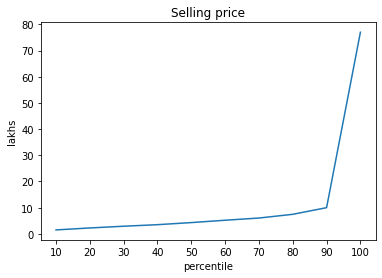

In [ ]:
# Understanding selling price with percentile( 10 to 100)
percentile_10_100 = [round(np.percentile(carsData.selling_price,i),2) for i in range(10,110,10)]
plt.plot(range(10,110,10), percentile_10_100)
plt.title("Selling price")
plt.xlabel('percentile')
plt.ylabel('lakhs')
plt.xticks(range(10,110,10))
plt.show()

* understanding the sudden spike in value between 90 to 100 percentile

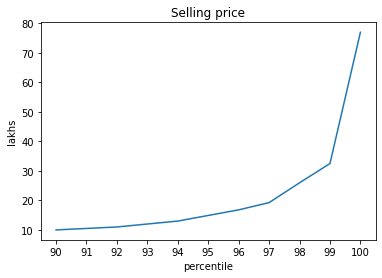

Selling price at 97 percentile: 19.25 Lakhs
Selling price at 98 percentile: 25.97 Lakhs
Selling price at 99 percentile: 32.5 Lakhs


In [ ]:
# percentile between ( 90 to 100)
percentile_90_100 = [round(np.percentile(carsData.selling_price,i),2) for i in range(90,101)]
plt.plot(range(90,101), percentile_90_100)
plt.title("Selling price")
plt.xlabel('percentile')
plt.ylabel('lakhs')
plt.xticks(range(90,101))
plt.show()

# Selling price at 97, 98, 99 percentile
for i in range(97,100):
  print('Selling price at {} percentile: {} Lakhs'.format(i,round(np.percentile(carsData.selling_price,i),2)))

* between 99 to 100 percentile there is spike from 35lakhs to 80 lakhs

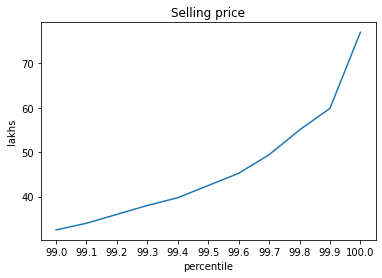

Selling price at 99.0 percentile: 32.5 Lakhs
Selling price at 99.1 percentile: 34.0 Lakhs
Selling price at 99.2 percentile: 36.0 Lakhs
Selling price at 99.3 percentile: 38.0 Lakhs
Selling price at 99.4 percentile: 39.75 Lakhs
Selling price at 99.5 percentile: 42.5 Lakhs
Selling price at 99.6 percentile: 45.24 Lakhs
Selling price at 99.7 percentile: 49.43 Lakhs
Selling price at 99.8 percentile: 55.0 Lakhs
Selling price at 99.9 percentile: 59.87 Lakhs
Selling price at 100.0 percentile: 77.0 Lakhs


In [ ]:
# percentile between ( 90 to 100)
percentile_99_100 = [round(np.percentile(carsData.selling_price,i),2) for i in np.linspace(99,100,11)]
plt.plot(np.linspace(99,100,11), percentile_99_100)
plt.title("Selling price")
plt.xlabel('percentile')
plt.ylabel('lakhs')
plt.xticks(np.linspace(99,100,11))
plt.show()

# Selling price between 99 to 100 percentile
for i in np.linspace(99,100,11):
  print('Selling price at {} percentile: {} Lakhs'.format(i,round(np.percentile(carsData.selling_price,i),2)))

* There is no spike between 99 to 100 percentile.

In [ ]:
# Drop cars more then 99 percentile
highSellingCars = carsData.loc[carsData['selling_price'] > np.percentile(carsData.selling_price,99),['make','model']].value_counts()
print("Cars selling price greater than 30 lakhs:\n",pd.DataFrame(highSellingCars))
print("\nTotal sum of cars:",highSellingCars.sum())

Cars selling price greater than 30 lakhs:
                                    0
make          model                 
BMW           5-Series            19
Land Rover    Discovery           10
BMW           X1                   8
Toyota        Fortuner             8
BMW           X3                   7
Land Rover    Range Rover Evoque   6
BMW           X4                   5
              3-Series             4
              6-Series             4
Ford          Endeavour            4
Jaguar        XF                   4
Audi          A6                   4
              A4                   3
Volvo         XC40                 3
Mercedes-Benz GL-Class             3
Lexus         ES                   3
Land Rover    Discovery Sport      3
Mercedes-Benz S-Class              2
Audi          Q5                   2
Jeep          Wrangler             1
Mercedes-Benz C-Class              1
              E-Class              1
Jaguar        XE                   1
Mercedes-Benz GLS               

* Cannot cap car price because model will get trained on wrong price.
* drop high value cars with less counts for better model performance.

In [ ]:
high_val_index = carsData.loc[carsData['selling_price'] > np.percentile(carsData.selling_price,99)].index
carsData.drop(index=high_val_index, axis=0, inplace=True)

**Mileage**

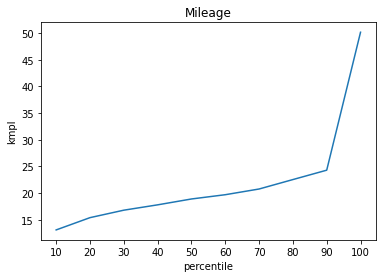

In [ ]:
# Understanding Mileage percentile( 10 to 100)
percentile_10_100 = [round(np.percentile(carsData.mileage,i),2) for i in range(10,110,10)]
plt.plot(range(10,110,10), percentile_10_100)
plt.title("Mileage")
plt.xlabel('percentile')
plt.ylabel('kmpl')
plt.xticks(range(10,110,10))
plt.show()

* understanding the dip before 30 percentile.

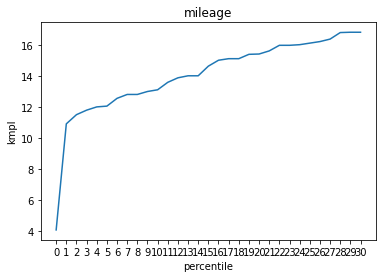

Mileage at 0 percentile: 4.09 kmpl
Mileage at 1 percentile: 10.91 kmpl
Mileage at 2 percentile: 11.5 kmpl
Mileage at 3 percentile: 11.79 kmpl
Mileage at 4 percentile: 12.0 kmpl
Mileage at 5 percentile: 12.05 kmpl
Mileage at 6 percentile: 12.55 kmpl
Mileage at 7 percentile: 12.8 kmpl
Mileage at 8 percentile: 12.8 kmpl
Mileage at 9 percentile: 12.99 kmpl
Mileage at 10 percentile: 13.1 kmpl
Mileage at 11 percentile: 13.58 kmpl
Mileage at 12 percentile: 13.87 kmpl
Mileage at 13 percentile: 14.0 kmpl
Mileage at 14 percentile: 14.0 kmpl
Mileage at 15 percentile: 14.62 kmpl
Mileage at 16 percentile: 15.0 kmpl
Mileage at 17 percentile: 15.1 kmpl
Mileage at 18 percentile: 15.1 kmpl
Mileage at 19 percentile: 15.38 kmpl
Mileage at 20 percentile: 15.4 kmpl
Mileage at 21 percentile: 15.6 kmpl
Mileage at 22 percentile: 15.96 kmpl
Mileage at 23 percentile: 15.96 kmpl
Mileage at 24 percentile: 16.0 kmpl
Mileage at 25 percentile: 16.1 kmpl
Mileage at 26 percentile: 16.2 kmpl
Mileage at 27 percentile: 1

In [ ]:
# percentile between ( 0 to 30)
percentile_0_30 = [round(np.percentile(carsData.mileage,i),2) for i in range(0,31)]
plt.plot(range(0,31), percentile_0_30)
plt.title("mileage")
plt.xlabel('percentile')
plt.ylabel('kmpl')
plt.xticks(range(0,31))
plt.show()

# Mileage at 97, 98, 99 percentile
for i in range(0,31):
  print('Mileage at {} percentile: {} kmpl'.format(i,round(np.percentile(carsData.mileage,i),2)))

* between 0 to 1 percentile

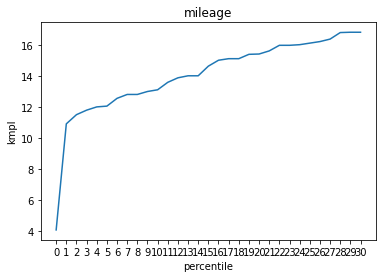

Mileage at 0 percentile: 4.09 kmpl
Mileage at 1 percentile: 10.91 kmpl
Mileage at 2 percentile: 11.5 kmpl
Mileage at 3 percentile: 11.79 kmpl
Mileage at 4 percentile: 12.0 kmpl
Mileage at 5 percentile: 12.05 kmpl
Mileage at 6 percentile: 12.55 kmpl
Mileage at 7 percentile: 12.8 kmpl
Mileage at 8 percentile: 12.8 kmpl
Mileage at 9 percentile: 12.99 kmpl
Mileage at 10 percentile: 13.1 kmpl
Mileage at 11 percentile: 13.58 kmpl
Mileage at 12 percentile: 13.87 kmpl
Mileage at 13 percentile: 14.0 kmpl
Mileage at 14 percentile: 14.0 kmpl
Mileage at 15 percentile: 14.62 kmpl
Mileage at 16 percentile: 15.0 kmpl
Mileage at 17 percentile: 15.1 kmpl
Mileage at 18 percentile: 15.1 kmpl
Mileage at 19 percentile: 15.38 kmpl
Mileage at 20 percentile: 15.4 kmpl
Mileage at 21 percentile: 15.6 kmpl
Mileage at 22 percentile: 15.96 kmpl
Mileage at 23 percentile: 15.96 kmpl
Mileage at 24 percentile: 16.0 kmpl
Mileage at 25 percentile: 16.1 kmpl
Mileage at 26 percentile: 16.2 kmpl
Mileage at 27 percentile: 1

In [ ]:
# percentile between ( 0 to 1)
percentile_0_30 = [round(np.percentile(carsData.mileage,i),2) for i in range(0,31)]
plt.plot(range(0,31), percentile_0_30)
plt.title("mileage")
plt.xlabel('percentile')
plt.ylabel('kmpl')
plt.xticks(range(0,31))
plt.show()

# Mileage at 97, 98, 99 percentile
for i in range(0,31):
  print('Mileage at {} percentile: {} kmpl'.format(i,round(np.percentile(carsData.mileage,i),2)))

* understanding the sudden spike in value between 90 to 100 percentile

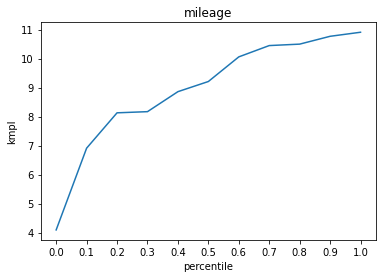

Mileage at 0.0 percentile: 4.09 kmpl
Mileage at 0.1 percentile: 6.91 kmpl
Mileage at 0.2 percentile: 8.13 kmpl
Mileage at 0.3 percentile: 8.17 kmpl
Mileage at 0.4 percentile: 8.86 kmpl
Mileage at 0.5 percentile: 9.21 kmpl
Mileage at 0.6 percentile: 10.06 kmpl
Mileage at 0.7 percentile: 10.45 kmpl
Mileage at 0.8 percentile: 10.5 kmpl
Mileage at 0.9 percentile: 10.77 kmpl
Mileage at 1.0 percentile: 10.91 kmpl


In [ ]:
# percentile between ( 0 to 1)
percentile_0_1 = [round(np.percentile(carsData.mileage,i),2) for i in np.linspace(0,1,11)]
plt.plot(np.linspace(0,1,11), percentile_0_1)
plt.title("mileage")
plt.xlabel('percentile')
plt.ylabel('kmpl')
plt.xticks(np.linspace(0,1,11))
plt.show()

# Mileage 
for i in np.linspace(0,1,11):
  print('Mileage at {} percentile: {} kmpl'.format(round(i,2),round(np.percentile(carsData.mileage,i),2)))

In [ ]:
# cars less than 1 percentile
lowMileageCars = carsData.loc[carsData['mileage'] < np.percentile(carsData.mileage,0.1),['make','model','fuel']].value_counts()
print("Cars mileage less than 1 percentile:\n",pd.DataFrame(lowMileageCars))
print("\nTotal sum of cars:",lowMileageCars.sum())

Cars mileage less than 1 percentile:
                                          0
make          model    fuel               
Maruti        Alto     Petrol + AltFuel  2
Audi          A6       Diesel            1
Ford          Ikon     Diesel            1
Honda         Civic    Petrol            1
Hyundai       Sonata   Diesel            1
MG            Hector   Diesel            1
Mercedes-Benz B-Class  Petrol            1
Mitsubishi    Pajero   Diesel            1
Skoda         Octavia  Petrol            1
              Superb   Petrol            1
Toyota        Fortuner Diesel            1

Total sum of cars: 12


* incorrect data noted hence drop

In [ ]:
low_kmpl_index = carsData.loc[carsData['mileage'] < np.percentile(carsData.mileage,0.1)].index
carsData.drop(index=low_kmpl_index, axis=0, inplace = True)

* Analyzing variance above 90 percentile

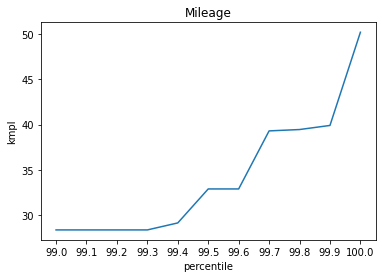

Mileage at 99.0 percentile: 28.4 kmpl
Mileage at 99.1 percentile: 28.4 kmpl
Mileage at 99.2 percentile: 28.4 kmpl
Mileage at 99.3 percentile: 28.4 kmpl
Mileage at 99.4 percentile: 29.17 kmpl
Mileage at 99.5 percentile: 32.91 kmpl
Mileage at 99.6 percentile: 32.91 kmpl
Mileage at 99.7 percentile: 39.3 kmpl
Mileage at 99.8 percentile: 39.45 kmpl
Mileage at 99.9 percentile: 39.9 kmpl
Mileage at 100.0 percentile: 50.16 kmpl


In [ ]:
# percentile between ( 90 to 100)
percentile_99_100 = [round(np.percentile(carsData.mileage,i),2) for i in np.linspace(99,100,11)]
plt.plot(np.linspace(99,100,11), percentile_99_100)
plt.title("Mileage")
plt.xlabel('percentile')
plt.ylabel('kmpl')
plt.xticks(np.linspace(99,100,11))
plt.show()

# Mileage between 99 to 100 percentile
for i in np.linspace(99,100,11):
  print('Mileage at {} percentile: {} kmpl'.format(i,round(np.percentile(carsData.mileage,i),2)))

* There is high spike between 99 to 100 percentile.

In [ ]:
# cars more then 99.4 percentile
highMileageCars = carsData.loc[carsData['mileage'] > np.percentile(carsData.mileage,99.4),['make','model','fuel']].value_counts()
print("Cars mileage greater than 99 percentile:\n",pd.DataFrame(highMileageCars))
print("\nTotal sum of cars:",highMileageCars.sum())

Cars mileage greater than 99 percentile:
                                   0
make    model  fuel                
Maruti  Eeco   Petrol + AltFuel  26
        Wagon  Petrol + AltFuel  25
        Alto   Petrol + AltFuel   8
        Zen    Petrol + AltFuel   3
Hyundai EON    Petrol + AltFuel   1
        Grand  Petrol + AltFuel   1
Maruti  Ertiga Petrol + AltFuel   1
        SX4    Petrol + AltFuel   1
        Swift  Petrol + AltFuel   1
Tata    Indica Petrol + AltFuel   1

Total sum of cars: 68


* capping max mileage to 99.4 percentile value.

In [ ]:
high_kmpl_index = carsData.loc[carsData['mileage'] > np.percentile(carsData.mileage,94)].index
carsData.loc[high_kmpl_index,'mileage'] = round(np.percentile(carsData.mileage,94),2)

**Engine**



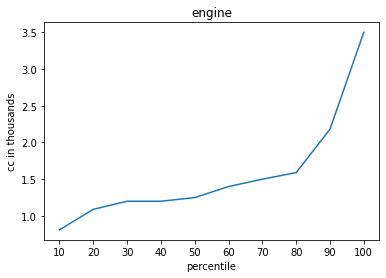

In [ ]:
# Understanding Engine with percentile( 10 to 100)
percentile_10_100 = [round(np.percentile(carsData.engine,i),2) for i in range(10,110,10)]
plt.plot(range(10,110,10), percentile_10_100)
plt.title("engine")
plt.xlabel('percentile')
plt.ylabel('cc in thousands')
plt.xticks(range(10,110,10))
plt.show()

* understanding the sudden spike in value between 90 to 100 percentile

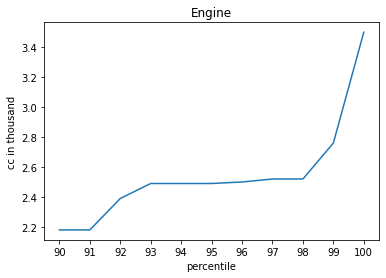

engine at 97 percentile: 2.52 cc
engine at 98 percentile: 2.52 cc
engine at 99 percentile: 2.76 cc


In [ ]:
# percentile between ( 90 to 100)
percentile_90_100 = [round(np.percentile(carsData.engine,i),2) for i in range(90,101)]
plt.plot(range(90,101), percentile_90_100)
plt.title("Engine")
plt.xlabel('percentile')
plt.ylabel('cc in thousand')
plt.xticks(range(90,101))
plt.show()

# engine at 97, 98, 99 percentile
for i in range(97,100):
  print('engine at {} percentile: {} cc'.format(i,round(np.percentile(carsData.engine,i),2)))

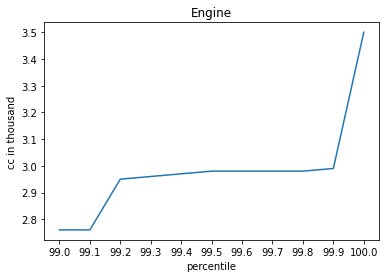

Engine at 99.0 percentile: 2.76 cc
Engine at 99.1 percentile: 2.76 cc
Engine at 99.2 percentile: 2.95 cc
Engine at 99.3 percentile: 2.96 cc
Engine at 99.4 percentile: 2.97 cc
Engine at 99.5 percentile: 2.98 cc
Engine at 99.6 percentile: 2.98 cc
Engine at 99.7 percentile: 2.98 cc
Engine at 99.8 percentile: 2.98 cc
Engine at 99.9 percentile: 2.99 cc
Engine at 100.0 percentile: 3.5 cc


In [ ]:
# percentile between ( 90 to 100)
percentile_99_100 = [round(np.percentile(carsData.engine,i),2) for i in np.linspace(99,100,11)]
plt.plot(np.linspace(99,100,11), percentile_99_100)
plt.title("Engine")
plt.xlabel('percentile')
plt.ylabel('cc in thousand')
plt.xticks(np.linspace(99,100,11))
plt.show()

# Selling price between 99 to 100 percentile
for i in np.linspace(99,100,11):
  print('Engine at {} percentile: {} cc'.format(i,round(np.percentile(carsData.engine,i),2)))

* There is spike between 99.9 to 100 percentile.

In [ ]:
# Drop cars more then 99.9 percentile
highEngineCars = carsData.loc[carsData['engine'] > np.percentile(carsData.engine,99.9),['make','model']].value_counts()
print("Cars engine greater than 99 percentile:\n",pd.DataFrame(highEngineCars))
print("\nTotal sum of cars:",highEngineCars.sum())

Cars engine greater than 99 percentile:
                          0
make          model       
Ford          Endeavour  4
Honda         Accord     2
Mercedes-Benz E-Class    1

Total sum of cars: 7


* Cannot cap car price because model will get trained on wrong data.
* drop high value cars with less counts for better model performance.

In [ ]:
high_engine_index = carsData.loc[carsData['engine'] > np.percentile(carsData.engine,99.9)].index
carsData.drop(index=high_engine_index, axis=0, inplace=True)

**Max Power**



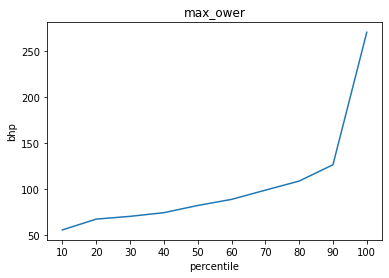

In [ ]:
# Understanding max_power with percentile( 10 to 100)
percentile_10_100 = [round(np.percentile(carsData.max_power,i),2) for i in range(10,110,10)]
plt.plot(range(10,110,10), percentile_10_100)
plt.title("max_ower")
plt.xlabel('percentile')
plt.ylabel('bhp')
plt.xticks(range(10,110,10))
plt.show()

* understanding the sudden spike in value between 90 to 100 percentile

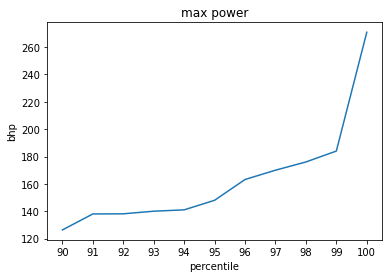

Max power at 97 percentile: 170.0 bhp
Max power at 98 percentile: 176.02 bhp
Max power at 99 percentile: 184.0 bhp


In [ ]:
# percentile between ( 90 to 100)
percentile_90_100 = [round(np.percentile(carsData.max_power,i),2) for i in range(90,101)]
plt.plot(range(90,101), percentile_90_100)
plt.title("max power")
plt.xlabel('percentile')
plt.ylabel('bhp')
plt.xticks(range(90,101))
plt.show()

# power at 97, 98, 99 percentile
for i in range(97,100):
  print('Max power at {} percentile: {} bhp'.format(i,round(np.percentile(carsData.max_power,i),2)))

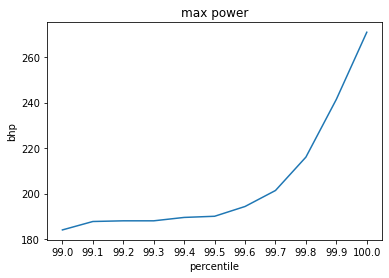

power at 99.0 percentile: 184.0 cc
power at 99.1 percentile: 187.7 cc
power at 99.2 percentile: 188.0 cc
power at 99.3 percentile: 188.0 cc
power at 99.4 percentile: 189.49 cc
power at 99.5 percentile: 190.0 cc
power at 99.6 percentile: 194.3 cc
power at 99.7 percentile: 201.33 cc
power at 99.8 percentile: 216.01 cc
power at 99.9 percentile: 241.4 cc
power at 100.0 percentile: 270.9 cc


In [ ]:
# percentile between ( 90 to 100)
percentile_99_100 = [round(np.percentile(carsData.max_power,i),2) for i in np.linspace(99,100,11)]
plt.plot(np.linspace(99,100,11), percentile_99_100)
plt.title("max power")
plt.xlabel('percentile')
plt.ylabel('bhp')
plt.xticks(np.linspace(99,100,11))
plt.show()

# power between 99 to 100 percentile
for i in np.linspace(99,100,11):
  print('power at {} percentile: {} cc'.format(i,round(np.percentile(carsData.max_power,i),2)))

* There is spike between 99.8 to 100 percentile.

In [ ]:
# Drop cars more then 99.9 percentile
highPowerCars = carsData.loc[carsData['max_power'] > np.percentile(carsData.max_power,99.8),['make','model']].value_counts()
print("Cars power greater than 99 percentile:\n",pd.DataFrame(highPowerCars))
print("\nTotal sum of cars:",highPowerCars.sum())

Cars power greater than 99 percentile:
                         0
make          model      
BMW           5-Series  7
Audi          Q7        6
BMW           7-Series  3
Audi          Q5        2
Jaguar        XF        2
BMW           X5        1
Mercedes-Benz GL-Class  1
              M-Class   1

Total sum of cars: 23


* Cannot cap car price because model will get trained on wrong data.
* drop high power cars with less counts for better model performance.

In [ ]:
high_power_index = carsData.loc[carsData['max_power'] > np.percentile(carsData.max_power,99.8)].index
carsData.drop(index=high_power_index, axis=0, inplace=True)

**Seats**



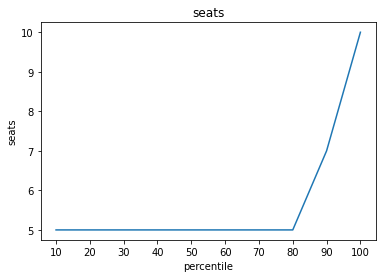

In [ ]:
# Understanding seats with percentile( 10 to 100)
percentile_10_100 = [round(np.percentile(carsData.seats,i),2) for i in range(10,110,10)]
plt.plot(range(10,110,10), percentile_10_100)
plt.title("seats")
plt.xlabel('percentile')
plt.ylabel('seats')
plt.xticks(range(10,110,10))
plt.show()

* understanding the sudden spike in value between 80 to 100 percentile

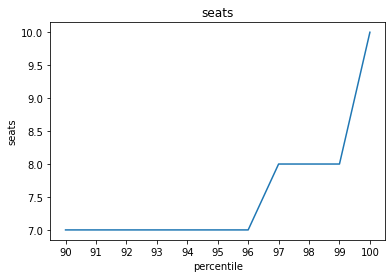

Seats at 97 percentile: 8.0 seats
Seats at 98 percentile: 8.0 seats
Seats at 99 percentile: 8.0 seats


In [ ]:
# percentile between ( 90 to 100)
percentile_90_100 = [round(np.percentile(carsData.seats,i),2) for i in range(90,101)]
plt.plot(range(90,101), percentile_90_100)
plt.title("seats")
plt.xlabel('percentile')
plt.ylabel('seats')
plt.xticks(range(90,101))
plt.show()

# seats at 97, 98, 99 percentile
for i in range(97,100):
  print('Seats at {} percentile: {} seats'.format(i,round(np.percentile(carsData.seats,i),2)))

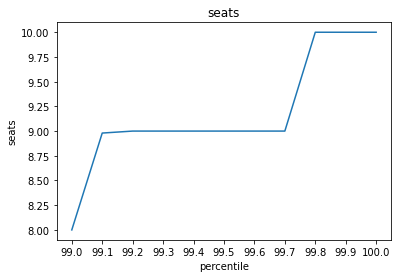

Seats at 99.0 percentile: 8.0 seats
Seats at 99.1 percentile: 8.98 seats
Seats at 99.2 percentile: 9.0 seats
Seats at 99.3 percentile: 9.0 seats
Seats at 99.4 percentile: 9.0 seats
Seats at 99.5 percentile: 9.0 seats
Seats at 99.6 percentile: 9.0 seats
Seats at 99.7 percentile: 9.0 seats
Seats at 99.8 percentile: 10.0 seats
Seats at 99.9 percentile: 10.0 seats
Seats at 100.0 percentile: 10.0 seats


In [ ]:
# percentile between ( 90 to 100)
percentile_99_100 = [round(np.percentile(carsData.seats,i),2) for i in np.linspace(99,100,11)]
plt.plot(np.linspace(99,100,11), percentile_99_100)
plt.title("seats")
plt.xlabel('percentile')
plt.ylabel('seats')
plt.xticks(np.linspace(99,100,11))
plt.show()

# power between 99 to 100 percentile
for i in np.linspace(99,100,11):
  print('Seats at {} percentile: {} seats'.format(i,round(np.percentile(carsData.seats,i),2)))

* There is spike between 99. to 100 percentile.

In [ ]:
# cars more then 99 percentile
highSeatsCars = carsData.loc[carsData['seats'] >8,['make','model']].value_counts()
print("Cars age greater than 99 percentile:\n",pd.DataFrame(highSeatsCars))
print("\nTotal sum of cars:",highSeatsCars.sum())

Cars age greater than 99 percentile:
                     0
make      model      
Mahindra  Bolero   35
Chevrolet Tavera   33
Mahindra  Scorpio  22
Tata      Sumo      8
Mahindra  TUV       2
          Xylo      1
Toyota    Qualis    1

Total sum of cars: 102


* There are 102 cars hence not dropping.

**Age**



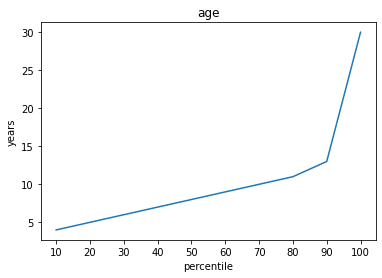

In [ ]:
# Understanding seats with percentile( 10 to 100)
percentile_10_100 = [round(np.percentile(carsData.age,i),2) for i in range(10,110,10)]
plt.plot(range(10,110,10), percentile_10_100)
plt.title("age")
plt.xlabel('percentile')
plt.ylabel('years')
plt.xticks(range(10,110,10))
plt.show()

* understanding the sudden spike in value between 80 to 100 percentile

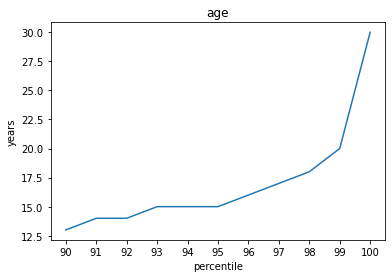

age at 97 percentile: 17.0 years
age at 98 percentile: 18.0 years
age at 99 percentile: 20.0 years


In [ ]:
# percentile between ( 90 to 100)
percentile_90_100 = [round(np.percentile(carsData.age,i),2) for i in range(90,101)]
plt.plot(range(90,101), percentile_90_100)
plt.title("age")
plt.xlabel('percentile')
plt.ylabel('years')
plt.xticks(range(90,101))
plt.show()

# seats at 97, 98, 99 percentile
for i in range(97,100):
  print('age at {} percentile: {} years'.format(i,round(np.percentile(carsData.age,i),2)))

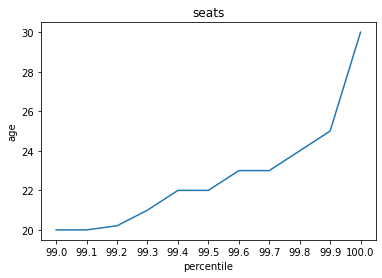

age at 99.0 percentile: 20.0 years
age at 99.1 percentile: 20.0 years
age at 99.2 percentile: 20.21 years
age at 99.3 percentile: 21.0 years
age at 99.4 percentile: 22.0 years
age at 99.5 percentile: 22.0 years
age at 99.6 percentile: 23.0 years
age at 99.7 percentile: 23.0 years
age at 99.8 percentile: 24.0 years
age at 99.9 percentile: 25.0 years
age at 100.0 percentile: 30.0 years


In [ ]:
# percentile between ( 90 to 100)
percentile_99_100 = [round(np.percentile(carsData.age,i),2) for i in np.linspace(99,100,11)]
plt.plot(np.linspace(99,100,11), percentile_99_100)
plt.title("seats")
plt.xlabel('percentile')
plt.ylabel('age')
plt.xticks(np.linspace(99,100,11))
plt.show()

# power between 99 to 100 percentile
for i in np.linspace(99,100,11):
  print('age at {} percentile: {} years'.format(i,round(np.percentile(carsData.age,i),2)))

* There is spike between 99. to 100 percentile.

In [ ]:
# cars more then 99.9 percentile
highAgeCars = carsData.loc[carsData['age'] > np.percentile(carsData.age,99.9),['make','model']].value_counts()
print("Cars age greater than 99.9 percentile:\n",pd.DataFrame(highAgeCars))
print("\nTotal sum of cars:",highAgeCars.sum())

Cars age greater than 99.9 percentile:
               0
make   model   
Maruti 800    5
       Gypsy  1

Total sum of cars: 6


* Cannot cap car age because model will get trained on wrong data.
* drop high age cars with less counts for better model performance.

In [ ]:
high_age_index = carsData.loc[carsData['age'] > np.percentile(carsData.age,99.9)].index
carsData.drop(index=high_age_index, axis=0, inplace=True)

In [ ]:
# Categorical Features Overview
carsData.describe(include='object')

,make,model,variant,km_driven,fuel,seller_type,transmission,owner,best_resale,seats_cat
count,11219,11219,11219,11219,11219,11219,11219,11219,11219,11219
unique,24,171,2559,42,3,5,2,6,2,3
top,Maruti,Alto,VDI,60000 - 70000 Km,Diesel,Individual,Manual,1st owner,yes,5andBelow
freq,3562,667,453,1102,5869,9846,10082,7256,9045,9136


**Observation**
Out of total 11k cars:
* 9k cars have 5 seats or below.
* 10k cars are manual driven or individual seller.
* Varient feature has 2.6k unique categories.
* 9k cars are from best resale brands i.e the depreciation rate is low.
* 6k cars are with diesel fuel.

## Data Visualization
* Visualizing unique features and its observation

### Univariant analysis

**Make(brand name)**

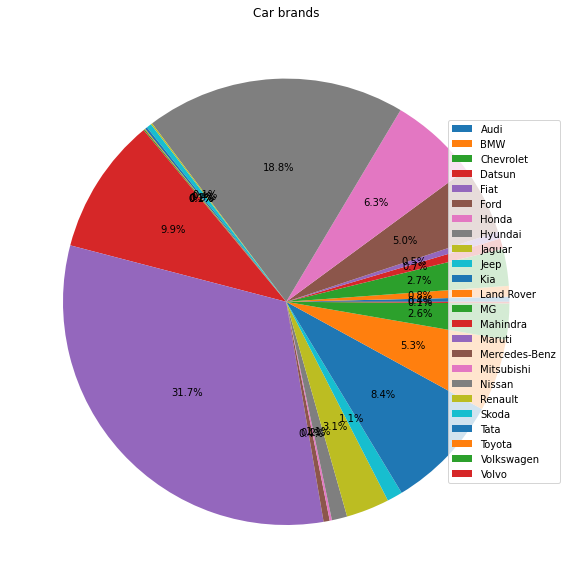

In [ ]:
# Pie chart to observe the total percentage share of each brand in the dataset
carsMakeCounts = np.unique(carsData['make'], return_counts=True)
plt.figure(figsize=(10,20))
plt.pie(carsMakeCounts[1],autopct='%1.1f%%')
plt.title("Car brands")
plt.legend(carsMakeCounts[0], loc = 7)
plt.show()

**Observation**
* About 75 % of cars brands are Maruti, Hyundai, Mahindra, Tata, Honda, Toyota, Ford.
* Out of which 30% share is with Maruti
* Rate of depreciation affects differently for different country car brands.

**Fuel**

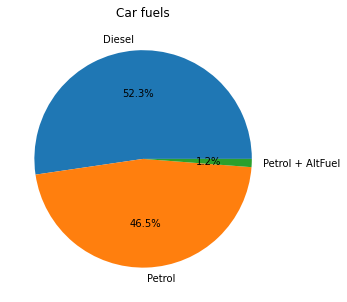

In [ ]:
carsFuelCounts = np.unique(carsData['fuel'], return_counts=True)
plt.figure(figsize=(5,5))
plt.pie(carsFuelCounts[1], labels = carsFuelCounts[0], autopct='%1.1f%%')
plt.title("Car fuels")
plt.show()

**Observation**
* Diesel and Petrol make almost 97% of the used cars in the data.

**Seller type**

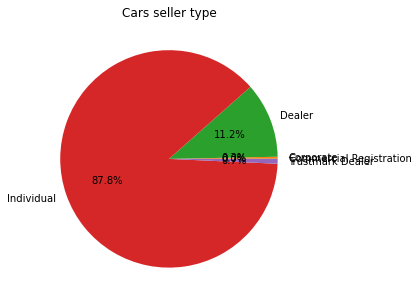

In [ ]:
carsSellerCounts = np.unique(carsData['seller_type'], return_counts=True)
plt.figure(figsize=(5,5))
plt.pie(carsSellerCounts[1], labels = carsSellerCounts[0], autopct='%1.1f%%')
plt.title("Cars seller type")
plt.show()

**Observation**
* Most of the cars are sold by Individual.
* Cars sold by dealer will have dealer commission included. 

**Transmission**

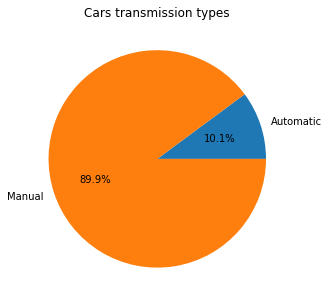

In [ ]:
carsTransmissionCounts = np.unique(carsData['transmission'], return_counts=True)
plt.figure(figsize=(5,5))
plt.pie(carsTransmissionCounts[1], labels = carsTransmissionCounts[0], autopct='%1.1f%%')
plt.title("Cars transmission types")
plt.show()

**Observation**
* Majority of the cars have manual transmission.
* Manual transmission are known to be relaible than automatic and can affect selling price.
* The cost of owining a automatic in the first place is higher than manual.

**Owner**

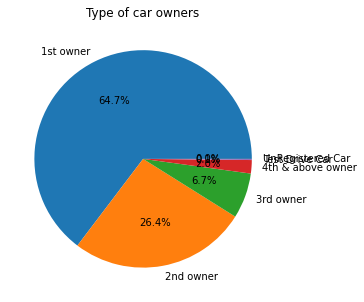

In [ ]:
carsownerCounts = np.unique(carsData['owner'], return_counts=True)
plt.figure(figsize=(5,5))
plt.pie(carsownerCounts[1], labels = carsownerCounts[0], autopct='%1.1f%%')
plt.title("Type of car owners")
plt.show()

**Observation**
* Majority of the cars are sold by first owner and then followed by second owner.
* Major depreciation will be observed first and second owner's car.

**Seats**

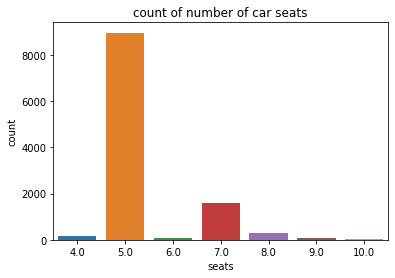

In [ ]:
sns.countplot(x=carsData['seats'])
plt.title("count of number of car seats")
plt.show()

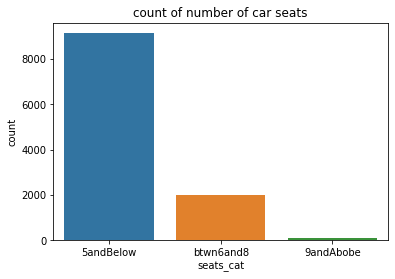

In [ ]:
sns.countplot(x=carsData['seats_cat'])
plt.title("count of number of car seats")
plt.show()

**Observation**
* Majority of the cars in the data are 5 seater followed by 7 seater.
* very few 10 and 14 seater cars.
* need to check bivarriant analysis with respect to selling price to check how does number of seats affect.
* cars with 2 seats are noted need to analyze ans handel if incorrect data.

**Model**

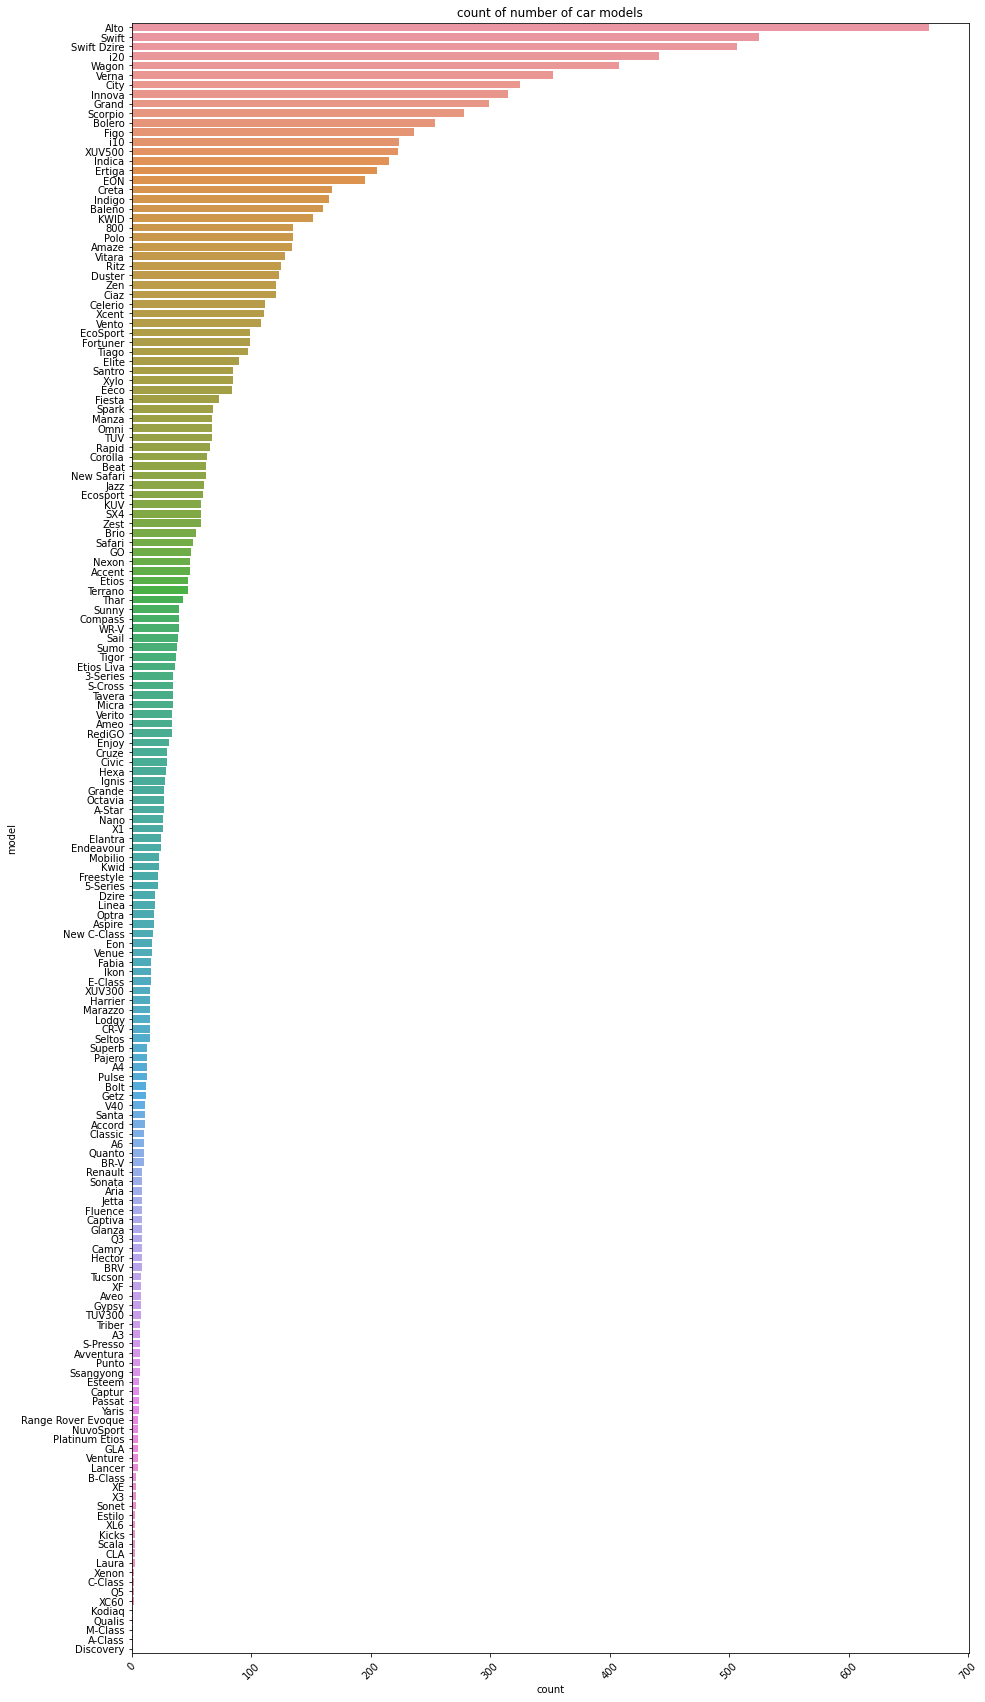

In [ ]:
plt.figure(figsize=(15,30))
sns.countplot(y='model', data = carsData, order = carsData['model'].value_counts().index)
plt.title("count of number of car models")
plt.xticks(rotation = 45)
plt.show()

In [ ]:
modelCount = carsData.model.value_counts()
modelCount[modelCount<3].index.unique()

Index(['Xenon', 'C-Class', 'Q5', 'XC60', 'Kodiaq', 'Qualis', 'M-Class',
       'A-Class', 'Discovery'],
      dtype='object')

**Observation**
* Too many model categories to one hot encode, should find alternate way for encoding or drop the feaure.
* Use catboost model.
* count of models are very less for majority of the models.
* Club these cars counts as Indian, German etc in feature engineering.

**Selling Price**

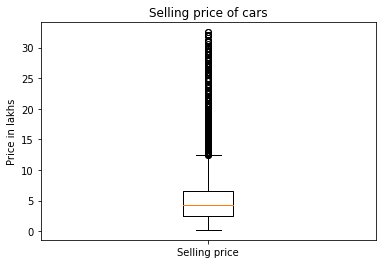

In [ ]:
plt.boxplot(x=carsData['selling_price'].values, labels=['Selling price'])
plt.title("Selling price of cars")
plt.ylabel("Price in lakhs")
plt.show()

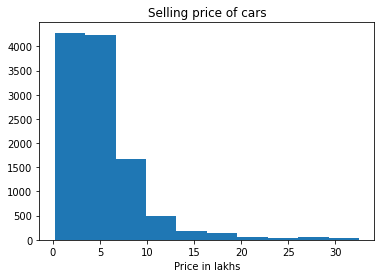

In [ ]:
plt.hist(x=carsData['selling_price'].values)
plt.title("Selling price of cars")
plt.xlabel("Price in lakhs")
plt.show()

**Observation**
* Selling price is a dependent fearure.
* Most of the car value lies below 15 lakhs.
* Potential outliers observed, positive skewed distribution
* All outliers are valid values i.e no human error but needs to be treated.

**Mileage**

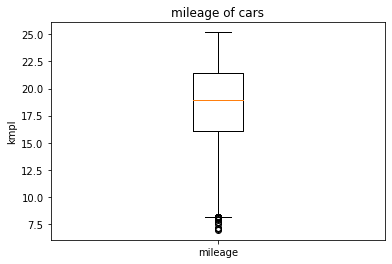

In [ ]:
plt.boxplot(x=carsData['mileage'].values,labels=['mileage'])
plt.title("mileage of cars")
plt.ylabel("kmpl")
plt.show()

**Observation**
* 95% of the cars have milege between 10 kmpl and 25 kmpl.
* Median milage is around 20 kmpl.

**km driven**

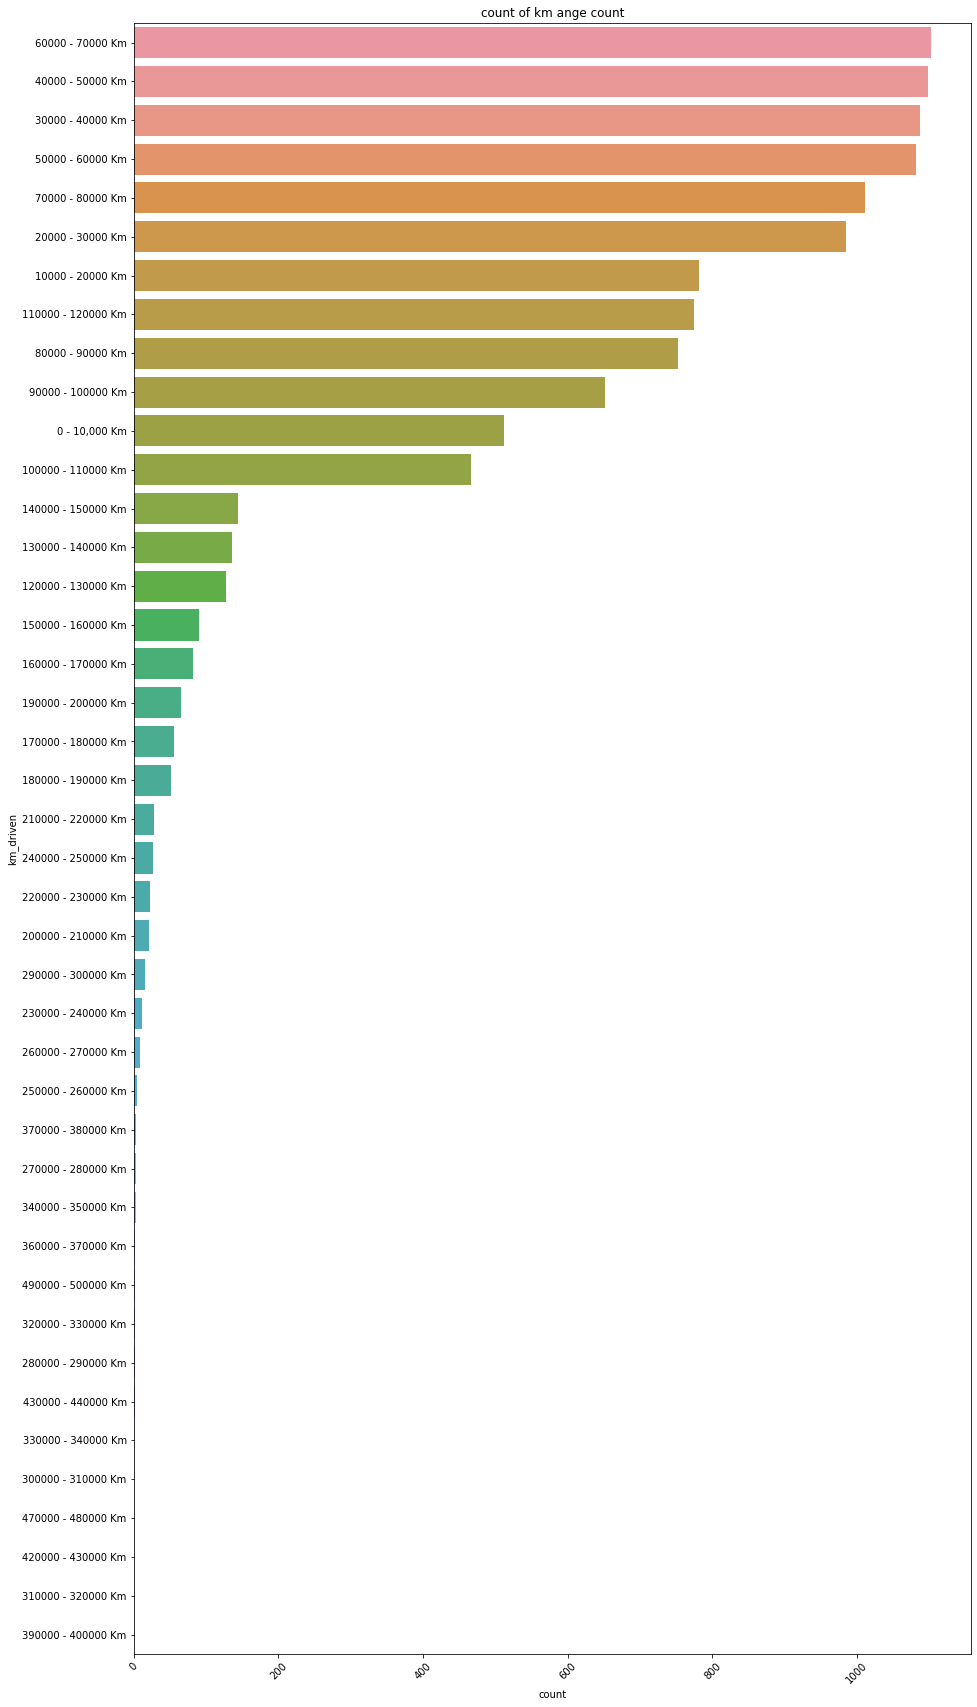

In [ ]:
plt.figure(figsize=(15,30))
sns.countplot(y='km_driven', data = carsData, order = carsData['km_driven'].value_counts().index)
plt.title("count of km ange count")
plt.xticks(rotation = 45)
plt.show()

**Observation**
* Positive skewed data having large outliers.
* 95% of cars have run below 2.5 lakh km.
* cars greater than 3 lakh is possible.

**Engine capacity**

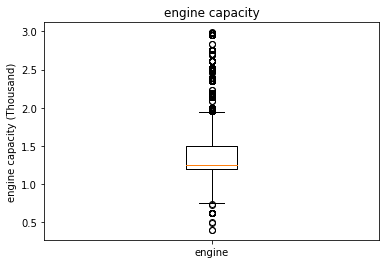

In [ ]:
plt.boxplot(x=carsData['engine'].values,labels=['engine'])
plt.title("engine capacity")
plt.ylabel("engine capacity (Thousand)")
plt.show()

**Observation**
* 95% of the cars have engine size less than 2000 CC.
* 50% of the cars have engine size between 1000 to 2000 CC.
* Potential outliers observed.
* larger engine size are ususlly with sports car and hence can affect selling price.

**Engine power**

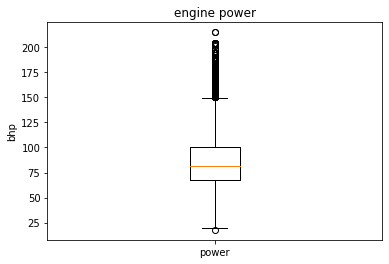

In [ ]:
plt.boxplot(x=carsData['max_power'].values,labels=['power'])
plt.title("engine power")
plt.ylabel("bhp")
plt.show()

In [ ]:
# Analyzing outlier
carsData[carsData['max_power']>200]

,make,model,variant,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,age,best_resale,seats_cat
141,Mercedes-Benz,E-Class,E250 EDITION E,27.00,30000 - 40000 Km,Diesel,Dealer,Automatic,1st owner,15.00,2.14,204.0,5.0,6.0,No,5andBelow
681,Mercedes-Benz,E-Class,E250 CDI AVANTGARDE,30.00,30000 - 40000 Km,Diesel,Individual,Automatic,1st owner,13.00,2.14,204.0,5.0,6.0,No,5andBelow
1060,Mercedes-Benz,E-Class,E250 CDI AVANTGARDE,29.00,30000 - 40000 Km,Diesel,Dealer,Automatic,1st owner,13.00,2.14,204.0,5.0,6.0,No,5andBelow
3461,Mercedes-Benz,E-Class,E 250 ELEGANCE,11.90,70000 - 80000 Km,Petrol,Individual,Automatic,2nd owner,10.93,2.50,204.0,5.0,11.0,No,5andBelow
4375,Mercedes-Benz,M-Class,ML 250 CDI,26.00,90000 - 100000 Km,Diesel,Individual,Automatic,2nd owner,15.26,2.14,203.2,5.0,7.0,No,5andBelow
4692,Mercedes-Benz,E-Class,E 250 ELEGANCE,12.00,30000 - 40000 Km,Petrol,Individual,Automatic,2nd owner,10.93,2.50,204.0,5.0,12.0,No,5andBelow
4940,Mercedes-Benz,E-Class,E250 CDI AVANTGRADE,18.50,50000 - 60000 Km,Diesel,Individual,Automatic,2nd owner,13.00,2.14,201.1,5.0,8.0,No,5andBelow
5400,Mercedes-Benz,New C-Class,C 250 CDI ELEGANCE,10.00,80000 - 90000 Km,Diesel,Dealer,Automatic,1st owner,14.94,2.14,204.0,5.0,11.0,No,5andBelow
7919,Mercedes-Benz,E-Class,E250 CDI ELEGANCE,16.00,60000 - 70000 Km,Diesel,Individual,Automatic,1st owner,14.21,2.14,203.0,5.0,11.0,No,5andBelow
8216,Toyota,Camry,HYBRID,15.99,90000 - 100000 Km,Petrol,Individual,Automatic,1st owner,19.16,2.49,202.0,5.0,7.0,yes,5andBelow


**Observation**
* 95% of the cars have less than 150 bhp.
* potential outliers observed.
* As BHP increases car goes into sports car category and selling price depreciates at a higher rate compared to lower bhp cars.

**Age**

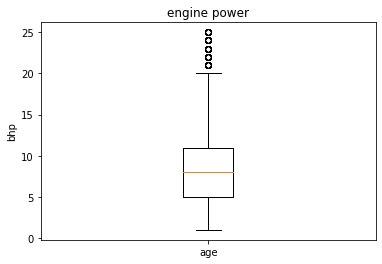

In [ ]:
plt.boxplot(x=carsData['age'].values,labels=['age'])
plt.title("engine power")
plt.ylabel("bhp")
plt.show()

**Observation**
* Potential outliers observed.
* 95% of the cars are below 20 years of age.
* Age inverse proportional to selling price. 

**Best Resale**

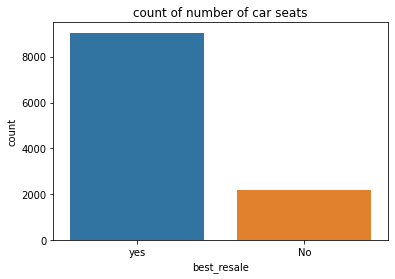

In [ ]:
sns.countplot(x=carsData['best_resale'])
plt.title("count of number of car seats")
plt.show()

**Observation**
* There are more than 50% of cars with best resale compared to lease resale cars.

### Bivariant Analysis
analyzing all the univariant with respect to selling price(dependent feature)

**Make vs Selling price**

[]

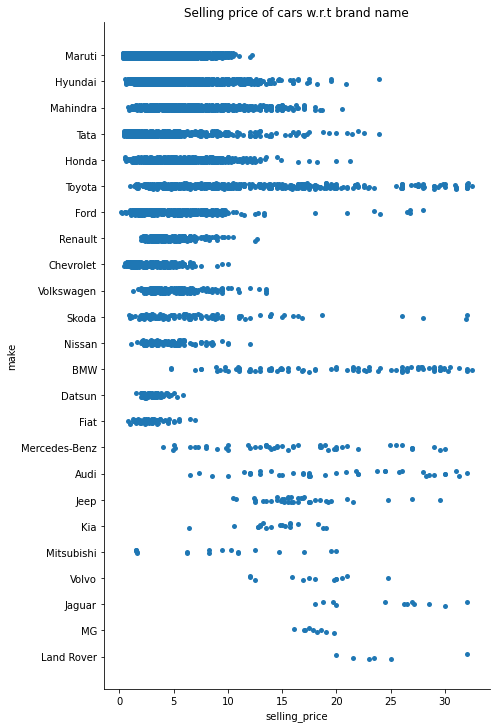

In [ ]:
sns.catplot(data=carsData, y="make", x="selling_price",height=10, aspect=0.7,
            order = carsData['make'].value_counts().index)
plt.title("Selling price of cars w.r.t brand name")
plt.plot()

**Observation**
* Majority of the cars brands having large used car market share have selling price less than 20 lakhs.
* This feature shows wht is the starting and ending selling price for each brand

**Fuel vs Selling price**

[]

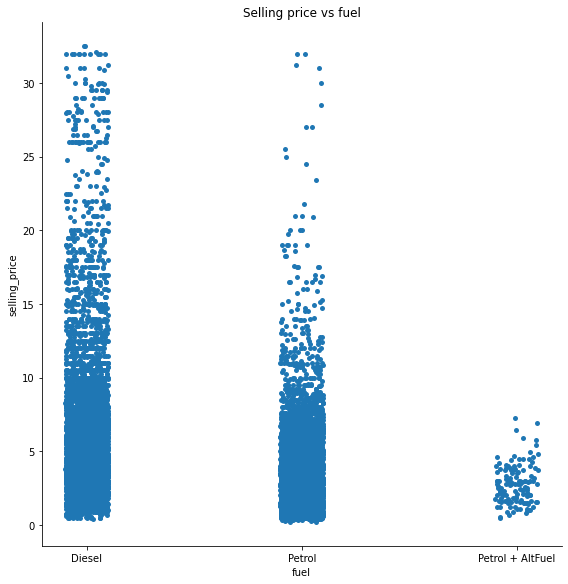

In [ ]:
sns.catplot(data=carsData, x="fuel", y="selling_price",height=8, aspect=1)
plt.title("Selling price vs fuel")
plt.plot()

**Observation**
* LPG and CNG fule type with aroud 1% of cars in the data set have selling price around 10 lakhs.
* Outliers with few highest selling price more than 50 lakh observed in petrol and diesel. 

**Seller type vs Selling price**

[]

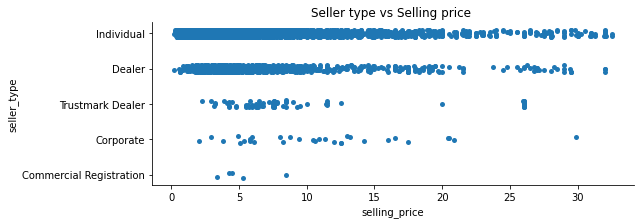

In [ ]:
sns.catplot(data=carsData, y="seller_type", x="selling_price",height=3, aspect=3)
plt.title("Seller type vs Selling price ")
plt.plot()

**Observation**
* Individual and Dealer seller type has cars in all price range.
* Trustmark Dealer and Commercial Registration has cars selling less than 30 lakhs.

**Transmission vs Selling price**

[]

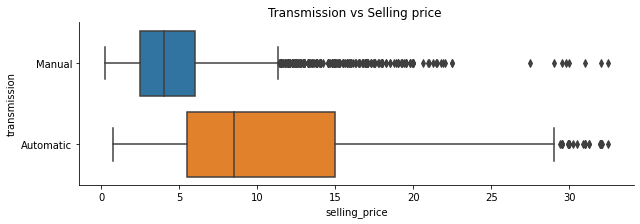

In [ ]:
sns.catplot(data=carsData, y="transmission", x="selling_price",height=3, aspect=3, kind="box")
plt.title("Transmission vs Selling price ")
plt.plot()

In [ ]:
carsData[(carsData['selling_price']>25) & (carsData['transmission']=='Manual')]['model']

350         Fortuner
1821        Fortuner
1990     New C-Class
2881        Fortuner
8736        Fortuner
9131          Innova
9602          Innova
10149       Fortuner
Name: model, dtype: object

**Observation**
* Median selling price of autimatic is at 10 lakh
* 95% of manual transmission is below 10 lakh.
* No data error with outlier.

**Owner vs Selling price**

[]

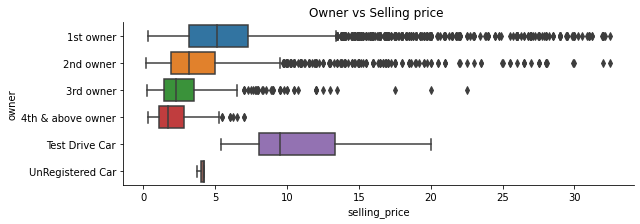

In [ ]:
sns.catplot(data=carsData, y="owner", x="selling_price",height=3, aspect=3, kind="box")
plt.title("Owner vs Selling price ")
plt.plot()

**Observation**
* Majority of the outliers are noted for first and second owner.

**Seats vs Selling price**

[]

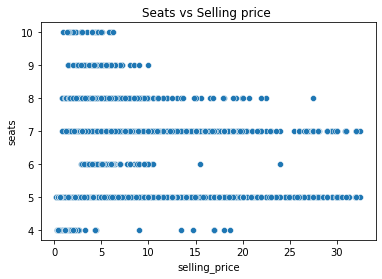

In [ ]:
sns.scatterplot(data=carsData, y="seats", x="selling_price")
plt.title("Seats vs Selling price ")
plt.plot()

[]

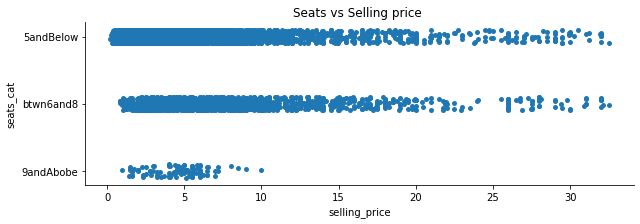

In [ ]:
sns.catplot(data=carsData, y="seats_cat", x="selling_price",height=3, aspect=3)
plt.title("Seats vs Selling price ")
plt.plot()

**Observation**
* 5 and 7 seater cars are present in all selling price.

**Model vs Selling price**

[]

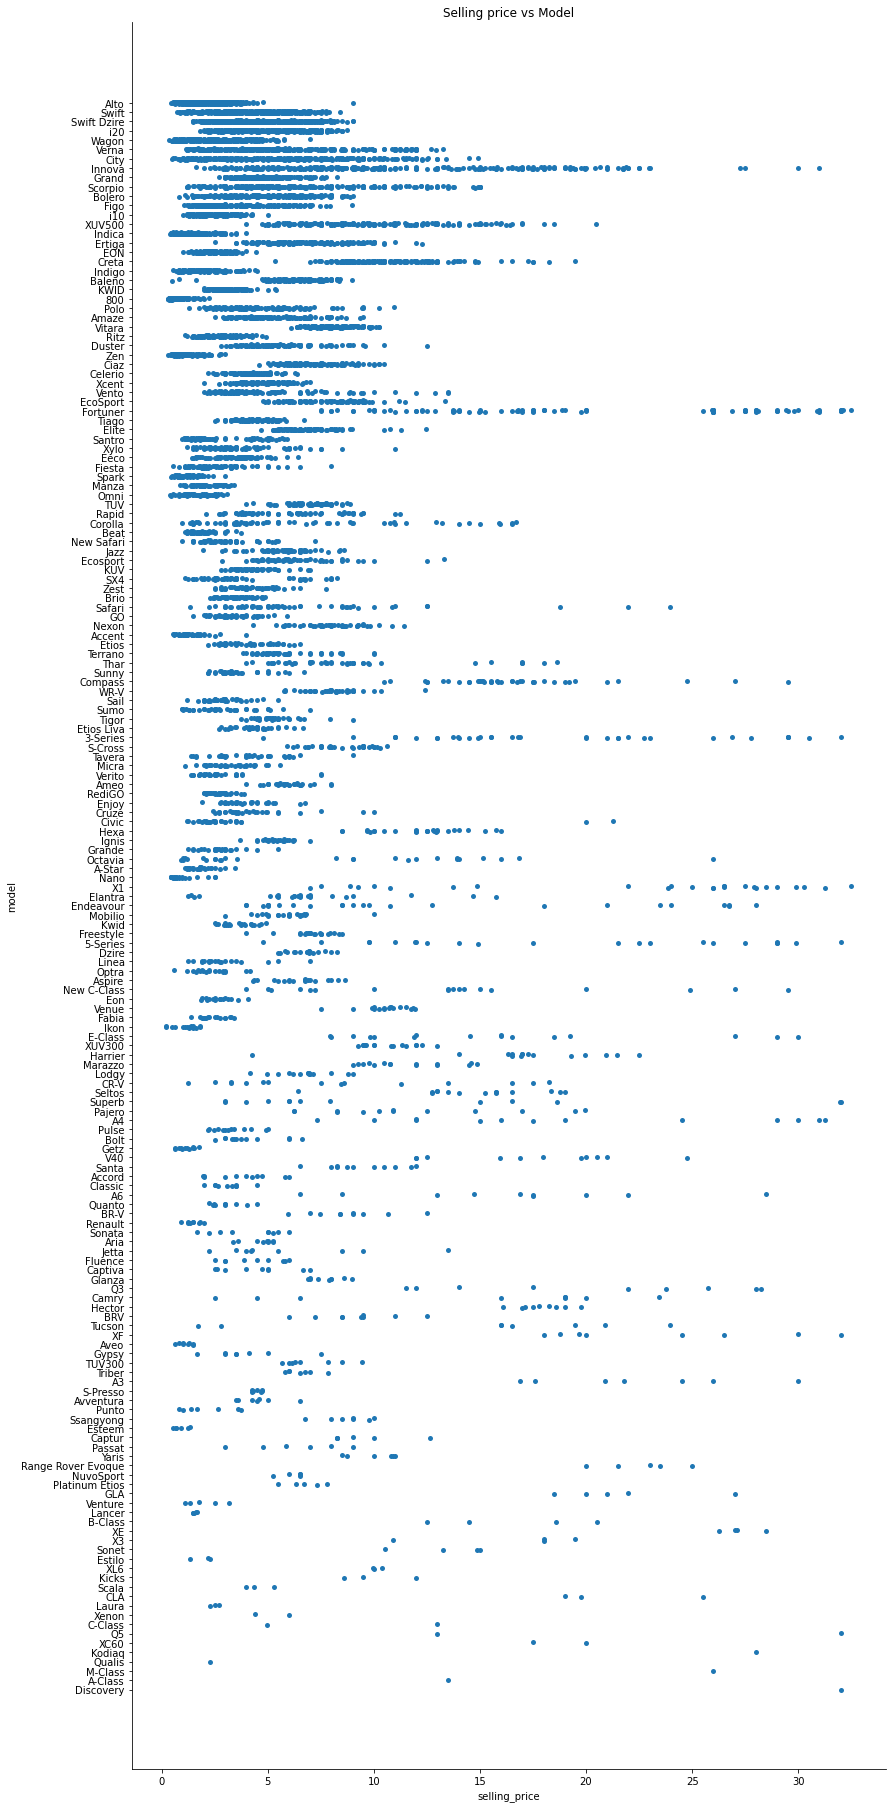

In [ ]:
sns.catplot(data=carsData, y="model", x="selling_price",height=25, aspect=0.5,
            order = carsData['model'].value_counts().index)
plt.title("Selling price vs Model")
plt.plot()

**Observation**
* Majority of the cars models are less than 20 lakhs.

**Milege vs Selling price**

[]

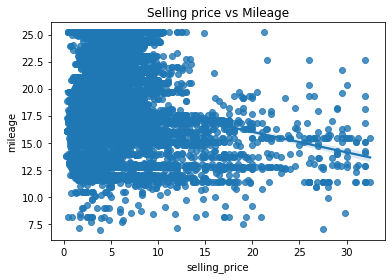

In [ ]:
sns.regplot(data=carsData, y="mileage", x="selling_price")
plt.title("Selling price vs Mileage")
plt.plot()

**Observation**
* Higher mileage for cars below 15 lakhs.
* low mileage with high selling price.

**KM driven vs Selling price**

[]

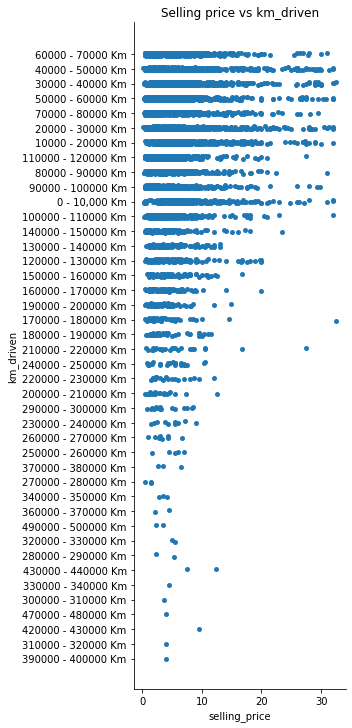

In [ ]:
sns.catplot(data=carsData, y="km_driven", x="selling_price",height=10, aspect=0.5,
            order = carsData['km_driven'].value_counts().index)
plt.title("Selling price vs km_driven")
plt.plot()

**Observation**
* Cars with greater than 2 lakh km sell less than 20 lakhs..

**Engine capacity vs Selling price**

[]

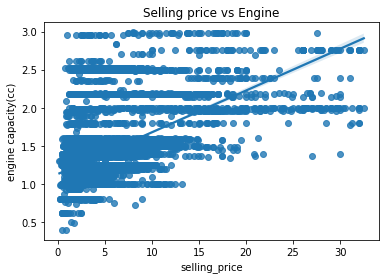

In [ ]:
sns.regplot(data=carsData, y="engine", x="selling_price")
plt.title("Selling price vs Engine")
plt.ylabel('engine capacity(cc)')
plt.plot()

**Observation**
* cars with higher engine capacity tend to have high selling price.

**Engine power vs Selling price**

[]

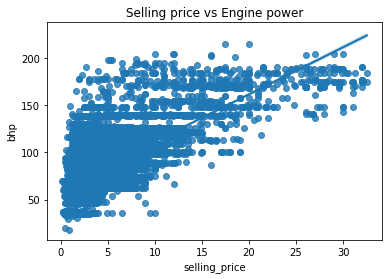

In [ ]:
sns.regplot(data=carsData, y="max_power", x="selling_price")
plt.title("Selling price vs Engine power")
plt.ylabel("bhp")
plt.plot()

**Observation**
* Similar observation noted in Engine capacity.
* Usually higher capacity engine tend to have high power.

**Age vs Selling price**

[]

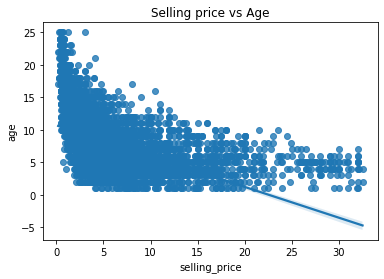

In [ ]:
sns.regplot(data=carsData, y="age", x="selling_price")
plt.title("Selling price vs Age")
plt.plot()

**Observation**
* Cars tend to have higher selling price with lower age.
* as age increases selling price decreases.

**Best resale vs selling price**

[]

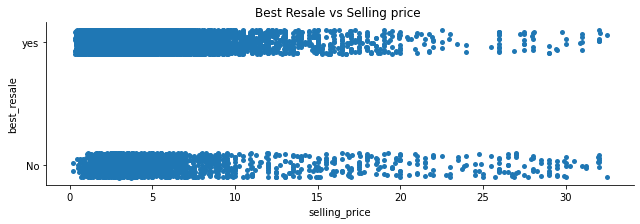

In [ ]:
sns.catplot(data=carsData, y="best_resale", x="selling_price",height=3, aspect=3)
plt.title("Best Resale vs Selling price ")
plt.plot()

### Multivariant analysis

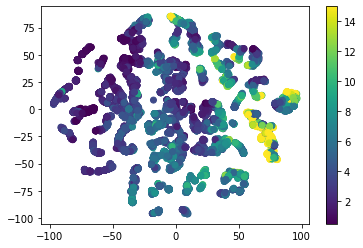

In [ ]:
# From basic statistical analysis 75% of the selling price is around 6.5 lakhs but max value is 100 lakhs 
# Hence color limit(clim)= 15
xtsne=TSNE(perplexity=50)
results=xtsne.fit_transform(carsData[['mileage', 'engine', 'max_power', 'seats', 'age']])
vis_x = results[:, 0]
vis_y = results[:, 1]
plt.scatter(vis_x, vis_y, c=carsData['selling_price'])
plt.colorbar()
plt.clim(0.5, 15)
plt.show()

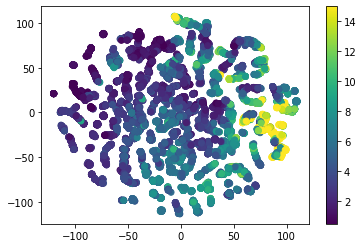

In [ ]:
xtsne=TSNE(perplexity=30)
results=xtsne.fit_transform(carsData[['mileage', 'engine', 'max_power', 'seats', 'age']])
vis_x = results[:, 0]
vis_y = results[:, 1]
plt.scatter(vis_x, vis_y, c=carsData['selling_price'])
plt.colorbar()
plt.clim(0.5, 15)
plt.show()

**Observation**
* Color bar indicates in lakhs.
* Cars price more then 14 laks have a seperate cluster.
* Darker clusters are of car price less than 4 lakhs.

# Feature selection
* Corelation coefficient - numerical
* chi square test for categorical
* Decision feature selection.

#### Correlation Test(numeric vs numerical features)

Using Spearman corelation because:
* we have pairs of continuous variables and the relationships between them don’t follow a straight line but they follow a monotonic relationship.
* Outliers are observed in most of the features.

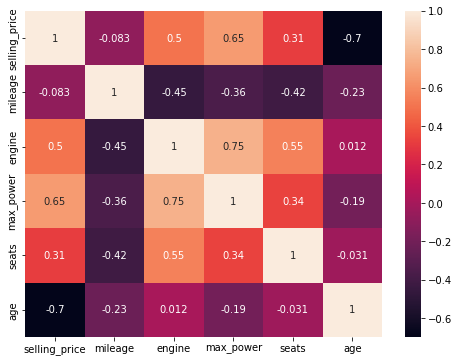

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(carsData.corr(method='spearman'), annot=True)
plt.show()

**Numerical Feature Selection**
* Used spearman rank corelation since there is no linear relationship between independent and dependent features.
* 1) Age is negatively corelated to selling price (target).
* 2) max power and Engine are positive.

**NOTE**
* 1) Max power and engine are multi colinear, drop engine if using linear regression.

#### CatBoost model for categorical feature selection

In [ ]:
#List of categorical columns
categoricalColumns = carsData.select_dtypes(include=["object"]).columns.tolist()
carsCatData = carsData[categoricalColumns]
print("Names of categorical columns : ", categoricalColumns)
carsCatData.head()

Names of categorical columns :  ['make', 'model', 'variant', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner', 'best_resale', 'seats_cat']


,make,model,variant,km_driven,fuel,seller_type,transmission,owner,best_resale,seats_cat
0,Maruti,Swift Dzire,VDI,140000 - 150000 Km,Diesel,Individual,Manual,1st owner,yes,5andBelow
1,Skoda,Rapid,1.5 TDI AMBITION,110000 - 120000 Km,Diesel,Individual,Manual,2nd owner,No,5andBelow
2,Honda,City,2017-2020 EXI,130000 - 140000 Km,Petrol,Individual,Manual,3rd owner,yes,5andBelow
3,Hyundai,i20,SPORTZ DIESEL,120000 - 130000 Km,Diesel,Individual,Manual,1st owner,yes,5andBelow
4,Maruti,Swift,VXI BSIII,110000 - 120000 Km,Petrol,Individual,Manual,1st owner,yes,5andBelow


In [ ]:
#creating independent variables as X and target/dependent variable as y
y= carsData['selling_price']
X= carsCatData

#Let’s split X and y using Train test split
# Stratify y so that ML model gets trained on testing car models.
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state= 42, stratify=X['make'])

#get shape of train and test data
print("train data size:",X_train.shape)
print("test data size:",X_test.shape)

train data size: (8975, 10)
test data size: (2244, 10)


In [ ]:
# Define list of categorical features, If no categorical features are defined, CatBoost will consider them as numerical.

#Get location of categorical columns
cat_features_indx = [X.columns.get_loc(col) for col in carsCatData]
print("Location of categorical columns : ",cat_features_indx)


Location of categorical columns :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [ ]:
# importing Pool
from catboost import Pool
#Creating pool object for train dataset. we give information of categorical fetures to parameter cat_fetaures
train_data = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features_indx
                 )

#Creating pool object for test dataset
test_data = Pool(data=X_test,
                  label=y_test,
                  cat_features=cat_features_indx
                 )

In [ ]:
#build model
cars_cat_model = CatBoostRegressor(loss_function='RMSE')
# Fit model 
cars_cat_model.fit( train_data,
               eval_set=(test_data))

Learning rate set to 0.071866
0:	learn: 4.0825332	test: 4.1558637	best: 4.1558637 (0)	total: 87.7ms	remaining: 1m 27s
1:	learn: 3.9120177	test: 3.9864508	best: 3.9864508 (1)	total: 122ms	remaining: 1m 1s
2:	learn: 3.7611470	test: 3.8414791	best: 3.8414791 (2)	total: 162ms	remaining: 53.8s
3:	learn: 3.6204444	test: 3.7030881	best: 3.7030881 (3)	total: 189ms	remaining: 47s
4:	learn: 3.4908294	test: 3.5728106	best: 3.5728106 (4)	total: 214ms	remaining: 42.6s
5:	learn: 3.3656419	test: 3.4402338	best: 3.4402338 (5)	total: 273ms	remaining: 45.2s
6:	learn: 3.2598334	test: 3.3352368	best: 3.3352368 (6)	total: 304ms	remaining: 43.2s
7:	learn: 3.1679772	test: 3.2448308	best: 3.2448308 (7)	total: 321ms	remaining: 39.8s
8:	learn: 3.0761825	test: 3.1540656	best: 3.1540656 (8)	total: 339ms	remaining: 37.4s
9:	learn: 2.9929412	test: 3.0668317	best: 3.0668317 (9)	total: 376ms	remaining: 37.2s
10:	learn: 2.9156234	test: 2.9882163	best: 2.9882163 (10)	total: 423ms	remaining: 38s
11:	learn: 2.8449461	tes

Text(0.5, 1.0, 'features importance')

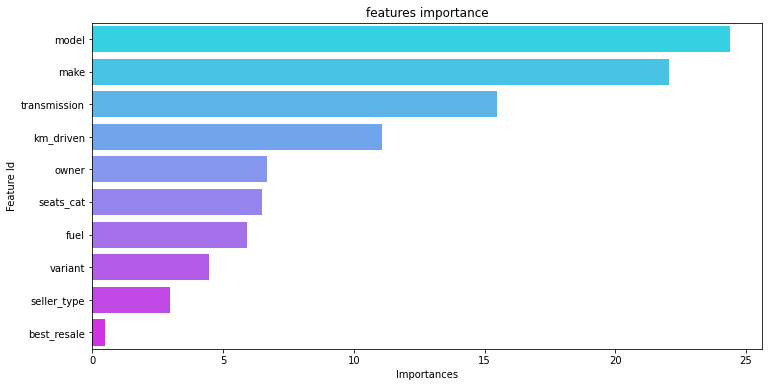

In [ ]:
# Create a dataframe of feature importance 
df_feature_importance = pd.DataFrame(cars_cat_model.get_feature_importance(prettified=True))
#plotting feature importance
plt.figure(figsize=(12, 6));
feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool");
plt.title('features importance')

**Observation**
* Make, model, transission, km_driven, Owner, Seats_cat and fuel have high feature importance compared to the rest.

In [ ]:
# Cleaned cars data export as CSV
#carsData.to_csv("/content/cleaned_carsData.csv",index=False)

eval = pd.read_csv("/content/cleaned_carsData.csv")
eval.head(3)

,make,model,variant,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,age,best_resale,seats_cat
0,Maruti,Swift Dzire,VDI,4.50,140000 - 150000 Km,Diesel,Individual,Manual,1st owner,23.40,1.25,74.00,5.0,8.0,yes,5andBelow
1,Skoda,Rapid,1.5 TDI AMBITION,3.70,110000 - 120000 Km,Diesel,Individual,Manual,2nd owner,21.14,1.50,103.52,5.0,8.0,No,5andBelow
2,Honda,City,2017-2020 EXI,1.58,130000 - 140000 Km,Petrol,Individual,Manual,3rd owner,17.70,1.50,78.00,5.0,16.0,yes,5andBelow


In [ ]:
# Feature selection considering both numerical and catagorical.
finalFeatureLst = ['make', 'model','transmission','km_driven','fuel','owner','age', 'max_power','engine','selling_price']

In [ ]:
# Finale dataframe for encoding
final_carsData = carsData[finalFeatureLst].copy()
final_carsData.head()

,make,model,transmission,km_driven,fuel,owner,age,max_power,engine,selling_price
0,Maruti,Swift Dzire,Manual,140000 - 150000 Km,Diesel,1st owner,8.0,74.00,1.25,4.50
1,Skoda,Rapid,Manual,110000 - 120000 Km,Diesel,2nd owner,8.0,103.52,1.50,3.70
2,Honda,City,Manual,130000 - 140000 Km,Petrol,3rd owner,16.0,78.00,1.50,1.58
3,Hyundai,i20,Manual,120000 - 130000 Km,Diesel,1st owner,12.0,90.00,1.40,2.25
4,Maruti,Swift,Manual,110000 - 120000 Km,Petrol,1st owner,15.0,88.20,1.30,1.30


In [ ]:
# Performing get dummies before split since selected categorial features will not have new data in future.

final_carsData = final_carsData.join(pd.get_dummies(final_carsData[['transmission','fuel','owner']],drop_first=True))
#final_carsData.drop(['transmission','fuel','owner'],axis=1, inplace=True)

# Has both one hot encoded and parent features
final_carsData.head(3)

,make,model,transmission,km_driven,fuel,owner,age,max_power,engine,selling_price,transmission_Manual,fuel_Petrol,fuel_Petrol + AltFuel,owner_2nd owner,owner_3rd owner,owner_4th & above owner,owner_Test Drive Car,owner_UnRegistered Car
0,Maruti,Swift Dzire,Manual,140000 - 150000 Km,Diesel,1st owner,8.0,74.00,1.25,4.50,1,0,0,0,0,0,0,0
1,Skoda,Rapid,Manual,110000 - 120000 Km,Diesel,2nd owner,8.0,103.52,1.50,3.70,1,0,0,1,0,0,0,0
2,Honda,City,Manual,130000 - 140000 Km,Petrol,3rd owner,16.0,78.00,1.50,1.58,1,1,0,0,1,0,0,0


# Train Test & CV Split

In [ ]:
# No CV split seperately because data size is small.
# We will use sklearn cross validation and k forld cross validation to validate the model intenally.

# Choosing independent(X) and dependent feature(y)
X = final_carsData.drop("selling_price", axis = 1)
y = final_carsData['selling_price']

# Stratify split ['make'] since we require all the brands to be present in train and test.
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state = 35, stratify=X['make'])
#X_train,X_cv,y_train,y_cv = train_test_split(X_train,y_train,test_size=0.2, random_state = 35, stratify=X_train['make'])

#get shape of train and test data
print("train data size:",X_train.shape)
print("test data size:",X_test.shape)

print("train data size:",y_train.shape)
print("test data size:",y_test.shape)

train data size: (8975, 17)
test data size: (2244, 17)
train data size: (8975,)
test data size: (2244,)


# Feature Encoding

In [ ]:
# List of categorical features 
final_carsData.select_dtypes(include=['object']).columns

Index(['make', 'model', 'transmission', 'km_driven', 'fuel', 'owner'], dtype='object')

In [ ]:
# Creating multiple train test split


# 1) for ML models that do not need encoding and scaling
X_tr_wo_enc = X_train[['make','model', 'transmission', 'km_driven', 'fuel', 'owner', 'age', 'max_power', 'engine']].copy() # Default deep = True
X_te_wo_enc = X_test[['make','model', 'transmission', 'km_driven', 'fuel', 'owner', 'age', 'max_power', 'engine']].copy()

# Create new train test data for encoded data for features need to be encoded and already one hot encoded
X_train_enc = X_train[['make', 'model', 'km_driven','age',
       'max_power', 'engine', 'transmission_Manual', 'fuel_Petrol',
       'fuel_Petrol + AltFuel', 'owner_2nd owner', 'owner_3rd owner',
       'owner_4th & above owner', 'owner_Test Drive Car',
       'owner_UnRegistered Car']].copy() 
X_test_enc = X_test[['make', 'model', 'km_driven','age',
       'max_power', 'engine', 'transmission_Manual', 'fuel_Petrol',
       'fuel_Petrol + AltFuel', 'owner_2nd owner', 'owner_3rd owner',
       'owner_4th & above owner', 'owner_Test Drive Car',
       'owner_UnRegistered Car']].copy()


In [ ]:
# Source: https://medium.com/analytics-vidhya/categorical-variable-encoding-techniques-17e607fe42f9#:~:text=Count%20or%20frequency%20encoding%3A%20Replace,of%20observations%20in%20the%20dataset.

# 1) Make, Model and km_driven has too many categories and we will encode based on frequency of their category
 
freq_enc_feat = ['make', 'model', 'km_driven']

for col in freq_enc_feat:

  # Creating dictonary of value and count on train data [fit]
  count_map = X_train_enc[col].value_counts().to_dict()

  # Map the column with dictonary values on train and test data - no data leakage,[transform]
  X_train_enc[col] = X_train_enc[col].map(count_map)
  X_test_enc[col] = X_test_enc[col].map(count_map)

  # Possible null values in test data while mapping and will replace them with least occuring count
  if X_test_enc[col].isnull().any():
    X_test_enc[col].fillna(X_test_enc[col].min(),inplace=True)

In [ ]:
# Splitting numerical and categorica features for ease of trasnsformation
num_feat = ['make','model','km_driven','age','max_power','engine']
cat_feat = ['transmission_Manual', 'fuel_Petrol', 'fuel_Petrol + AltFuel',
       'owner_2nd owner', 'owner_3rd owner', 'owner_4th & above owner',
       'owner_Test Drive Car', 'owner_UnRegistered Car']

X_train_enc_num = X_train_enc[num_feat].copy()
X_test_enc_num = X_test_enc[num_feat].copy()

X_train_enc_cat = X_train_enc[cat_feat].copy()
X_test_enc_cat = X_test_enc[cat_feat].copy()

In [ ]:
# Drop multi colinear feature
# Engine and max power are colinear, since max_power is highly corelated with Y we will drop engine

X_train_enc_num.drop('engine',axis=1,inplace=True)
X_test_enc_num.drop('engine',axis=1,inplace=True)

In [ ]:
# Normalizing numerical data

norm = MinMaxScaler()
X_tr_norm = norm.fit_transform(X_train_enc_num)
X_te_norm = norm.transform(X_test_enc_num)

In [ ]:
# Combining whole data using H stack

final_train = np.hstack((X_tr_norm,X_train_enc_cat))
final_test = np.hstack((X_te_norm,X_test_enc_cat))

# Predective modelling

## CatBoost Regressor

In [ ]:
# Since no need for encoding using features prior to encoding

# Define list of categorical features, If no categorical features are defined, CatBoost will consider them as numerical.

#List of categorical columns
categoricalColumns = X_tr_wo_enc.select_dtypes(include=["object"]).columns.tolist()
print("Names of categorical columns : ", categoricalColumns)
#Get location of categorical columns
cat_features = [X_tr_wo_enc.columns.get_loc(col) for col in categoricalColumns]
print("Location of categorical columns : ",cat_features)


Names of categorical columns :  ['make', 'model', 'transmission', 'km_driven', 'fuel', 'owner']
Location of categorical columns :  [0, 1, 2, 3, 4, 5]


In [ ]:
# catboost regressor with inbuilt random_search method

train_data = Pool(data = X_tr_wo_enc, label = y_train, cat_features = cat_features )
train_labels = y_train

cat_model = CatBoostRegressor(loss_function='RMSE')


grid = {'learning_rate': [0.03,0.05,0.07,0.1],
        'depth': [1,2,3,4],
        'iterations' : [100,500,1000,2000,3000]}

randomized_search_result = cat_model.randomized_search(grid,train_data)

Streaming output truncated to the last 5000 lines.
1009:	learn: 0.9878632	test: 1.1220845	best: 1.1220029 (1007)	total: 14.4s	remaining: 28.4s
1010:	learn: 0.9875993	test: 1.1219871	best: 1.1219871 (1010)	total: 14.4s	remaining: 28.4s
1011:	learn: 0.9874008	test: 1.1220212	best: 1.1219871 (1010)	total: 14.4s	remaining: 28.3s
1012:	learn: 0.9873076	test: 1.1220181	best: 1.1219871 (1010)	total: 14.4s	remaining: 28.3s
1013:	learn: 0.9869989	test: 1.1217136	best: 1.1217136 (1013)	total: 14.4s	remaining: 28.3s
1014:	learn: 0.9869638	test: 1.1217103	best: 1.1217103 (1014)	total: 14.4s	remaining: 28.2s
1015:	learn: 0.9868692	test: 1.1215406	best: 1.1215406 (1015)	total: 14.4s	remaining: 28.2s
1016:	learn: 0.9868504	test: 1.1215343	best: 1.1215343 (1016)	total: 14.5s	remaining: 28.2s
1017:	learn: 0.9867198	test: 1.1215159	best: 1.1215159 (1017)	total: 14.5s	remaining: 28.2s
1018:	learn: 0.9865322	test: 1.1214965	best: 1.1214965 (1018)	total: 14.5s	remaining: 28.1s
1019:	learn: 0.9862818	test: 

Evaluation on test data
MAD: 0.45
MAE: 0.73
RMSE: 1.20
R2: 0.92
Adjusted R2: 0.92

Visualizing the Predicted



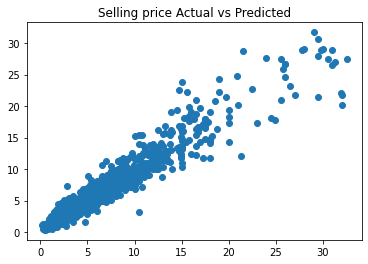

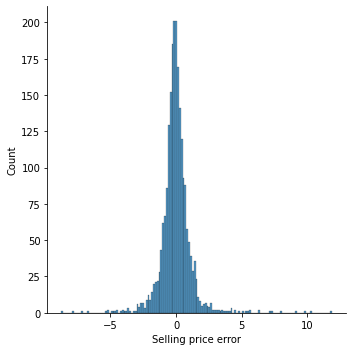

In [ ]:
#randomized_search_result

def randomized_result(model,xtrain,xtest,ytest):
    """
    Returns predicted value w.r.t regression metrics and visualization
    """
     
   # Predict
    y_predict= model.predict(xtest)
    # median_absolute_error
    median_abs_err_test = median_absolute_error(ytest,y_predict)
    # MAE
    Mae_test = mean_absolute_error(ytest,y_predict)
    #RMSE
    Rmse_test = math.sqrt(mean_squared_error(ytest,y_predict))
    #R2 Score
    r2_test = r2_score(ytest,y_predict)
    # Adjusted R2 Score
    n= xtrain.shape[0] # total no of datapoints
    p= xtrain.shape[1] # total no of independent features
    adj_r2_test = 1-(((1-r2_test)*(n-1))/(n-p-1))
    #print results
    print("Evaluation on test data")
    print("MAD: {:.2f}".format(median_abs_err_test))
    print("MAE: {:.2f}".format(Mae_test))
    print("RMSE: {:.2f}".format(Rmse_test))
    print("R2: {:.2f}".format(r2_test))
    print("Adjusted R2: {:.2f}\n".format(adj_r2_test))

    print("Visualizing the Predicted\n")
    plt.scatter(y_test,y_predict)
    plt.title('Selling price Actual vs Predicted')
    sns.displot(y_test-y_predict)
    plt.xlabel("Selling price error")
    plt.show()

# #randomized_search_result
randomized_result(cat_model,X_tr_wo_enc,X_te_wo_enc,y_test)

**Observation**
* **From metrics**
* Error of Rupees 45 to 73 thousand differece in selling price.
* Model is able to explain 92% of variance in selling price.
* **From visualition**
* Car Values predicted greater than 15 lakhs are spread out.
* Most of the errors are close to zero but a few have large variance.

## Light GBM Regression

In [ ]:
# make dtype as 'category' for categorical features

# To get all the column name with object type
list_obj_cols = X_tr_wo_enc.columns[X_tr_wo_enc.dtypes == "object"].tolist()

# Train
for obj_col in list_obj_cols:
    X_tr_wo_enc[obj_col] = X_tr_wo_enc[obj_col].astype("category")

#Test
for obj_col in list_obj_cols:
    X_te_wo_enc[obj_col] = X_te_wo_enc[obj_col].astype("category")

In [ ]:
#build model
lgbmr = lgb.LGBMRegressor(loss_function='RMSE')

# Parameters to be used for RandomizedSearchCV-
rs_params = {
      'n_estimators' : [100,300,500,900,1200,1700,3000],
        'learning_rate ': [0.1,0.3,0.5,0.7, 1],
        'num_leaves': [10,30,50,70,100]

}

lgb_rs = RandomizedSearchCV(estimator=lgbmr,param_distributions=rs_params,n_jobs=-1,cv=5, verbose=2, random_state=35)

# Fit model 
lgb_rs.fit(X_tr_wo_enc,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=LGBMRegressor(loss_function='RMSE'),
                   n_jobs=-1,
                   param_distributions={'learning_rate ': [0.1, 0.3, 0.5, 0.7,
                                                           1],
                                        'n_estimators': [100, 300, 500, 900,
                                                         1200, 1700, 3000],
                                        'num_leaves': [10, 30, 50, 70, 100]},
                   random_state=35, verbose=2)

Evaluation on test data
MAD: 0.43
MAE: 0.71
RMSE: 1.18
R2: 0.93
Adjusted R2: 0.93

Visualizing the Predicted



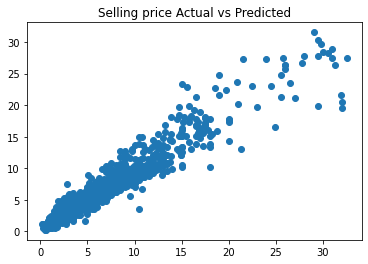

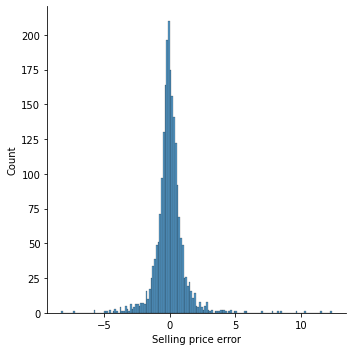

In [ ]:
#randomized_search_result
randomized_result(lgb_rs,X_tr_wo_enc,X_te_wo_enc,y_test)

**Observation**
* **From metrics**
* Error of Rupees 43 to 71 thousand differece in selling price.
* Model is able to explain 93% of variance in selling price.
* **From visualition**
* Car Values predicted greater than 15 lakhs are spread out.
* Most of the errors are close to zero but a few have large variance.

## Random Forest Regression



In [ ]:
# Creating a base model to run random search
rf_reg = RandomForestRegressor()

# Number of trees in random forest 
n_estim = [int(x) for x in np.linspace(start=100, stop=1200, num=12)]
max_feat = [7,'sqrt','log2']
max_dept = [1,3,5]
min_sample_split = [2,5,10,15,100]
min_sample_leaf = [1,2,5,10]

In [ ]:
# creating random grid

random_grid = {'n_estimators':n_estim,
               'max_features':max_feat,
               'max_depth':max_dept,
               'min_samples_split':min_sample_split,
               'min_samples_leaf':min_sample_leaf}
print(random_grid)               

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'max_features': [7, 'sqrt', 'log2'], 'max_depth': [1, 3, 5], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]}


In [ ]:
rs_rf_reg = RandomizedSearchCV(estimator=rf_reg,param_distributions=random_grid,
                               scoring='neg_mean_squared_error', n_iter=10,
                               cv=5, verbose=2, n_jobs=1, random_state = 35)

rs_rf_reg.fit(final_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, n_estimators=1000; total time=   5.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, n_estimators=1000; total time=   3.5s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, n_estimators=1000; total time=   3.5s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, n_estimators=1000; total time=   7.8s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, n_estimators=1000; total time=   7.0s
[CV] END max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=   7.3s
[CV] END max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=   7.8s
[CV] END max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_es

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [1, 3, 5],
                                        'max_features': [7, 'sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=35, scoring='neg_mean_squared_error',
                   verbose=2)

Evaluation on test data
MAD: 0.74
MAE: 1.14
RMSE: 1.79
R2: 0.83
Adjusted R2: 0.83

Visualizing the Predicted



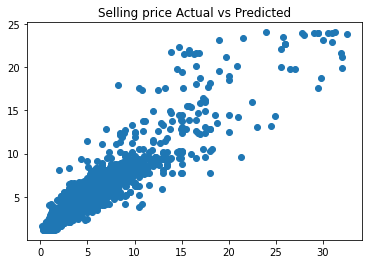

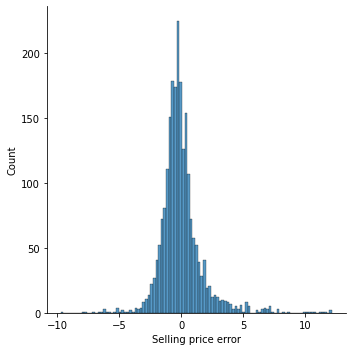

In [ ]:
#randomized_search_result
randomized_result(rs_rf_reg,final_train,final_test,y_test)

**Observation**
* **From metrics**
* Error of Rupees 74 to 114 thousand differece in selling price.
* Model is able to explain 83% of variance in selling price.
* **From visualition**
* Car Values predicted greater than 15 lakhs are spread out.
* Most of the errors are close to zero but a few have large variance.

## Support Vector Regressor

In [ ]:
svr = SVR(kernel = 'rbf')
param = {
    'kernel': ('linear', 'rbf','poly'), 
     'C': [0.01,0.1,0.5,1,3,7],
     'gamma': [1e-7, 1e-4, 'scale'],
     'epsilon': [0.1,0.3,0.5,0.7,0.9]
}

rs_svr = RandomizedSearchCV(estimator=svr,param_distributions=param, n_jobs=-1, cv=5, random_state=35, 
                            scoring='neg_mean_squared_error', n_iter=10,verbose=2)
rs_svr.fit(final_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 0.5, 1, 3, 7],
                                        'epsilon': [0.1, 0.3, 0.5, 0.7, 0.9],
                                        'gamma': [1e-07, 0.0001, 'scale'],
                                        'kernel': ('linear', 'rbf', 'poly')},
                   random_state=35, scoring='neg_mean_squared_error',
                   verbose=2)

Evaluation on test data
MAD: 0.70
MAE: 1.17
RMSE: 2.02
R2: 0.78
Adjusted R2: 0.78

Visualizing the Predicted



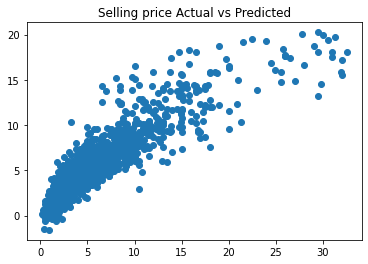

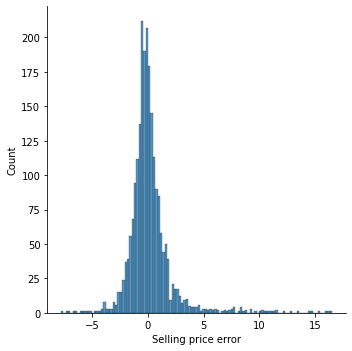

In [ ]:
#randomized_search_result
randomized_result(rs_svr,final_train,final_test,y_test)

**Observation**
* **From metrics**
* Error of Rupees 70 to 117 thousand differece in selling price.
* Cat boost is able to explain 78% of variance in selling price.
* **From visualition**
* Car Values predicted greater than 15 lakhs are spread out.
* Most of the errors are close to zero but a few have large variance.

## Decision Tree Regression 

In [ ]:
dtr = DecisionTreeRegressor()
dt_param = {
    'max_depth':[10,50,100,300,500,1000], 
    'min_samples_split':[2,5,7,9], 
    'min_samples_leaf':[1,3,5]}

rs_dtr = RandomizedSearchCV(estimator=dtr, param_distributions=dt_param, n_jobs=-1, cv=10, random_state=35, 
                            scoring='neg_mean_squared_error', n_iter=10,verbose=2)

rs_dtr.fit(final_train,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [10, 50, 100, 300, 500,
                                                      1000],
                                        'min_samples_leaf': [1, 3, 5],
                                        'min_samples_split': [2, 5, 7, 9]},
                   random_state=35, scoring='neg_mean_squared_error',
                   verbose=2)

Evaluation on test data
MAD: 0.52
MAE: 0.86
RMSE: 1.48
R2: 0.88
Adjusted R2: 0.88

Visualizing the Predicted



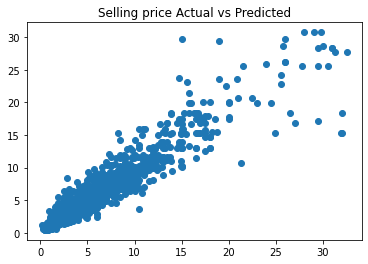

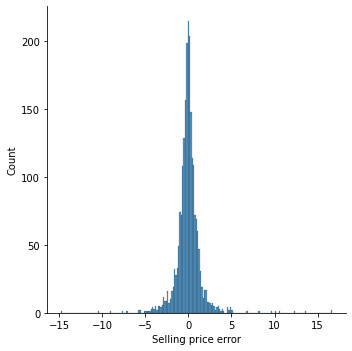

In [ ]:
#randomized_search_result
randomized_result(rs_dtr,final_train,final_test,y_test)

**Observation**
* **From metrics**
* Error of Rupees 52 to 86 thousand differece in selling price.
* Model is able to explain 88% of variance in selling price.
* **From visualition**
* Car Values predicted greater than 15 lakhs are spread out.
* Most of the errors are close to zero but a few have large variance.

## KNN Regressor

In [ ]:
knr = KNeighborsRegressor()
knr_param = {
    'leaf_size':[10,20,30,50,70], 
    'n_neighbors':[2,5,7,9]
}

rs_knr = RandomizedSearchCV(estimator=knr, param_distributions=knr_param, n_jobs=-1, cv=10, random_state=35, 
                            scoring='neg_mean_squared_error', n_iter=10,verbose=2)

rs_knr.fit(final_train,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=KNeighborsRegressor(), n_jobs=-1,
                   param_distributions={'leaf_size': [10, 20, 30, 50, 70],
                                        'n_neighbors': [2, 5, 7, 9]},
                   random_state=35, scoring='neg_mean_squared_error',
                   verbose=2)

Evaluation on test data
MAD: 0.59
MAE: 1.03
RMSE: 1.78
R2: 0.83
Adjusted R2: 0.83

Visualizing the Predicted



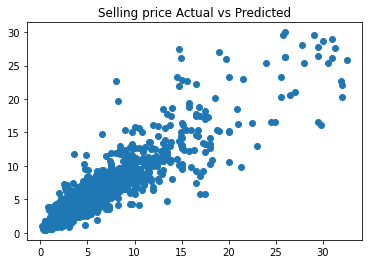

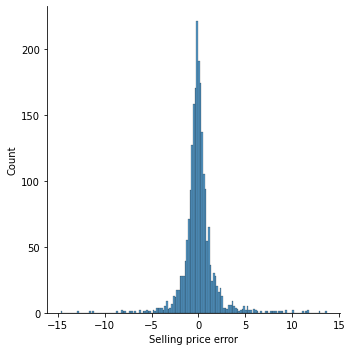

In [ ]:
#randomized_search_result
randomized_result(rs_knr,final_train,final_test,y_test)

**Observation**
* **From metrics**
* Error of Rupees 59 to 103 thousand differece in selling price.
* Cat boost is able to explain 83% of variance in selling price.
* **From visualition**
* Car Values predicted greater than 15 lakhs are spread out.
* Most of the errors are close to zero but a few have large variance.

## Neural Network Regression 

### Sklearn MLP Regressor


In [ ]:
mlpr = MLPRegressor(random_state=35,early_stopping=True, verbose=True)

param = {
    'activation':['relu'],
    'alpha': [0.0001,0.001, 0.005, 0.01, 0.05, 0.09, 0.1],
    'hidden_layer_sizes' : [(10,10),(20,30),(40,50),(10,100)],
    'learning_rate' : ['adaptive','constant'],
    'learning_rate_init' : [0.0001,0.001,0.005,0.01],
    'max_iter' : [500,1000,3000]

}

rs_mlpr = RandomizedSearchCV(estimator=mlpr,param_distributions=param, random_state=35, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')

# Train the model

rs_mlpr.fit(final_train, y_train)

Iteration 1, loss = 14.21090966
Validation score: -0.039472
Iteration 2, loss = 6.86514338
Validation score: 0.555500
Iteration 3, loss = 3.24500218
Validation score: 0.721084
Iteration 4, loss = 2.21403564
Validation score: 0.795228
Iteration 5, loss = 1.80573249
Validation score: 0.817797
Iteration 6, loss = 1.62785445
Validation score: 0.831759
Iteration 7, loss = 1.53078858
Validation score: 0.838541
Iteration 8, loss = 1.44977822
Validation score: 0.843108
Iteration 9, loss = 1.40252413
Validation score: 0.849033
Iteration 10, loss = 1.38492898
Validation score: 0.841560
Iteration 11, loss = 1.35143393
Validation score: 0.851102
Iteration 12, loss = 1.31950251
Validation score: 0.849266
Iteration 13, loss = 1.30280505
Validation score: 0.854793
Iteration 14, loss = 1.28370731
Validation score: 0.850163
Iteration 15, loss = 1.27500249
Validation score: 0.859387
Iteration 16, loss = 1.26242340
Validation score: 0.848315
Iteration 17, loss = 1.26201300
Validation score: 0.853877
Iter

RandomizedSearchCV(cv=5,
                   estimator=MLPRegressor(early_stopping=True, random_state=35,
                                          verbose=True),
                   n_jobs=-1,
                   param_distributions={'activation': ['relu'],
                                        'alpha': [0.0001, 0.001, 0.005, 0.01,
                                                  0.05, 0.09, 0.1],
                                        'hidden_layer_sizes': [(10, 10),
                                                               (20, 30),
                                                               (40, 50),
                                                               (10, 100)],
                                        'learning_rate': ['adaptive',
                                                          'constant'],
                                        'learning_rate_init': [0.0001, 0.001,
                                                               0.005, 0.01],
                                        'max_iter': [500, 1000, 3000]},
                   random_state=35, scoring='neg_mean_squared_error')

Evaluation on test data
MAD: 0.66
MAE: 1.02
RMSE: 1.59
R2: 0.87
Adjusted R2: 0.87

Visualizing the Predicted



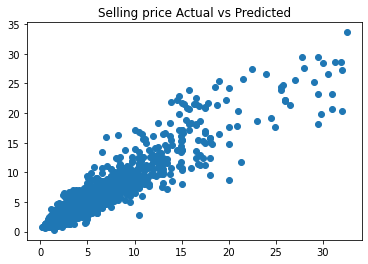

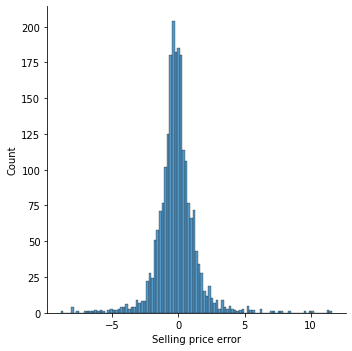

In [ ]:
#randomized_search_result
randomized_result(rs_mlpr,final_train,final_test,y_test)

**Observation**
* **From metrics**
* Error of Rupees 66 to 102 thousand differece in selling price.
* Model is able to explain 87% of variance in selling price.
* **From visualition**
* Car Values predicted greater than 15 lakhs are spread out.
* Most of the errors are close to zero but a few have large variance.

### Tensorflow Regression

In [ ]:
# Creating model using the Sequential in tensorflow

reg_nn = Sequential()

# Input layer
reg_nn.add(Dense(8,input_shape=(13,)))

# Adding first Dense layer and dropout
reg_nn.add(Dense(160, kernel_initializer='normal', activation='relu'))
reg_nn.add(Dropout(0.2))

# Add second layer
reg_nn.add(Dense(480, kernel_initializer='normal', activation='relu'))
reg_nn.add(Dropout(0.2))

# Add third layer
reg_nn.add(Dense(260, kernel_initializer='normal', activation='relu'))
#reg_model.add(Dropout(0.2))

# Output node, liner activatino for regression
reg_nn.add(Dense(1, kernel_initializer='normal', activation='linear'))

# summery
reg_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 112       
                                                                 
 dense_1 (Dense)             (None, 160)               1440      
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_2 (Dense)             (None, 480)               77280     
                                                                 
 dropout_1 (Dropout)         (None, 480)               0         
                                                                 
 dense_3 (Dense)             (None, 260)               125060    
                                                                 
 dense_4 (Dense)             (None, 1)                 2

In [ ]:
reg_nn.compile(optimizer=Adam(learning_rate=1e-3),
               loss=MeanSquaredError(),
               metrics= RootMeanSquaredError())

In [ ]:
reg_nn.fit(final_train,y_train.values,
           epochs=30, batch_size=64,validation_split=0.2)

Epoch 1/30
113/113 [==============================] - 3s 12ms/step - loss: 13.9332 - root_mean_squared_error: 3.7327 - val_loss: 5.4029 - val_root_mean_squared_error: 2.3244
Epoch 2/30
113/113 [==============================] - 1s 10ms/step - loss: 4.6385 - root_mean_squared_error: 2.1537 - val_loss: 3.9644 - val_root_mean_squared_error: 1.9911
Epoch 3/30
113/113 [==============================] - 1s 10ms/step - loss: 3.7387 - root_mean_squared_error: 1.9336 - val_loss: 3.4193 - val_root_mean_squared_error: 1.8491
Epoch 4/30
113/113 [==============================] - 1s 10ms/step - loss: 3.2636 - root_mean_squared_error: 1.8065 - val_loss: 3.0654 - val_root_mean_squared_error: 1.7508
Epoch 5/30
113/113 [==============================] - 2s 22ms/step - loss: 3.1192 - root_mean_squared_error: 1.7661 - val_loss: 3.0427 - val_root_mean_squared_error: 1.7443
Epoch 6/30
113/113 [==============================] - 3s 30ms/step - loss: 3.0215 - root_mean_squared_error: 1.7382 - val_loss: 2.9285

71/71 [==============================] - 0s 4ms/step
Evaluation on test data
MAD: 0.68
MAE: 1.02
RMSE: 1.56
R2: 0.87
Adjusted R2: 0.87

Visualizing the Predicted



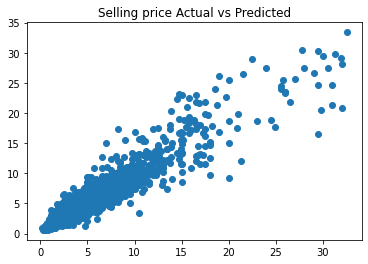

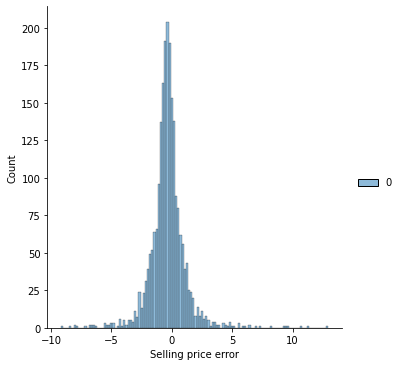

In [ ]:
# randomized_search_result

# Predict
y_predict= reg_nn.predict(final_test)
# median_absolute_error
median_abs_err_test = median_absolute_error(y_test,y_predict)
# MAE
Mae_test = mean_absolute_error(y_test,y_predict)
#RMSE
Rmse_test = math.sqrt(mean_squared_error(y_test,y_predict))
#R2 Score
r2_test = r2_score(y_test,y_predict)
# Adjusted R2 Score
n= final_train.shape[0] # total no of datapoints
p= final_train.shape[1] # total no of independent features
adj_r2_test = 1-(((1-r2_test)*(n-1))/(n-p-1))
#print results
print("Evaluation on test data")
print("MAD: {:.2f}".format(median_abs_err_test))
print("MAE: {:.2f}".format(Mae_test))
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}\n".format(adj_r2_test))

print("Visualizing the Predicted\n")
plt.scatter(y_test,y_predict)
plt.title('Selling price Actual vs Predicted')
sns.displot(y_test.values.reshape(-1,1)-y_predict)
plt.xlabel("Selling price error")
plt.show()

**Observation**
* **From metrics**
* Error of Rupees 68 to 102 thousand differece in selling price.
* Model is able to explain 87% of variance in selling price.
* **From visualition**
* Car Values predicted greater than 15 lakhs are spread out.
* Most of the errors are close to zero but a few have large variance.

# Summary

In [ ]:
# Specify the Column Names while initializing the Table

evaluation_table = PrettyTable(["Regression Model", "MAD", "MAE", "R2","adj R2"])

# adding rows
evaluation_table.add_row(["Cat Boost",0.45,0.73,0.92,0.92])
evaluation_table.add_row(["Light GBM",0.43,0.71,0.93,0.93])
evaluation_table.add_row(["Random Forest",0.74,1.14,0.83,0.83])
evaluation_table.add_row(["Support Vector",0.70,1.17,0.78,0.78])
evaluation_table.add_row(["Decision Tree",0.52,0.86,0.88,0.88])
evaluation_table.add_row(["KNN",0.59,1.03,0.83,0.83])
evaluation_table.add_row(["ANN sklearn",0.66,1.02,0.87,0.87])
evaluation_table.add_row(["ANN TF",0.68,1.02,0.87,0.87])

#Print
print(evaluation_table)

+------------------+------+------+------+--------+
| Regression Model | MAD  | MAE  |  R2  | adj R2 |
+------------------+------+------+------+--------+
|    Cat Boost     | 0.45 | 0.73 | 0.92 |  0.92  |
|    Light GBM     | 0.43 | 0.71 | 0.93 |  0.93  |
|  Random Forest   | 0.74 | 1.14 | 0.83 |  0.83  |
|  Support Vector  | 0.7  | 1.17 | 0.78 |  0.78  |
|  Decision Tree   | 0.52 | 0.86 | 0.88 |  0.88  |
|       KNN        | 0.59 | 1.03 | 0.83 |  0.83  |
|   ANN sklearn    | 0.66 | 1.02 | 0.87 |  0.87  |
|      ANN TF      | 0.68 | 1.02 | 0.87 |  0.87  |
+------------------+------+------+------+--------+


**Observation**
* CatBoost and Light GBM have least MAD or MAE and highest RE or Adj R2.
* These models are explaining 92% of the variance in selling price.
* Choosing Cat Boost as final model since most of them are categorical features.

# Deploy

In [ ]:

# Open file where you want to store
#file= open('/content/drive/MyDrive/DS_DL_ML_AI_project/used car price prediction/UsedCarPricePred.pkl','wb') 

# Dump info to that file
#pickle.dump(cat_model,file)

# Conclusion

* Cat Boost model predicts used car price without the varient feature by using engine capicity and power as replacement for varient feature.

* The model was able to explain max 92% of the variance in the data.
* Error can be further reduced by adding more cars data for each variant, price segment and seller category.
